Similar to notebook [088] but using a single generator and compact syntax.

# Imports and Initialization

## Imports

In [1]:
from cbrain.climate_invariant import *
from cbrain.climate_invariant_utils import *
import pickle
#import h5netcdf
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


## Initialization

In [2]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}

In [3]:
climate_str = ['cold','hot','both']
set_str = ['train','valid','test']
test_clim_str = ['cold','hot','both','medium']

In [4]:
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']

In [5]:
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

In [6]:
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions

In [7]:
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

In [8]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

# Data Generators

## First, define generators necessary for rescaling

In [9]:
def train_gen_rescaling(input_rescaling):
    return DataGeneratorCI(
        data_fn = path_array['cold'][0],
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [10]:
train_gen_RH = train_gen_rescaling(in_vars)
train_gen_BMSE = train_gen_rescaling(in_vars)
train_gen_LHF_nsDELQ = train_gen_rescaling(in_vars)

## And generators only taking a subset of the data

### Implementation

In [11]:
class DataGeneratorCI_Small_Data(DataGenerator):
    def __init__(self, batch_list, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, 
             Qscaling=None,
             Tscaling=None,
             LHFscaling=None,
             SHFscaling=None,
             output_scaling=False,
             interpolate=False,
             hyam=None,hybm=None,
             inp_sub_Qscaling=None,inp_div_Qscaling=None,
             inp_sub_Tscaling=None,inp_div_Tscaling=None,
             inp_sub_LHFscaling=None,inp_div_LHFscaling=None,
             inp_sub_SHFscaling=None,inp_div_SHFscaling=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,epsQ=1e-3,epsT=1,
                 mode='train'):
        self.output_scaling = output_scaling
        self.interpolate = interpolate
        self.Qscaling = Qscaling
        self.Tscaling = Tscaling
        self.LHFscaling = LHFscaling
        self.SHFscaling = SHFscaling
        self.inp_shape = 64
        self.mode=mode
        self.batch_list = batch_list
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
        # Overwrite number of samples and number of batches
        self.n_samples = len(batch_list)*self.batch_size
        self.n_batches = int(np.floor(self.n_samples) / self.batch_size)
        ###################################################
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if Qscaling=='RH':
            self.QLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_sub_Qscaling,inp_div_Qscaling,hyam,hybm)
        elif Qscaling=='QSATdeficit':
            self.QLayer = QV2QSATdeficitNumpy(self.inp_sub,self.inp_div,inp_sub_Qscaling,inp_div_Qscaling,hyam,hybm)
        if Tscaling=='TfromNS':
            self.TLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='BCONS':
            self.TLayer = T2BCONSNumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='BMSE':
            self.TLayer = T2BMSENumpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        elif Tscaling=='T_NSto220':
            self.TLayer = T2T_NSto220Numpy(self.inp_sub,self.inp_div,inp_sub_Tscaling,inp_div_Tscaling,hyam,hybm)
        if LHFscaling=='LHF_nsDELQ':
            self.LHFLayer = LHF2LHF_nsDELQNumpy(self.inp_sub,self.inp_div,inp_sub_LHFscaling,inp_div_LHFscaling,hyam,hybm,epsQ)
        elif LHFscaling=='LHF_nsQ':
            self.LHFLayer = LHF2LHF_nsQNumpy(self.inp_sub,self.inp_div,inp_sub_LHFscaling,inp_div_LHFscaling,hyam,hybm,epsQ)
        if SHFscaling=='SHF_nsDELT':
            self.SHFLayer = SHF2SHF_nsDELTNumpy(self.inp_sub,self.inp_div,inp_sub_SHFscaling,inp_div_SHFscaling,hyam,hybm,epsT)
        if output_scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
    def __getitem__(self, index):
        # Compute start and end indices for batch
        # Modify generator behavior below to only take batches from the list
        start_idx = self.batch_list[index] * self.batch_size
        ####################################################################
        end_idx = start_idx + self.batch_size
        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]
        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = np.copy(X_norm)
        if self.Qscaling:
            X_result = self.QLayer.process(X_result)
        if self.Tscaling:
            # tgb - 3/21/2021 - BCONS needs qv in kg/kg as an input
            if self.Tscaling=='BCONS' or self.Tscaling=='BMSE':
                if self.Qscaling:
                    X_resultT = self.TLayer.process(X_norm)
                    X_result = np.concatenate([X_result[:,:30],X_resultT[:,30:60],X_result[:,60:]], axis=1)
                else:
                    X_result = self.TLayer.process(X_result)
            else:
                X_result = self.TLayer.process(X_result)
        if self.SHFscaling:
            X_result = self.SHFLayer.process(X_result)
        if self.LHFscaling:
            # tgb - 3/22/2021 - LHF_ns(DEL)Q needs qv in kg/kg and T in K
            if self.Qscaling or self.Tscaling:
                X_resultLHF = self.LHFLayer.process(X_norm)
                X_result = np.concatenate([X_result[:,:60],X_resultLHF[:,60:]],axis=1)
            else:
                X_result = self.LHFLayer.process(X_result)
        if self.output_scaling:
            scalings = self.scalingLayer.process(X)
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        if self.mode=='val':
            return xr.DataArray(X_result), xr.DataArray(Y)
        return X_result,Y
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        if self.Qscaling:
            X_result = self.QLayer.process(X_result)
        if self.Tscaling:
            X_result = self.TLayer.process(X_result)
        if self.SHFscaling:
            X_result = self.SHFLayer.process(X_result)
        if self.LHFscaling:
            X_result = self.LHFLayer.process(X_result)
        if self.scaling:
            scalings = self.scalingLayer.process(X)
            X_result = np.hstack((X_result,scalings))
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
        return X_result

In [12]:
def Generator_singleDS_smalldata(path,batch_list,batch_size,rescaling=None):
    
    in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
    path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI_Small_Data(
        batch_list = batch_list,
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=batch_size,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI_Small_Data(
        batch_list = batch_list,
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=batch_size,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

### Tests

In [128]:
batch_list = [50]

In [129]:
path = path_array['both'][0]
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

gen_smalldata = DataGeneratorCI_Small_Data(
    batch_list = batch_list,
    data_fn = path,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    batch_size=8192,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict
)

In [130]:
inp_test = Input(shape=(64,))
BF_model_test = NN_model(inp_test,7)
BF_model_test.compile(tf.keras.optimizers.Adam(), loss=mse)

In [131]:
path_test = path_data + '2022_04_29_BF_test.hdf5'
mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='loss', mode='min')

In [133]:
Nep = 100

In [134]:
BF_model_test.fit_generator(gen_smalldata,epochs=Nep,callbacks=[mcp_save])

Epoch 1/100
1/1 [==============================] - 0s 211ms/step - loss: 350.7897
Epoch 2/100
1/1 [==============================] - 0s 94ms/step - loss: 350.7195
Epoch 3/100
1/1 [==============================] - 0s 132ms/step - loss: 350.6418
Epoch 4/100
1/1 [==============================] - 0s 149ms/step - loss: 350.5347
Epoch 5/100
1/1 [==============================] - 0s 115ms/step - loss: 350.3830
Epoch 6/100
1/1 [==============================] - 0s 119ms/step - loss: 350.1694
Epoch 7/100
1/1 [==============================] - 0s 121ms/step - loss: 349.8742
Epoch 8/100
1/1 [==============================] - 0s 119ms/step - loss: 349.4729
Epoch 9/100
1/1 [==============================] - 0s 105ms/step - loss: 348.9348
Epoch 10/100
1/1 [==============================] - 0s 155ms/step - loss: 348.2247
Epoch 11/100
1/1 [==============================] - 0s 122ms/step - loss: 347.3086
Epoch 12/100
1/1 [==============================] - 0s 121ms/step - loss: 346.1619
Epoch 13/100
1

Epoch 100/100
1/1 [==============================] - 0s 159ms/step - loss: 251.9475


In [135]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFg = BFgen[clim][st]
    print(BF_model_test.evaluate_generator(BFg))

Climate =  cold
263.6350256133955
Climate =  hot
5811.602417221526
Climate =  both


KeyboardInterrupt: 

In [139]:
BFg.n_batches*8

93680

In [140]:
Nbatches = 8
b_random = np.random.choice(np.linspace(0,93680-1,93680),
                            size=((Nbatches,)),replace=False).astype('int')

In [141]:
b_random

array([65911, 88562, 45443, 20034,  1166, 79654, 83656, 66219])

In [142]:
gen_smalldata2 = DataGeneratorCI_Small_Data(
    batch_list = b_random,
    data_fn = path,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    batch_size=1024,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict
)

In [147]:
inp_test = Input(shape=(64,))
BF_model_test2 = NN_model(inp_test,7)
BF_model_test2.compile(tf.keras.optimizers.Adam(), loss=mse)

path_test = path_data + '2022_04_29_BF_test2.hdf5'
mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='loss', mode='min')

Nep = 100

In [148]:
BF_model_test2.fit_generator(gen_smalldata2,epochs=Nep,callbacks=[mcp_save])

Epoch 1/100
8/8 [==============================] - 1s 98ms/step - loss: 556.2559
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 550.4319
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 542.6850
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 536.0072
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 529.3535
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 515.4975
Epoch 7/100
8/8 [==============================] - 0s 32ms/step - loss: 498.6044
Epoch 8/100
8/8 [==============================] - 0s 32ms/step - loss: 480.2223
Epoch 9/100
8/8 [==============================] - 0s 36ms/step - loss: 467.2653
Epoch 10/100
8/8 [==============================] - 0s 29ms/step - loss: 451.8593
Epoch 11/100
8/8 [==============================] - 0s 31ms/step - loss: 439.5424
Epoch 12/100
8/8 [==============================] - 0s 31ms/step - loss: 433.4987
Epoch 13/100
8/8 [=======

In [149]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFg = BFgen[clim][st]
    print(BF_model_test2.evaluate_generator(BFg))

Climate =  cold
254.45303347072064
Climate =  hot
514.8951948600788
Climate =  both


KeyboardInterrupt: 

## Then, generate structure containing all data generators

In [13]:
def Generator_singleDS(path,rescaling=None):
    
    in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
    path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

In [14]:
BFgen = {}
CIgen = {}

In [15]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFgen[clim] = {}
    CIgen[clim] = {}
    
    for iset,st in enumerate(set_str):
        print('Set = ',st)
        
        BFgen[clim][st] = Generator_singleDS(path_array[clim][iset])
        CIgen[clim][st] = Generator_singleDS(path_array[clim][iset],rescaling='CI')

Climate =  cold
Set =  train
Set =  valid
Set =  test
Climate =  hot
Set =  train
Set =  valid
Set =  test
Climate =  both
Set =  train
Set =  valid
Set =  test
Climate =  medium
Set =  train
Set =  valid
Set =  test


# Models

In [16]:
N_layer_max = 10

In [17]:
def NN_model(inp,N_layer):
    if N_layer>0:
        densout = Dense(128, activation='linear')(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(120, activation='linear')(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(120, activation='linear')(densout)
    return tf.keras.models.Model(inp, dense_out)

In [18]:
BF_models = {}
CI_models = {}
inp_BF = {}
inp_CI = {}

In [25]:
for ilayer in range(N_layer_max):
    
    print(ilayer)
    
    inp_BF[ilayer] = Input(shape=(64,))
    BF_models[ilayer] = NN_model(inp_BF[ilayer],ilayer)
    
    inp_CI[ilayer] = Input(shape=(64,))
    CI_models[ilayer] = NN_model(inp_CI[ilayer],ilayer)

0
1
2
3
4
5
6
7
8
9


In [26]:
for ilayer in range(N_layer_max):
    
    print(ilayer)
    
    BF_models[ilayer].compile(tf.keras.optimizers.Adam(), loss=mse)
    CI_models[ilayer].compile(tf.keras.optimizers.Adam(), loss=mse)

0
1
2
3
4
5
6
7
8
9


# Callbacks

In [19]:
class AdditionalValidationSets(Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            valid_generator,valid_name = validation_set
            results = self.model.evaluate_generator(generator=valid_generator)

            for metric, result in zip(self.model.metrics_names,[results]):
                valuename = valid_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

In [20]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

# Training on both datasets at once

In [25]:
Nep = 20

In [26]:
history_BF = {}
history_CI = {}

In [ ]:
# for ilayer in range(N_layer_max):
    
#     print('Number of layers = ',ilayer)
    
#     path_BF = path_data + '2022_04_18_BF_'+str(ilayer)+'.hdf5'
#     mcp_save = ModelCheckpoint(path_BF,save_best_only=True, monitor='val_loss', mode='min')
#     history_BF[ilayer] = BF_models[ilayer].fit_generator(BFgen['both']['train'],epochs=Nep, 
#                                                          validation_data = BFgen['both']['valid'],
#                                                          callbacks=[mcp_save,earlyStopping])
    
#     path_CI = path_data + '2022_04_18_CI_'+str(ilayer)+'.hdf5'
#     mcp_save = ModelCheckpoint(path_CI,save_best_only=True, monitor='val_loss', mode='min')
#     history_CI[ilayer] = CI_models[ilayer].fit_generator(CIgen['both']['train'],epochs=Nep, 
#                                                          validation_data = CIgen['both']['valid'],
#                                                          callbacks=[mcp_save,earlyStopping])

Number of layers =  0
Epoch 1/20
11518/11518 [==============================] - 1699s 148ms/step - loss: 532.8220 - val_loss: 508.1970
Epoch 2/20
11518/11518 [==============================] - 1405s 122ms/step - loss: 497.6583 - val_loss: 491.8008
Epoch 3/20
11518/11518 [==============================] - 1235s 107ms/step - loss: 487.9458 - val_loss: 486.2537
Epoch 4/20
11518/11518 [==============================] - 1138s 99ms/step - loss: 483.6714 - val_loss: 483.0439
Epoch 5/20
11518/11518 [==============================] - 1164s 101ms/step - loss: 480.9029 - val_loss: 480.7858
Epoch 6/20
11518/11518 [==============================] - 1165s 101ms/step - loss: 478.8252 - val_loss: 478.9353
Epoch 7/20
11518/11518 [==============================] - 1168s 101ms/step - loss: 477.1709 - val_loss: 477.4486
Epoch 8/20
11518/11518 [==============================] - 1180s 102ms/step - loss: 475.8026 - val_loss: 476.1914
Epoch 9/20
11518/11518 [==============================] - 1167s 101ms/step 

11518/11518 [==============================] - 3611s 314ms/step - loss: 319.0007 - val_loss: 315.0795
Epoch 4/20
11518/11518 [==============================] - 3436s 298ms/step - loss: 315.5783 - val_loss: 314.1190
Epoch 5/20
11518/11518 [==============================] - 3325s 289ms/step - loss: 313.2988 - val_loss: 312.3706
Epoch 6/20
11518/11518 [==============================] - 3673s 319ms/step - loss: 311.5310 - val_loss: 314.6943
Epoch 7/20
11518/11518 [==============================] - 3640s 316ms/step - loss: 310.3065 - val_loss: 309.9275
Epoch 8/20
11518/11518 [==============================] - 3478s 302ms/step - loss: 309.1930 - val_loss: 310.4048
Epoch 9/20
11518/11518 [==============================] - 3466s 301ms/step - loss: 308.4340 - val_loss: 309.9851
Epoch 10/20
11518/11518 [==============================] - 3539s 307ms/step - loss: 307.6717 - val_loss: 309.0291
Epoch 11/20
11518/11518 [==============================] - 3447s 299ms/step - loss: 306.9067 - val_loss: 3

Epoch 15/20
11518/11518 [==============================] - 1295s 112ms/step - loss: 273.9346 - val_loss: 271.1808
Epoch 16/20
11518/11518 [==============================] - 1362s 118ms/step - loss: 273.3642 - val_loss: 272.8865
Epoch 17/20
11518/11518 [==============================] - 1314s 114ms/step - loss: 272.5575 - val_loss: 273.8937
Epoch 18/20
11518/11518 [==============================] - 1330s 115ms/step - loss: 272.1737 - val_loss: 271.7586
Epoch 19/20
11518/11518 [==============================] - 1206s 105ms/step - loss: 271.9611 - val_loss: 273.8706
Epoch 20/20
11518/11518 [==============================] - 1235s 107ms/step - loss: 271.3848 - val_loss: 280.1861
Epoch 1/20
11518/11518 [==============================] - 3342s 290ms/step - loss: 344.7718 - val_loss: 327.7889
Epoch 2/20
11518/11518 [==============================] - 5110s 444ms/step - loss: 321.1192 - val_loss: 325.6891
Epoch 3/20
11518/11518 [==============================] - 3460s 300ms/step - loss: 314.430

In [ ]:
path_history = path_data + 'PKL_DATA/2022_04_18_Train_Both_Datasets'

In [ ]:
# pickle.dump({'history_BF':history_BF,'history_CI':history_CI},
#             open(path_history,'wb'))

# Evaluate in each climate separately

## Load performance during training

In [22]:
path_history = path_data + 'PKL_DATA/2022_04_18_Train_Both_Datasets'

In [23]:
Training_Perf = pickle.load(open(path_history,'rb'))

In [24]:
Training_Perf

{'history_BF': {}, 'history_CI': {}}

Looks like the history was not saved because the notebook was stopped prematurely

## Calculate performance on test dataset of each climate

In [117]:
st = 'test'

In [118]:
BFtest = {}; CItest = {}

In [127]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFtest[clim] = {}; CItest[clim] = {}
    
    BFg = BFgen[clim][st]; CIg = CIgen[clim][st]
    
    for ilayer in range(N_layer_max-1):
    
        print(ilayer)
        path_BF = path_data + '2022_04_18_BF_'+str(ilayer)+'.hdf5'
        path_CI = path_data + '2022_04_18_CI_'+str(ilayer)+'.hdf5'
        BFNN = tf.keras.models.load_model(path_BF)
        CINN = tf.keras.models.load_model(path_CI)
    
#         BFtest[clim][ilayer] = BFNN.evaluate_generator(BFg)
#         CItest[clim][ilayer] = CINN.evaluate_generator(CIg)

Climate =  cold
0
1
2
3
4
5
6
7
8
Climate =  hot
0
1
2
3
4
5
6
7
8
Climate =  both
0
1
2
3
4
5
6
7
8
Climate =  medium
0
1
2
3
4
5
6
7
8


In [121]:
path_test = path_data + 'PKL_DATA/2022_04_18_Performance_Four_Climates'

In [44]:
# pickle.dump({'BFtest':BFtest,'CItest':CItest},
#             open(path_test,'wb'))

## Plots

In [122]:
path_test = path_data + 'PKL_DATA/2022_04_18_Performance_Four_Climates'
Performance = pickle.load(open(path_test,'rb'))

In [123]:
BFtest = Performance['BFtest']
CItest = Performance['CItest']

In [124]:
for key in BFtest.keys():
    BFtest[key]['plot'] = np.zeros((8,))
    CItest[key]['plot'] = np.zeros((8,))
    for i in range(8):
        BFtest[key]['plot'][i] = BFtest[key][i]
        CItest[key]['plot'][i] = CItest[key][i]

In [125]:
color_array = ['blue','red','black','gray']

Text(0, 0.5, 'Mean-squared error')

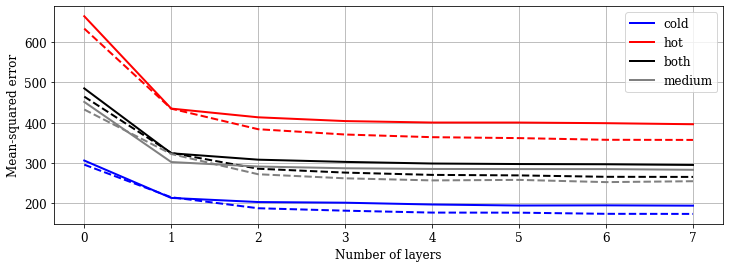

In [126]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    plt.plot(CItest[key]['plot'],label=key,color=color_array[ikey])
    plt.plot(BFtest[key]['plot'],linestyle='--',color=color_array[ikey])
    ikey += 1
    
plt.legend()
plt.grid()
plt.xlabel('Number of layers')
plt.ylabel('Mean-squared error')

# Small data experiments

## Overall parameters

In [21]:
N_batch = 8 # Number of batches for each experiment
Nep = 100
N_NN = 10 # Number of NN trained per experiment
N_layer = 7 # Number of layers for the NNs
batch_size_array = 2**np.arange(0,14) # Batch sizes we will consider in these experiments
N_samples = BFgen['both']['train'].n_samples # Total number of samples in the dataset
ptrain = path_array['both'][0]

## Design generators

In [22]:
BFgenSD = {}
CIgenSD = {}

In [23]:
for isize,batch_size in enumerate(batch_size_array):
    BFgenSD[batch_size] = {}
    CIgenSD[batch_size] = {}
    N_batch_max = int(N_samples/batch_size)
    print('batch_size=',batch_size,'& N_batch_max=',N_batch_max)
    
    for iexp in range(N_NN):
        BFgenSD[batch_size][iexp] = {}
        CIgenSD[batch_size][iexp] = {}
        # Randomly select 8 batches
        b_random = np.random.choice(np.linspace(0,N_batch_max-1,N_batch_max),
                                    size=((N_batch,)),
                                    replace=False).astype('int')
        print('Exp#',str(iexp),'b_random=',b_random)
        
        BFgenSD[batch_size][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:4],batch_size=batch_size,rescaling=None)
        BFgenSD[batch_size][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[4:],batch_size=batch_size,rescaling=None)
        
        CIgenSD[batch_size][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:4],batch_size=batch_size,rescaling='CI')
        CIgenSD[batch_size][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[4:],batch_size=batch_size,rescaling='CI')

batch_size= 1 & N_batch_max= 94355456
Exp# 0 b_random= [22017646 45404265 74825716  9208513 56955719 60812263 53901746 49693703]
Exp# 1 b_random= [25426809 38381940 31597074 83696034 82606077 10633239 35593039 24040530]
Exp# 2 b_random= [ 6294799 80030171 85237311 41193377 51903544 74595329 55097070 58043345]
Exp# 3 b_random= [ 9276268 23579460 36910748 58149691 71970352 65940728 79928501 46395270]
Exp# 4 b_random= [73526470 29789417 21851177 71253287 13141445 22962706 84316617 40777823]
Exp# 5 b_random= [84534241 11307939 91602762 47449583 14423454 31253035 79729219 85416630]
Exp# 6 b_random= [40910782 19265862 54445911 69703391 53365375 87589310 20617393  3099984]
Exp# 7 b_random= [35453669 39540267 36924949 75408004 50550864 67908773 55361632 43226230]
Exp# 8 b_random= [31123110 52588916 23598545 34501428 48618115  7704918 65644937 61076230]
Exp# 9 b_random= [29008219 33159686 29868391 70516161 17309696 29313179 35215866 64272084]
batch_size= 2 & N_batch_max= 47177728
Exp# 0 b_rando

Exp# 3 b_random= [ 83640  73788 152312  60392  58556 162234 171056  36524]
Exp# 4 b_random= [180624   7622  69218 114982  61152  96278  66275 177018]
Exp# 5 b_random= [147713 171785  24625 168744 107648  55111  73960  24686]
Exp# 6 b_random= [ 14650 140644 114311  38955  26587  89387  29156   8947]
Exp# 7 b_random= [  5321   2732  90674  29721  36694 154423 174939 138491]
Exp# 8 b_random= [132777   9911 180940 150002  49801 118832 115212  25520]
Exp# 9 b_random= [ 54692  72535 162352  70253 100396 102711 157256  60774]
batch_size= 1024 & N_batch_max= 92144
Exp# 0 b_random= [50196  9979 83090 88295 54933 50476 90466 91712]
Exp# 1 b_random= [81759  8726 34887 34702 32037 35440 28906 84500]
Exp# 2 b_random= [74835 70331 46783 61308 78138 58507 56700 65846]
Exp# 3 b_random= [35846 32988 50212 73310 32317 26847 83729 68166]
Exp# 4 b_random= [66985  9672 14641  9961   699 29218 52029 13676]
Exp# 5 b_random= [57115 65326 82270 18697 91253 11555 29446 10314]
Exp# 6 b_random= [ 9442 56410 91462

## Train models

In [24]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')

In [25]:
# Inputs
inpBFSD = {}
inpCISD = {}
# Model
NNBFSD = {}
NNCISD = {}
# History
hisBF = {}
hisCI = {}

In [26]:
for isize,batch_size in enumerate(batch_size_array):
    inpBFSD[batch_size] = {}
    inpCISD[batch_size] = {}
    NNBFSD[batch_size] = {}
    NNCISD[batch_size] = {}
    hisBF[batch_size] = {}
    hisCI[batch_size] = {}
    for iexp in range(N_NN):
        print('batch_size=',batch_size,'& iexp=',iexp)
        # Model definition
        inpBFSD[batch_size][iexp] = Input(shape=(64,))
        inpCISD[batch_size][iexp] = Input(shape=(64,))
        NNBFSD[batch_size][iexp] = NN_model(inpBFSD[batch_size][iexp],N_layer)
        NNCISD[batch_size][iexp] = NN_model(inpCISD[batch_size][iexp],N_layer)
        NNBFSD[batch_size][iexp].compile(tf.keras.optimizers.Adam(), loss=mse)
        NNCISD[batch_size][iexp].compile(tf.keras.optimizers.Adam(), loss=mse)
        # Model callbacks
        path_BF = path_data + 'HDF5_DATA/2022_05_16_BF_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
        path_CI = path_data + 'HDF5_DATA/2022_05_16_CI_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
        mcp_BF = ModelCheckpoint(path_BF,save_best_only=True, monitor='val_loss', mode='min')
        mcp_CI = ModelCheckpoint(path_CI,save_best_only=True, monitor='val_loss', mode='min')
        # Model training
        hisBF[batch_size][iexp] = NNBFSD[batch_size][iexp].fit_generator(
            BFgenSD[batch_size][iexp]['train'],epochs=Nep,
            validation_data = BFgenSD[batch_size][iexp]['valid'],
            callbacks=[mcp_BF,earlyStopping])
        hisCI[batch_size][iexp] = NNCISD[batch_size][iexp].fit_generator(
            CIgenSD[batch_size][iexp]['train'],epochs=Nep,
            validation_data = CIgenSD[batch_size][iexp]['valid'],
            callbacks=[mcp_CI,earlyStopping])

batch_size= 1 & iexp= 0
Epoch 1/100
4/4 [==============================] - 1s 188ms/step - loss: 105.0283 - val_loss: 363.2904
Epoch 2/100
4/4 [==============================] - 0s 63ms/step - loss: 104.4207 - val_loss: 363.0885
Epoch 3/100
4/4 [==============================] - 0s 62ms/step - loss: 103.1710 - val_loss: 362.4273
Epoch 4/100
4/4 [==============================] - 0s 65ms/step - loss: 100.1426 - val_loss: 360.6380
Epoch 5/100
4/4 [==============================] - 0s 62ms/step - loss: 92.9752 - val_loss: 357.2616
Epoch 6/100
4/4 [==============================] - 0s 64ms/step - loss: 83.8321 - val_loss: 353.5154
Epoch 7/100
4/4 [==============================] - 0s 62ms/step - loss: 73.3464 - val_loss: 347.7446
Epoch 8/100
4/4 [==============================] - 0s 64ms/step - loss: 58.7791 - val_loss: 341.4927
Epoch 9/100
4/4 [==============================] - 0s 62ms/step - loss: 43.0022 - val_loss: 338.7067
Epoch 10/100
4/4 [==============================] - 0s 64ms/st

Epoch 11/100
4/4 [==============================] - 0s 46ms/step - loss: 119.3249 - val_loss: 264.0477
Epoch 12/100
4/4 [==============================] - 0s 48ms/step - loss: 117.3093 - val_loss: 267.0703
Epoch 13/100
4/4 [==============================] - 0s 47ms/step - loss: 114.5029 - val_loss: 262.4724
Epoch 14/100
4/4 [==============================] - 0s 45ms/step - loss: 113.8753 - val_loss: 262.4863
Epoch 15/100
4/4 [==============================] - 0s 47ms/step - loss: 113.6692 - val_loss: 266.8087
Epoch 16/100
4/4 [==============================] - 0s 45ms/step - loss: 111.0289 - val_loss: 272.8531
Epoch 17/100
4/4 [==============================] - 0s 48ms/step - loss: 111.9742 - val_loss: 268.4440
Epoch 18/100
4/4 [==============================] - 0s 50ms/step - loss: 109.1852 - val_loss: 265.5389
Epoch 19/100
4/4 [==============================] - 0s 50ms/step - loss: 108.3632 - val_loss: 269.5807
Epoch 20/100
4/4 [==============================] - 0s 50ms/step - loss: 

4/4 [==============================] - 0s 54ms/step - loss: 32.3413 - val_loss: 187.2676
Epoch 11/100
4/4 [==============================] - 0s 46ms/step - loss: 35.8630 - val_loss: 203.7979
Epoch 12/100
4/4 [==============================] - 0s 51ms/step - loss: 23.1732 - val_loss: 333.8847
Epoch 13/100
4/4 [==============================] - 0s 51ms/step - loss: 42.2547 - val_loss: 276.3848
Epoch 14/100
4/4 [==============================] - 0s 51ms/step - loss: 17.6997 - val_loss: 160.2257
Epoch 15/100
4/4 [==============================] - 0s 50ms/step - loss: 45.2432 - val_loss: 178.0457
Epoch 16/100
4/4 [==============================] - 0s 50ms/step - loss: 29.5280 - val_loss: 258.0122
Epoch 17/100
4/4 [==============================] - 0s 51ms/step - loss: 15.9525 - val_loss: 337.7261
Epoch 18/100
4/4 [==============================] - 0s 50ms/step - loss: 26.1723 - val_loss: 227.1961
Epoch 19/100
4/4 [==============================] - 0s 51ms/step - loss: 15.0674 - val_loss: 19

Epoch 3/100
4/4 [==============================] - 0s 63ms/step - loss: 98.7580 - val_loss: 384.6771
Epoch 4/100
4/4 [==============================] - 0s 63ms/step - loss: 95.3542 - val_loss: 384.0447
Epoch 5/100
4/4 [==============================] - 0s 45ms/step - loss: 87.0182 - val_loss: 388.6587
Epoch 6/100
4/4 [==============================] - 0s 47ms/step - loss: 74.3045 - val_loss: 422.2429
Epoch 7/100
4/4 [==============================] - 0s 45ms/step - loss: 76.8515 - val_loss: 422.2231
Epoch 8/100
4/4 [==============================] - 0s 47ms/step - loss: 68.2738 - val_loss: 396.4880
Epoch 9/100
4/4 [==============================] - 0s 46ms/step - loss: 66.4984 - val_loss: 396.9809
Epoch 10/100
4/4 [==============================] - 0s 46ms/step - loss: 63.6534 - val_loss: 411.7265
Epoch 11/100
4/4 [==============================] - 0s 46ms/step - loss: 60.1900 - val_loss: 436.2033
Epoch 12/100
4/4 [==============================] - 0s 48ms/step - loss: 58.9586 - val_lo

Epoch 30/100
4/4 [==============================] - 0s 51ms/step - loss: 0.6742 - val_loss: 395.0830
Epoch 31/100
4/4 [==============================] - 0s 50ms/step - loss: 0.8676 - val_loss: 396.6086
Epoch 32/100
4/4 [==============================] - 0s 50ms/step - loss: 1.0513 - val_loss: 394.3130
Epoch 33/100
4/4 [==============================] - 0s 50ms/step - loss: 1.0769 - val_loss: 398.1236
Epoch 34/100
4/4 [==============================] - 0s 49ms/step - loss: 1.3232 - val_loss: 392.9008
Epoch 35/100
4/4 [==============================] - 0s 50ms/step - loss: 1.8703 - val_loss: 394.1409
Epoch 36/100
4/4 [==============================] - 0s 52ms/step - loss: 0.9493 - val_loss: 396.6410
Epoch 37/100
4/4 [==============================] - 0s 47ms/step - loss: 0.4802 - val_loss: 394.3141
Epoch 38/100
4/4 [==============================] - 0s 53ms/step - loss: 1.4375 - val_loss: 392.3054
Epoch 39/100
4/4 [==============================] - 0s 48ms/step - loss: 1.0678 - val_loss:

4/4 [==============================] - 0s 46ms/step - loss: 34.4556 - val_loss: 1498.4286
Epoch 29/100
4/4 [==============================] - 0s 46ms/step - loss: 32.7095 - val_loss: 1519.3695
Epoch 30/100
4/4 [==============================] - 0s 51ms/step - loss: 27.4799 - val_loss: 1538.3945
Epoch 31/100
4/4 [==============================] - 0s 47ms/step - loss: 20.6523 - val_loss: 1553.3309
Epoch 32/100
4/4 [==============================] - 0s 45ms/step - loss: 18.5439 - val_loss: 1563.0560
Epoch 33/100
4/4 [==============================] - 0s 46ms/step - loss: 14.3179 - val_loss: 1581.3945
Epoch 34/100
4/4 [==============================] - 0s 46ms/step - loss: 12.8190 - val_loss: 1587.5674
Epoch 35/100
4/4 [==============================] - 0s 46ms/step - loss: 10.0228 - val_loss: 1582.8531
Epoch 36/100
4/4 [==============================] - 0s 46ms/step - loss: 9.3581 - val_loss: 1592.9125
Epoch 37/100
4/4 [==============================] - 0s 49ms/step - loss: 7.9449 - val_l

4/4 [==============================] - 0s 63ms/step - loss: 39.7841 - val_loss: 85.8102
Epoch 6/100
4/4 [==============================] - 0s 62ms/step - loss: 38.1819 - val_loss: 81.9600
Epoch 7/100
4/4 [==============================] - 0s 63ms/step - loss: 32.9333 - val_loss: 80.0052
Epoch 8/100
4/4 [==============================] - 0s 62ms/step - loss: 29.2345 - val_loss: 76.9368
Epoch 9/100
4/4 [==============================] - 0s 62ms/step - loss: 27.7414 - val_loss: 71.8748
Epoch 10/100
4/4 [==============================] - 0s 63ms/step - loss: 23.5547 - val_loss: 70.2192
Epoch 11/100
4/4 [==============================] - 0s 51ms/step - loss: 21.9239 - val_loss: 71.7571
Epoch 12/100
4/4 [==============================] - 0s 45ms/step - loss: 18.6197 - val_loss: 74.2275
Epoch 13/100
4/4 [==============================] - 0s 46ms/step - loss: 17.1641 - val_loss: 76.1637
Epoch 14/100
4/4 [==============================] - 0s 45ms/step - loss: 15.5337 - val_loss: 77.7766
Epoch 1

Epoch 27/100
4/4 [==============================] - 0s 50ms/step - loss: 0.7189 - val_loss: 121.5533
Epoch 28/100
4/4 [==============================] - 0s 47ms/step - loss: 0.7939 - val_loss: 118.8833
Epoch 29/100
4/4 [==============================] - 0s 47ms/step - loss: 0.5557 - val_loss: 119.3130
Epoch 30/100
4/4 [==============================] - 0s 46ms/step - loss: 0.4570 - val_loss: 121.5784
Epoch 31/100
4/4 [==============================] - 0s 46ms/step - loss: 0.4610 - val_loss: 115.7955
Epoch 32/100
4/4 [==============================] - 0s 46ms/step - loss: 0.4655 - val_loss: 123.0804
Epoch 33/100
4/4 [==============================] - 0s 46ms/step - loss: 0.7005 - val_loss: 117.0451
Epoch 34/100
4/4 [==============================] - 0s 50ms/step - loss: 0.6827 - val_loss: 113.8541
Epoch 35/100
4/4 [==============================] - 0s 51ms/step - loss: 1.1625 - val_loss: 143.7212
Epoch 36/100
4/4 [==============================] - 0s 50ms/step - loss: 2.7595 - val_loss:

4/4 [==============================] - 0s 52ms/step - loss: 7.6374 - val_loss: 497.5462
Epoch 34/100
4/4 [==============================] - 0s 45ms/step - loss: 6.1579 - val_loss: 518.6079
Epoch 35/100
4/4 [==============================] - 0s 46ms/step - loss: 5.8397 - val_loss: 501.8209
Epoch 36/100
4/4 [==============================] - 0s 46ms/step - loss: 6.1988 - val_loss: 507.0981
Epoch 37/100
4/4 [==============================] - 0s 46ms/step - loss: 5.9543 - val_loss: 505.9781
Epoch 38/100
4/4 [==============================] - 0s 47ms/step - loss: 4.8318 - val_loss: 506.2326
Epoch 39/100
4/4 [==============================] - 0s 46ms/step - loss: 5.7838 - val_loss: 507.2124
Epoch 40/100
4/4 [==============================] - 0s 50ms/step - loss: 4.5585 - val_loss: 504.7888
Epoch 41/100
4/4 [==============================] - 0s 52ms/step - loss: 4.4916 - val_loss: 505.1687
Epoch 42/100
4/4 [==============================] - 0s 51ms/step - loss: 4.8779 - val_loss: 505.2533
Epo

4/4 [==============================] - 0s 51ms/step - loss: 144.3129 - val_loss: 349.1901
Epoch 37/100
4/4 [==============================] - 0s 52ms/step - loss: 141.3131 - val_loss: 342.3302
Epoch 38/100
4/4 [==============================] - 0s 50ms/step - loss: 135.9527 - val_loss: 345.9700
Epoch 39/100
4/4 [==============================] - 0s 51ms/step - loss: 130.8662 - val_loss: 348.7075
Epoch 40/100
4/4 [==============================] - 0s 49ms/step - loss: 124.6405 - val_loss: 340.3822
Epoch 41/100
4/4 [==============================] - 0s 52ms/step - loss: 117.6552 - val_loss: 379.1554
Epoch 42/100
4/4 [==============================] - 0s 50ms/step - loss: 125.1288 - val_loss: 326.6773
Epoch 43/100
4/4 [==============================] - 0s 50ms/step - loss: 117.9039 - val_loss: 290.7752
Epoch 44/100
4/4 [==============================] - 0s 50ms/step - loss: 128.1753 - val_loss: 291.8013
Epoch 45/100
4/4 [==============================] - 0s 51ms/step - loss: 84.0395 - val

Epoch 31/100
4/4 [==============================] - 0s 51ms/step - loss: 4.0484 - val_loss: 559.7331
Epoch 32/100
4/4 [==============================] - 0s 53ms/step - loss: 5.2609 - val_loss: 563.4637
Epoch 33/100
4/4 [==============================] - 0s 48ms/step - loss: 4.3333 - val_loss: 564.4358
Epoch 34/100
4/4 [==============================] - 0s 53ms/step - loss: 5.4672 - val_loss: 563.1594
Epoch 35/100
4/4 [==============================] - 0s 47ms/step - loss: 4.0048 - val_loss: 558.1557
Epoch 36/100
4/4 [==============================] - 0s 53ms/step - loss: 3.7248 - val_loss: 562.4545
Epoch 37/100
4/4 [==============================] - 0s 47ms/step - loss: 2.7770 - val_loss: 561.5230
Epoch 38/100
4/4 [==============================] - 0s 53ms/step - loss: 2.9905 - val_loss: 560.6124
Epoch 39/100
4/4 [==============================] - 0s 49ms/step - loss: 2.8716 - val_loss: 563.9008
Epoch 40/100
4/4 [==============================] - 0s 48ms/step - loss: 2.0737 - val_loss:

Epoch 1/100
4/4 [==============================] - 0s 97ms/step - loss: 277.0823 - val_loss: 467.6909
Epoch 2/100
4/4 [==============================] - 0s 48ms/step - loss: 247.9843 - val_loss: 470.4018
Epoch 3/100
4/4 [==============================] - 0s 49ms/step - loss: 233.1141 - val_loss: 478.3761
Epoch 4/100
4/4 [==============================] - 0s 48ms/step - loss: 222.2710 - val_loss: 483.2750
Epoch 5/100
4/4 [==============================] - 0s 49ms/step - loss: 204.5979 - val_loss: 494.5453
Epoch 6/100
4/4 [==============================] - 0s 50ms/step - loss: 190.0462 - val_loss: 498.3063
Epoch 7/100
4/4 [==============================] - 0s 50ms/step - loss: 178.7459 - val_loss: 507.6904
Epoch 8/100
4/4 [==============================] - 0s 48ms/step - loss: 166.2498 - val_loss: 507.1129
Epoch 9/100
4/4 [==============================] - 0s 51ms/step - loss: 157.2815 - val_loss: 495.1447
Epoch 10/100
4/4 [==============================] - 0s 51ms/step - loss: 147.3225 

Epoch 30/100
4/4 [==============================] - 0s 46ms/step - loss: 48.5078 - val_loss: 174.8534
Epoch 31/100
4/4 [==============================] - 0s 46ms/step - loss: 43.5955 - val_loss: 175.6676
Epoch 32/100
4/4 [==============================] - 0s 46ms/step - loss: 46.6818 - val_loss: 177.4382
Epoch 33/100
4/4 [==============================] - 0s 48ms/step - loss: 43.0354 - val_loss: 180.4515
Epoch 34/100
4/4 [==============================] - 0s 45ms/step - loss: 46.0707 - val_loss: 179.1859
Epoch 35/100
4/4 [==============================] - 0s 46ms/step - loss: 40.7030 - val_loss: 176.1063
Epoch 36/100
4/4 [==============================] - 0s 45ms/step - loss: 46.1626 - val_loss: 173.5213
Epoch 37/100
4/4 [==============================] - 0s 47ms/step - loss: 40.8901 - val_loss: 175.6846
Epoch 38/100
4/4 [==============================] - 0s 48ms/step - loss: 40.3749 - val_loss: 178.8305
Epoch 39/100
4/4 [==============================] - 0s 48ms/step - loss: 42.8959 -

4/4 [==============================] - 0s 51ms/step - loss: 18.7081 - val_loss: 610.2373
Epoch 28/100
4/4 [==============================] - 0s 50ms/step - loss: 18.1022 - val_loss: 588.0060
Epoch 29/100
4/4 [==============================] - 0s 50ms/step - loss: 11.5723 - val_loss: 561.8359
Epoch 30/100
4/4 [==============================] - 0s 50ms/step - loss: 10.3184 - val_loss: 626.6800
Epoch 31/100
4/4 [==============================] - 0s 51ms/step - loss: 14.7203 - val_loss: 593.8093
Epoch 32/100
4/4 [==============================] - 0s 52ms/step - loss: 17.5018 - val_loss: 556.8742
Epoch 33/100
4/4 [==============================] - 0s 45ms/step - loss: 9.5273 - val_loss: 637.2696
Epoch 34/100
4/4 [==============================] - 0s 46ms/step - loss: 8.5024 - val_loss: 617.6282
Epoch 35/100
4/4 [==============================] - 0s 46ms/step - loss: 10.5136 - val_loss: 566.4582
Epoch 36/100
4/4 [==============================] - 0s 46ms/step - loss: 12.9231 - val_loss: 605.

Epoch 4/100
4/4 [==============================] - 0s 66ms/step - loss: 203.6384 - val_loss: 675.7902
Epoch 5/100
4/4 [==============================] - 0s 46ms/step - loss: 184.6908 - val_loss: 684.3833
Epoch 6/100
4/4 [==============================] - 0s 46ms/step - loss: 166.3886 - val_loss: 694.2467
Epoch 7/100
4/4 [==============================] - 0s 46ms/step - loss: 143.7792 - val_loss: 696.6030
Epoch 8/100
4/4 [==============================] - 0s 46ms/step - loss: 124.4025 - val_loss: 719.7097
Epoch 9/100
4/4 [==============================] - 0s 45ms/step - loss: 108.5328 - val_loss: 733.4979
Epoch 10/100
4/4 [==============================] - 0s 45ms/step - loss: 90.5320 - val_loss: 741.1046
Epoch 11/100
4/4 [==============================] - 0s 47ms/step - loss: 82.0305 - val_loss: 746.3696
Epoch 12/100
4/4 [==============================] - 0s 46ms/step - loss: 69.0043 - val_loss: 766.5497
Epoch 13/100
4/4 [==============================] - 0s 46ms/step - loss: 58.4752 -

4/4 [==============================] - 0s 51ms/step - loss: 3.1437 - val_loss: 606.3917
Epoch 54/100
4/4 [==============================] - 0s 47ms/step - loss: 3.0181 - val_loss: 607.4830
Epoch 55/100
4/4 [==============================] - 0s 51ms/step - loss: 3.0324 - val_loss: 607.4631
Epoch 56/100
4/4 [==============================] - 0s 54ms/step - loss: 2.8651 - val_loss: 606.9184
Epoch 57/100
4/4 [==============================] - 0s 46ms/step - loss: 2.7741 - val_loss: 607.9062
Epoch 58/100
4/4 [==============================] - 0s 51ms/step - loss: 2.7269 - val_loss: 606.8224
Epoch 59/100
4/4 [==============================] - 0s 50ms/step - loss: 2.5880 - val_loss: 607.4237
Epoch 60/100
4/4 [==============================] - 0s 49ms/step - loss: 2.4933 - val_loss: 608.2517
Epoch 61/100
4/4 [==============================] - 0s 46ms/step - loss: 2.4109 - val_loss: 607.4217
Epoch 62/100
4/4 [==============================] - 0s 45ms/step - loss: 2.2644 - val_loss: 608.7534
bat

Epoch 14/100
4/4 [==============================] - 0s 52ms/step - loss: 109.0654 - val_loss: 1028.5025
Epoch 15/100
4/4 [==============================] - 0s 50ms/step - loss: 95.7734 - val_loss: 921.3867
Epoch 16/100
4/4 [==============================] - 0s 49ms/step - loss: 84.2952 - val_loss: 963.0149
Epoch 17/100
4/4 [==============================] - 0s 50ms/step - loss: 80.7525 - val_loss: 1007.8022
Epoch 18/100
4/4 [==============================] - 0s 50ms/step - loss: 71.6997 - val_loss: 825.0145
Epoch 19/100
4/4 [==============================] - 0s 50ms/step - loss: 122.3221 - val_loss: 907.8583
Epoch 20/100
4/4 [==============================] - 0s 45ms/step - loss: 73.3675 - val_loss: 1270.8068
Epoch 21/100
4/4 [==============================] - 0s 45ms/step - loss: 68.6543 - val_loss: 868.2553
Epoch 22/100
4/4 [==============================] - 0s 48ms/step - loss: 124.3511 - val_loss: 1034.9324
Epoch 23/100
4/4 [==============================] - 0s 50ms/step - loss: 61

4/4 [==============================] - 0s 47ms/step - loss: 39.9338 - val_loss: 767.0332
Epoch 23/100
4/4 [==============================] - 0s 43ms/step - loss: 34.7299 - val_loss: 750.4248
Epoch 24/100
4/4 [==============================] - 0s 42ms/step - loss: 30.0507 - val_loss: 706.9211
Epoch 25/100
4/4 [==============================] - 0s 48ms/step - loss: 28.1846 - val_loss: 776.3018
Epoch 26/100
4/4 [==============================] - 0s 46ms/step - loss: 25.9017 - val_loss: 757.0323
Epoch 27/100
4/4 [==============================] - 0s 46ms/step - loss: 20.8537 - val_loss: 728.8325
Epoch 28/100
4/4 [==============================] - 0s 46ms/step - loss: 19.0407 - val_loss: 754.0152
Epoch 29/100
4/4 [==============================] - 0s 45ms/step - loss: 17.8661 - val_loss: 813.0245
Epoch 30/100
4/4 [==============================] - 0s 45ms/step - loss: 16.0793 - val_loss: 728.1065
Epoch 31/100
4/4 [==============================] - 0s 51ms/step - loss: 13.6650 - val_loss: 74

4/4 [==============================] - 0s 48ms/step - loss: 141.0807 - val_loss: 416.8267
Epoch 27/100
4/4 [==============================] - 0s 47ms/step - loss: 132.7232 - val_loss: 445.1520
Epoch 28/100
4/4 [==============================] - 0s 47ms/step - loss: 130.0912 - val_loss: 438.2974
Epoch 29/100
4/4 [==============================] - 0s 48ms/step - loss: 122.1204 - val_loss: 420.9953
Epoch 30/100
4/4 [==============================] - 0s 49ms/step - loss: 123.0983 - val_loss: 417.2046
Epoch 31/100
4/4 [==============================] - 0s 51ms/step - loss: 118.9492 - val_loss: 436.6945
Epoch 32/100
4/4 [==============================] - 0s 49ms/step - loss: 117.8524 - val_loss: 449.5722
Epoch 33/100
4/4 [==============================] - 0s 50ms/step - loss: 115.7675 - val_loss: 437.0228
Epoch 34/100
4/4 [==============================] - 0s 50ms/step - loss: 113.8350 - val_loss: 430.7808
Epoch 35/100
4/4 [==============================] - 0s 51ms/step - loss: 112.9798 - va

4/4 [==============================] - 0s 48ms/step - loss: 118.5868 - val_loss: 225.7509
Epoch 22/100
4/4 [==============================] - 0s 49ms/step - loss: 114.4435 - val_loss: 280.1201
Epoch 23/100
4/4 [==============================] - 0s 48ms/step - loss: 97.7154 - val_loss: 250.7887
Epoch 24/100
4/4 [==============================] - 0s 52ms/step - loss: 114.9498 - val_loss: 244.2935
Epoch 25/100
4/4 [==============================] - 0s 48ms/step - loss: 86.6313 - val_loss: 245.1725
Epoch 26/100
4/4 [==============================] - 0s 53ms/step - loss: 73.8795 - val_loss: 241.5814
Epoch 27/100
4/4 [==============================] - 0s 50ms/step - loss: 66.2188 - val_loss: 274.5392
Epoch 28/100
4/4 [==============================] - 0s 53ms/step - loss: 57.8757 - val_loss: 245.4481
Epoch 29/100
4/4 [==============================] - 0s 48ms/step - loss: 52.3980 - val_loss: 257.4502
Epoch 30/100
4/4 [==============================] - 0s 48ms/step - loss: 47.4255 - val_loss:

4/4 [==============================] - 0s 48ms/step - loss: 191.3806 - val_loss: 315.8236
Epoch 36/100
4/4 [==============================] - 0s 47ms/step - loss: 176.4302 - val_loss: 326.2901
Epoch 37/100
4/4 [==============================] - 0s 49ms/step - loss: 183.8234 - val_loss: 331.4695
Epoch 38/100
4/4 [==============================] - 0s 48ms/step - loss: 169.9059 - val_loss: 326.6282
Epoch 39/100
4/4 [==============================] - 0s 48ms/step - loss: 168.8263 - val_loss: 324.7723
Epoch 40/100
4/4 [==============================] - 0s 48ms/step - loss: 168.5071 - val_loss: 328.8719
Epoch 41/100
4/4 [==============================] - 0s 49ms/step - loss: 164.5541 - val_loss: 334.5810
Epoch 42/100
4/4 [==============================] - 0s 48ms/step - loss: 163.2425 - val_loss: 333.5362
Epoch 43/100
4/4 [==============================] - 0s 48ms/step - loss: 161.1557 - val_loss: 332.3808
Epoch 44/100
4/4 [==============================] - 0s 51ms/step - loss: 161.4161 - va

Epoch 37/100
4/4 [==============================] - 0s 50ms/step - loss: 52.2774 - val_loss: 386.3005
Epoch 38/100
4/4 [==============================] - 0s 50ms/step - loss: 52.1024 - val_loss: 383.2045
Epoch 39/100
4/4 [==============================] - 0s 50ms/step - loss: 45.9349 - val_loss: 392.1913
Epoch 40/100
4/4 [==============================] - 0s 51ms/step - loss: 43.6188 - val_loss: 389.6050
Epoch 41/100
4/4 [==============================] - 0s 50ms/step - loss: 37.7344 - val_loss: 394.4652
Epoch 42/100
4/4 [==============================] - 0s 51ms/step - loss: 34.3255 - val_loss: 399.2765
Epoch 43/100
4/4 [==============================] - 0s 50ms/step - loss: 31.8312 - val_loss: 403.3308
Epoch 44/100
4/4 [==============================] - 0s 51ms/step - loss: 27.8982 - val_loss: 411.7330
Epoch 45/100
4/4 [==============================] - 0s 50ms/step - loss: 24.6403 - val_loss: 413.7296
Epoch 46/100
4/4 [==============================] - 0s 50ms/step - loss: 22.5822 -

Epoch 39/100
4/4 [==============================] - 0s 46ms/step - loss: 59.4392 - val_loss: 309.1095
Epoch 40/100
4/4 [==============================] - 0s 46ms/step - loss: 57.9242 - val_loss: 306.1367
Epoch 41/100
4/4 [==============================] - 0s 47ms/step - loss: 55.1339 - val_loss: 298.3360
Epoch 42/100
4/4 [==============================] - 0s 48ms/step - loss: 54.4511 - val_loss: 315.5645
Epoch 43/100
4/4 [==============================] - 0s 47ms/step - loss: 57.0274 - val_loss: 304.5675
Epoch 44/100
4/4 [==============================] - 0s 47ms/step - loss: 56.6670 - val_loss: 290.1631
Epoch 45/100
4/4 [==============================] - 0s 49ms/step - loss: 51.9560 - val_loss: 324.6069
Epoch 46/100
4/4 [==============================] - 0s 50ms/step - loss: 57.5141 - val_loss: 295.1602
Epoch 47/100
4/4 [==============================] - 0s 48ms/step - loss: 52.2417 - val_loss: 300.5008
Epoch 48/100
4/4 [==============================] - 0s 47ms/step - loss: 51.2131 -

4/4 [==============================] - 0s 49ms/step - loss: 339.7289 - val_loss: 1225.0422
Epoch 12/100
4/4 [==============================] - 0s 48ms/step - loss: 338.1956 - val_loss: 1225.4405
Epoch 13/100
4/4 [==============================] - 0s 47ms/step - loss: 337.1961 - val_loss: 1229.1216
Epoch 14/100
4/4 [==============================] - 0s 48ms/step - loss: 335.6580 - val_loss: 1246.6229
Epoch 15/100
4/4 [==============================] - 0s 48ms/step - loss: 335.9304 - val_loss: 1253.1762
Epoch 16/100
4/4 [==============================] - 0s 48ms/step - loss: 332.6450 - val_loss: 1238.7609
Epoch 17/100
4/4 [==============================] - 0s 49ms/step - loss: 332.1027 - val_loss: 1246.0009
Epoch 18/100
4/4 [==============================] - 0s 47ms/step - loss: 331.5613 - val_loss: 1263.9995
Epoch 19/100
4/4 [==============================] - 0s 48ms/step - loss: 329.2530 - val_loss: 1259.4396
Epoch 20/100
4/4 [==============================] - 0s 49ms/step - loss: 327.

4/4 [==============================] - 0s 47ms/step - loss: 23.6813 - val_loss: 883.9564
Epoch 55/100
4/4 [==============================] - 0s 48ms/step - loss: 23.5403 - val_loss: 884.6615
Epoch 56/100
4/4 [==============================] - 0s 46ms/step - loss: 23.3457 - val_loss: 885.1840
Epoch 57/100
4/4 [==============================] - 0s 46ms/step - loss: 23.1147 - val_loss: 884.5199
Epoch 58/100
4/4 [==============================] - 0s 48ms/step - loss: 22.9240 - val_loss: 885.1749
Epoch 59/100
4/4 [==============================] - 0s 46ms/step - loss: 22.6323 - val_loss: 885.5756
Epoch 60/100
4/4 [==============================] - 0s 48ms/step - loss: 22.3163 - val_loss: 885.9659
Epoch 61/100
4/4 [==============================] - 0s 47ms/step - loss: 22.0368 - val_loss: 886.4220
Epoch 62/100
4/4 [==============================] - 0s 47ms/step - loss: 21.8052 - val_loss: 887.1757
Epoch 63/100
4/4 [==============================] - 0s 50ms/step - loss: 21.4809 - val_loss: 88

4/4 [==============================] - 0s 52ms/step - loss: 141.5963 - val_loss: 4740.0241
Epoch 35/100
4/4 [==============================] - 0s 49ms/step - loss: 185.8460 - val_loss: 5233.2015
Epoch 36/100
4/4 [==============================] - 0s 51ms/step - loss: 145.8646 - val_loss: 5246.2033
Epoch 37/100
4/4 [==============================] - 0s 47ms/step - loss: 166.4354 - val_loss: 5156.8913
Epoch 38/100
4/4 [==============================] - 0s 52ms/step - loss: 132.0257 - val_loss: 4360.7985
Epoch 39/100
4/4 [==============================] - 0s 48ms/step - loss: 167.1158 - val_loss: 4486.4718
Epoch 40/100
4/4 [==============================] - 0s 51ms/step - loss: 184.4434 - val_loss: 4926.3928
Epoch 41/100
4/4 [==============================] - 0s 52ms/step - loss: 202.3535 - val_loss: 4333.3482
Epoch 42/100
4/4 [==============================] - 0s 48ms/step - loss: 179.2672 - val_loss: 4551.8855
Epoch 43/100
4/4 [==============================] - 0s 54ms/step - loss: 224.

Epoch 8/100
4/4 [==============================] - 0s 47ms/step - loss: 135.0271 - val_loss: 140.6387
Epoch 9/100
4/4 [==============================] - 0s 52ms/step - loss: 119.8432 - val_loss: 159.5967
Epoch 10/100
4/4 [==============================] - 0s 53ms/step - loss: 104.7012 - val_loss: 161.5400
Epoch 11/100
4/4 [==============================] - 0s 49ms/step - loss: 84.6728 - val_loss: 152.0503
Epoch 12/100
4/4 [==============================] - 0s 48ms/step - loss: 65.1627 - val_loss: 169.4619
Epoch 13/100
4/4 [==============================] - 0s 52ms/step - loss: 55.4474 - val_loss: 149.1564
Epoch 14/100
4/4 [==============================] - 0s 52ms/step - loss: 47.1122 - val_loss: 144.5072
Epoch 15/100
4/4 [==============================] - 0s 47ms/step - loss: 42.5963 - val_loss: 153.1653
Epoch 16/100
4/4 [==============================] - 0s 52ms/step - loss: 37.5177 - val_loss: 145.6155
Epoch 17/100
4/4 [==============================] - 0s 52ms/step - loss: 36.0365 

Epoch 35/100
4/4 [==============================] - 0s 48ms/step - loss: 179.9998 - val_loss: 209.9060
Epoch 36/100
4/4 [==============================] - 0s 47ms/step - loss: 168.6696 - val_loss: 219.7900
Epoch 37/100
4/4 [==============================] - 0s 46ms/step - loss: 200.3015 - val_loss: 218.1984
Epoch 38/100
4/4 [==============================] - 0s 47ms/step - loss: 134.8879 - val_loss: 213.9044
Epoch 39/100
4/4 [==============================] - 0s 44ms/step - loss: 145.0269 - val_loss: 219.8768
Epoch 40/100
4/4 [==============================] - 0s 47ms/step - loss: 160.9051 - val_loss: 223.0383
Epoch 41/100
4/4 [==============================] - 0s 47ms/step - loss: 137.3919 - val_loss: 222.5659
Epoch 42/100
4/4 [==============================] - 0s 47ms/step - loss: 128.3491 - val_loss: 237.1961
Epoch 43/100
4/4 [==============================] - 0s 47ms/step - loss: 133.2378 - val_loss: 235.3930
Epoch 44/100
4/4 [==============================] - 0s 50ms/step - loss: 

Epoch 35/100
4/4 [==============================] - 0s 51ms/step - loss: 32.9848 - val_loss: 401.5376
Epoch 36/100
4/4 [==============================] - 0s 52ms/step - loss: 31.8503 - val_loss: 406.6280
Epoch 37/100
4/4 [==============================] - 0s 46ms/step - loss: 28.2848 - val_loss: 415.5193
Epoch 38/100
4/4 [==============================] - 0s 49ms/step - loss: 24.0656 - val_loss: 397.2746
Epoch 39/100
4/4 [==============================] - 0s 48ms/step - loss: 21.8756 - val_loss: 433.4121
Epoch 40/100
4/4 [==============================] - 0s 46ms/step - loss: 20.1959 - val_loss: 388.3171
Epoch 41/100
4/4 [==============================] - 0s 47ms/step - loss: 19.3679 - val_loss: 434.9877
Epoch 42/100
4/4 [==============================] - 0s 46ms/step - loss: 18.5458 - val_loss: 398.9353
Epoch 43/100
4/4 [==============================] - 0s 47ms/step - loss: 16.7590 - val_loss: 415.8734
Epoch 44/100
4/4 [==============================] - 0s 52ms/step - loss: 16.3948 -

4/4 [==============================] - 0s 50ms/step - loss: 314.2463 - val_loss: 326.8432
Epoch 66/100
4/4 [==============================] - 0s 53ms/step - loss: 308.7697 - val_loss: 299.4474
Epoch 67/100
4/4 [==============================] - 0s 48ms/step - loss: 270.9795 - val_loss: 247.7713
Epoch 68/100
4/4 [==============================] - 0s 51ms/step - loss: 277.3545 - val_loss: 310.6809
Epoch 69/100
4/4 [==============================] - 0s 51ms/step - loss: 243.0639 - val_loss: 319.6155
Epoch 70/100
4/4 [==============================] - 0s 52ms/step - loss: 212.2619 - val_loss: 310.0407
Epoch 71/100
4/4 [==============================] - 0s 53ms/step - loss: 207.5213 - val_loss: 316.5573
Epoch 72/100
4/4 [==============================] - 0s 47ms/step - loss: 179.2804 - val_loss: 324.5427
batch_size= 8 & iexp= 1
Epoch 1/100
4/4 [==============================] - 1s 148ms/step - loss: 279.6063 - val_loss: 281.8039
Epoch 2/100
4/4 [==============================] - 0s 64ms/ste

Epoch 39/100
4/4 [==============================] - 0s 47ms/step - loss: 101.0958 - val_loss: 448.1714
Epoch 40/100
4/4 [==============================] - 0s 47ms/step - loss: 98.7236 - val_loss: 438.2862
Epoch 41/100
4/4 [==============================] - 0s 49ms/step - loss: 97.7744 - val_loss: 433.6697
Epoch 42/100
4/4 [==============================] - 0s 49ms/step - loss: 95.5473 - val_loss: 469.3591
Epoch 43/100
4/4 [==============================] - 0s 51ms/step - loss: 93.0127 - val_loss: 453.3120
Epoch 44/100
4/4 [==============================] - 0s 48ms/step - loss: 91.4866 - val_loss: 477.8210
Epoch 45/100
4/4 [==============================] - 0s 47ms/step - loss: 88.6164 - val_loss: 474.3921
Epoch 46/100
4/4 [==============================] - 0s 48ms/step - loss: 87.0217 - val_loss: 494.0978
Epoch 47/100
4/4 [==============================] - 0s 47ms/step - loss: 83.8844 - val_loss: 427.8734
Epoch 48/100
4/4 [==============================] - 0s 46ms/step - loss: 82.5531 

Epoch 8/100
4/4 [==============================] - 0s 47ms/step - loss: 445.7600 - val_loss: 327.2545
Epoch 9/100
4/4 [==============================] - 0s 47ms/step - loss: 446.3390 - val_loss: 322.2796
Epoch 10/100
4/4 [==============================] - 0s 47ms/step - loss: 442.1097 - val_loss: 322.1705
Epoch 11/100
4/4 [==============================] - 0s 49ms/step - loss: 443.4376 - val_loss: 328.9761
Epoch 12/100
4/4 [==============================] - 0s 48ms/step - loss: 436.9470 - val_loss: 332.0230
Epoch 13/100
4/4 [==============================] - 0s 49ms/step - loss: 434.2581 - val_loss: 330.3839
Epoch 14/100
4/4 [==============================] - 0s 50ms/step - loss: 433.0858 - val_loss: 332.1974
Epoch 15/100
4/4 [==============================] - 0s 47ms/step - loss: 431.7148 - val_loss: 329.8246
Epoch 16/100
4/4 [==============================] - 0s 50ms/step - loss: 431.3691 - val_loss: 327.6467
Epoch 17/100
4/4 [==============================] - 0s 46ms/step - loss: 42

4/4 [==============================] - 0s 45ms/step - loss: 214.4174 - val_loss: 1003.2209
Epoch 7/100
4/4 [==============================] - 0s 52ms/step - loss: 205.0327 - val_loss: 1004.5253
Epoch 8/100
4/4 [==============================] - 0s 48ms/step - loss: 198.0722 - val_loss: 1015.1522
Epoch 9/100
4/4 [==============================] - 0s 50ms/step - loss: 187.8151 - val_loss: 1029.3548
Epoch 10/100
4/4 [==============================] - 0s 51ms/step - loss: 182.7533 - val_loss: 1034.9035
Epoch 11/100
4/4 [==============================] - 0s 50ms/step - loss: 167.6419 - val_loss: 1040.7773
Epoch 12/100
4/4 [==============================] - 0s 51ms/step - loss: 160.4147 - val_loss: 1048.8205
Epoch 13/100
4/4 [==============================] - 0s 48ms/step - loss: 152.7340 - val_loss: 1064.7787
Epoch 14/100
4/4 [==============================] - 0s 50ms/step - loss: 138.2031 - val_loss: 1091.0189
Epoch 15/100
4/4 [==============================] - 0s 52ms/step - loss: 130.112

4/4 [==============================] - 0s 47ms/step - loss: 991.6711 - val_loss: 543.7785
Epoch 6/100
4/4 [==============================] - 0s 46ms/step - loss: 971.2300 - val_loss: 559.1017
Epoch 7/100
4/4 [==============================] - 0s 47ms/step - loss: 963.9511 - val_loss: 583.8510
Epoch 8/100
4/4 [==============================] - 0s 48ms/step - loss: 944.5283 - val_loss: 584.1602
Epoch 9/100
4/4 [==============================] - 0s 49ms/step - loss: 932.4141 - val_loss: 598.1812
Epoch 10/100
4/4 [==============================] - 0s 50ms/step - loss: 912.3915 - val_loss: 610.5911
Epoch 11/100
4/4 [==============================] - 0s 48ms/step - loss: 903.4404 - val_loss: 606.9506
Epoch 12/100
4/4 [==============================] - 0s 49ms/step - loss: 889.7245 - val_loss: 631.6823
Epoch 13/100
4/4 [==============================] - 0s 47ms/step - loss: 882.4148 - val_loss: 688.0338
Epoch 14/100
4/4 [==============================] - 0s 47ms/step - loss: 889.7123 - val_lo

Epoch 31/100
4/4 [==============================] - 0s 48ms/step - loss: 209.5603 - val_loss: 282.9052
Epoch 32/100
4/4 [==============================] - 0s 48ms/step - loss: 190.6730 - val_loss: 297.3116
Epoch 33/100
4/4 [==============================] - 0s 49ms/step - loss: 188.3877 - val_loss: 313.0306
Epoch 34/100
4/4 [==============================] - 0s 49ms/step - loss: 181.5487 - val_loss: 297.8698
Epoch 35/100
4/4 [==============================] - 0s 49ms/step - loss: 173.1260 - val_loss: 286.9846
Epoch 36/100
4/4 [==============================] - 0s 48ms/step - loss: 171.4392 - val_loss: 288.1818
Epoch 37/100
4/4 [==============================] - 0s 46ms/step - loss: 169.4229 - val_loss: 293.1510
Epoch 38/100
4/4 [==============================] - 0s 49ms/step - loss: 166.6943 - val_loss: 293.6615
Epoch 39/100
4/4 [==============================] - 0s 47ms/step - loss: 164.3509 - val_loss: 291.5909
Epoch 40/100
4/4 [==============================] - 0s 48ms/step - loss: 

Epoch 32/100
4/4 [==============================] - 0s 51ms/step - loss: 26.9259 - val_loss: 329.5897
Epoch 33/100
4/4 [==============================] - 0s 50ms/step - loss: 25.9553 - val_loss: 322.4237
Epoch 34/100
4/4 [==============================] - 0s 53ms/step - loss: 23.7672 - val_loss: 325.7358
Epoch 35/100
4/4 [==============================] - 0s 51ms/step - loss: 22.0610 - val_loss: 325.6576
Epoch 36/100
4/4 [==============================] - 0s 47ms/step - loss: 20.9661 - val_loss: 322.2918
Epoch 37/100
4/4 [==============================] - 0s 52ms/step - loss: 19.7306 - val_loss: 329.8441
Epoch 38/100
4/4 [==============================] - 0s 51ms/step - loss: 18.6663 - val_loss: 328.5620
Epoch 39/100
4/4 [==============================] - 0s 51ms/step - loss: 17.6564 - val_loss: 328.0739
Epoch 40/100
4/4 [==============================] - 0s 48ms/step - loss: 16.7476 - val_loss: 327.3114
Epoch 41/100
4/4 [==============================] - 0s 51ms/step - loss: 15.8977 -

4/4 [==============================] - 0s 62ms/step - loss: 472.5300 - val_loss: 974.7669
Epoch 4/100
4/4 [==============================] - 0s 63ms/step - loss: 464.9275 - val_loss: 971.7963
Epoch 5/100
4/4 [==============================] - 0s 47ms/step - loss: 455.9784 - val_loss: 977.0823
Epoch 6/100
4/4 [==============================] - 0s 63ms/step - loss: 455.1138 - val_loss: 970.8053
Epoch 7/100
4/4 [==============================] - 0s 63ms/step - loss: 447.7256 - val_loss: 967.2525
Epoch 8/100
4/4 [==============================] - 0s 67ms/step - loss: 445.0996 - val_loss: 965.9980
Epoch 9/100
4/4 [==============================] - 0s 47ms/step - loss: 440.7383 - val_loss: 970.1535
Epoch 10/100
4/4 [==============================] - 0s 48ms/step - loss: 438.9946 - val_loss: 968.6948
Epoch 11/100
4/4 [==============================] - 0s 49ms/step - loss: 436.3993 - val_loss: 966.7474
Epoch 12/100
4/4 [==============================] - 0s 48ms/step - loss: 435.4404 - val_loss

4/4 [==============================] - 0s 69ms/step - loss: 218.1527 - val_loss: 259.7953
Epoch 26/100
4/4 [==============================] - 0s 47ms/step - loss: 210.5032 - val_loss: 272.6464
Epoch 27/100
4/4 [==============================] - 0s 49ms/step - loss: 217.1072 - val_loss: 281.7867
Epoch 28/100
4/4 [==============================] - 0s 50ms/step - loss: 201.2757 - val_loss: 266.0584
Epoch 29/100
4/4 [==============================] - 0s 49ms/step - loss: 209.6177 - val_loss: 261.2002
Epoch 30/100
4/4 [==============================] - 0s 50ms/step - loss: 199.0321 - val_loss: 302.8866
Epoch 31/100
4/4 [==============================] - 0s 53ms/step - loss: 203.5335 - val_loss: 272.3091
Epoch 32/100
4/4 [==============================] - 0s 47ms/step - loss: 195.6380 - val_loss: 261.6120
Epoch 33/100
4/4 [==============================] - 0s 48ms/step - loss: 194.2004 - val_loss: 269.1785
Epoch 34/100
4/4 [==============================] - 0s 46ms/step - loss: 195.5179 - va

Epoch 32/100
4/4 [==============================] - 0s 47ms/step - loss: 288.2449 - val_loss: 282.4479
Epoch 33/100
4/4 [==============================] - 0s 63ms/step - loss: 306.3754 - val_loss: 246.8334
Epoch 34/100
4/4 [==============================] - 0s 48ms/step - loss: 295.6140 - val_loss: 252.8620
Epoch 35/100
4/4 [==============================] - 0s 47ms/step - loss: 308.3236 - val_loss: 269.9839
Epoch 36/100
4/4 [==============================] - 0s 48ms/step - loss: 301.0402 - val_loss: 255.8829
Epoch 37/100
4/4 [==============================] - 0s 48ms/step - loss: 285.3913 - val_loss: 261.6214
Epoch 38/100
4/4 [==============================] - 0s 46ms/step - loss: 294.4383 - val_loss: 257.7112
Epoch 39/100
4/4 [==============================] - 0s 48ms/step - loss: 289.1919 - val_loss: 261.8137
Epoch 40/100
4/4 [==============================] - 0s 48ms/step - loss: 283.9695 - val_loss: 253.2074
Epoch 41/100
4/4 [==============================] - 0s 50ms/step - loss: 

4/4 [==============================] - 0s 49ms/step - loss: 238.5139 - val_loss: 201.7254
Epoch 49/100
4/4 [==============================] - 0s 51ms/step - loss: 232.4364 - val_loss: 202.8324
Epoch 50/100
4/4 [==============================] - 0s 50ms/step - loss: 229.1305 - val_loss: 204.0663
Epoch 51/100
4/4 [==============================] - 0s 51ms/step - loss: 225.5679 - val_loss: 205.5989
Epoch 52/100
4/4 [==============================] - 0s 49ms/step - loss: 222.3052 - val_loss: 206.1197
Epoch 53/100
4/4 [==============================] - 0s 50ms/step - loss: 220.1806 - val_loss: 206.3477
Epoch 54/100
4/4 [==============================] - 0s 48ms/step - loss: 218.4692 - val_loss: 206.7797
Epoch 55/100
4/4 [==============================] - 0s 46ms/step - loss: 216.2237 - val_loss: 207.0153
Epoch 56/100
4/4 [==============================] - 0s 48ms/step - loss: 215.0503 - val_loss: 208.8250
Epoch 57/100
4/4 [==============================] - 0s 46ms/step - loss: 214.2119 - va

Epoch 35/100
4/4 [==============================] - 0s 48ms/step - loss: 94.1664 - val_loss: 311.9956
Epoch 36/100
4/4 [==============================] - 0s 54ms/step - loss: 85.5818 - val_loss: 304.2659
Epoch 37/100
4/4 [==============================] - 0s 47ms/step - loss: 85.9309 - val_loss: 313.5436
Epoch 38/100
4/4 [==============================] - 0s 52ms/step - loss: 80.6890 - val_loss: 317.6750
Epoch 39/100
4/4 [==============================] - 0s 46ms/step - loss: 81.4267 - val_loss: 300.4342
Epoch 40/100
4/4 [==============================] - 0s 53ms/step - loss: 74.0895 - val_loss: 308.8501
Epoch 41/100
4/4 [==============================] - 0s 52ms/step - loss: 76.0255 - val_loss: 320.8793
Epoch 42/100
4/4 [==============================] - 0s 47ms/step - loss: 73.0304 - val_loss: 322.7558
Epoch 43/100
4/4 [==============================] - 0s 51ms/step - loss: 70.1312 - val_loss: 308.2248
Epoch 44/100
4/4 [==============================] - 0s 51ms/step - loss: 75.8397 -

Epoch 12/100
4/4 [==============================] - 0s 46ms/step - loss: 306.2460 - val_loss: 174.2998
Epoch 13/100
4/4 [==============================] - 0s 48ms/step - loss: 296.8177 - val_loss: 174.2554
Epoch 14/100
4/4 [==============================] - 0s 46ms/step - loss: 288.3835 - val_loss: 185.7128
Epoch 15/100
4/4 [==============================] - 0s 46ms/step - loss: 276.0264 - val_loss: 180.8277
Epoch 16/100
4/4 [==============================] - 0s 49ms/step - loss: 252.9619 - val_loss: 177.0033
Epoch 17/100
4/4 [==============================] - 0s 48ms/step - loss: 241.7157 - val_loss: 189.1429
Epoch 18/100
4/4 [==============================] - 0s 48ms/step - loss: 234.1077 - val_loss: 178.7264
Epoch 19/100
4/4 [==============================] - 0s 49ms/step - loss: 219.5112 - val_loss: 176.6710
Epoch 20/100
4/4 [==============================] - 0s 46ms/step - loss: 205.8353 - val_loss: 177.1627
Epoch 21/100
4/4 [==============================] - 0s 46ms/step - loss: 

Epoch 43/100
4/4 [==============================] - 0s 49ms/step - loss: 231.3039 - val_loss: 512.2036
Epoch 44/100
4/4 [==============================] - 0s 48ms/step - loss: 230.6366 - val_loss: 512.0270
Epoch 45/100
4/4 [==============================] - 0s 67ms/step - loss: 228.5482 - val_loss: 510.2020
Epoch 46/100
4/4 [==============================] - 0s 49ms/step - loss: 226.0850 - val_loss: 514.1059
Epoch 47/100
4/4 [==============================] - 0s 49ms/step - loss: 224.0582 - val_loss: 513.8619
Epoch 48/100
4/4 [==============================] - 0s 47ms/step - loss: 221.7642 - val_loss: 511.9625
Epoch 49/100
4/4 [==============================] - 0s 47ms/step - loss: 219.1653 - val_loss: 512.7202
Epoch 50/100
4/4 [==============================] - 0s 51ms/step - loss: 216.3356 - val_loss: 514.0871
Epoch 51/100
4/4 [==============================] - 0s 48ms/step - loss: 213.6813 - val_loss: 514.9911
Epoch 52/100
4/4 [==============================] - 0s 48ms/step - loss: 

Epoch 33/100
4/4 [==============================] - 0s 68ms/step - loss: 320.8166 - val_loss: 703.3327
Epoch 34/100
4/4 [==============================] - 0s 48ms/step - loss: 283.4101 - val_loss: 814.2539
Epoch 35/100
4/4 [==============================] - 0s 47ms/step - loss: 260.4232 - val_loss: 956.3170
Epoch 36/100
4/4 [==============================] - 0s 46ms/step - loss: 247.5604 - val_loss: 721.9411
Epoch 37/100
4/4 [==============================] - 0s 65ms/step - loss: 289.9473 - val_loss: 691.9992
Epoch 38/100
4/4 [==============================] - 0s 46ms/step - loss: 245.4356 - val_loss: 867.4340
Epoch 39/100
4/4 [==============================] - 0s 49ms/step - loss: 249.6462 - val_loss: 934.3593
Epoch 40/100
4/4 [==============================] - 0s 47ms/step - loss: 219.1548 - val_loss: 735.4456
Epoch 41/100
4/4 [==============================] - 0s 48ms/step - loss: 233.4406 - val_loss: 728.2611
Epoch 42/100
4/4 [==============================] - 0s 48ms/step - loss: 

4/4 [==============================] - 0s 47ms/step - loss: 184.4369 - val_loss: 703.8071
Epoch 41/100
4/4 [==============================] - 0s 54ms/step - loss: 184.3007 - val_loss: 732.3481
Epoch 42/100
4/4 [==============================] - 0s 49ms/step - loss: 180.9478 - val_loss: 717.7831
Epoch 43/100
4/4 [==============================] - 0s 47ms/step - loss: 177.1534 - val_loss: 729.9778
Epoch 44/100
4/4 [==============================] - 0s 47ms/step - loss: 175.7660 - val_loss: 735.4662
Epoch 45/100
4/4 [==============================] - 0s 50ms/step - loss: 175.1410 - val_loss: 715.1579
Epoch 46/100
4/4 [==============================] - 0s 49ms/step - loss: 179.9784 - val_loss: 700.4019
Epoch 47/100
4/4 [==============================] - 0s 47ms/step - loss: 175.0667 - val_loss: 756.8870
Epoch 48/100
4/4 [==============================] - 0s 48ms/step - loss: 173.9228 - val_loss: 706.5536
Epoch 49/100
4/4 [==============================] - 0s 46ms/step - loss: 170.7591 - va

Epoch 20/100
4/4 [==============================] - 0s 49ms/step - loss: 198.3447 - val_loss: 704.1387
Epoch 21/100
4/4 [==============================] - 0s 48ms/step - loss: 195.1098 - val_loss: 729.9426
Epoch 22/100
4/4 [==============================] - 0s 47ms/step - loss: 189.6190 - val_loss: 742.9531
Epoch 23/100
4/4 [==============================] - 0s 47ms/step - loss: 181.7453 - val_loss: 706.5794
Epoch 24/100
4/4 [==============================] - 0s 48ms/step - loss: 179.3846 - val_loss: 743.1819
Epoch 25/100
4/4 [==============================] - 0s 52ms/step - loss: 178.0883 - val_loss: 742.4871
Epoch 26/100
4/4 [==============================] - 0s 53ms/step - loss: 163.6575 - val_loss: 719.7634
Epoch 27/100
4/4 [==============================] - 0s 47ms/step - loss: 157.8141 - val_loss: 752.3320
Epoch 28/100
4/4 [==============================] - 0s 50ms/step - loss: 145.8913 - val_loss: 738.7717
Epoch 29/100
4/4 [==============================] - 0s 51ms/step - loss: 

Epoch 12/100
4/4 [==============================] - 0s 46ms/step - loss: 721.3876 - val_loss: 860.1501
Epoch 13/100
4/4 [==============================] - 0s 69ms/step - loss: 586.3961 - val_loss: 759.9298
Epoch 14/100
4/4 [==============================] - 0s 46ms/step - loss: 703.1206 - val_loss: 784.5126
Epoch 15/100
4/4 [==============================] - 0s 48ms/step - loss: 588.6816 - val_loss: 1039.3371
Epoch 16/100
4/4 [==============================] - 0s 47ms/step - loss: 577.3930 - val_loss: 893.4305
Epoch 17/100
4/4 [==============================] - 0s 61ms/step - loss: 503.3901 - val_loss: 749.1842
Epoch 18/100
4/4 [==============================] - 0s 47ms/step - loss: 503.8966 - val_loss: 829.2499
Epoch 19/100
4/4 [==============================] - 0s 45ms/step - loss: 494.5133 - val_loss: 870.6064
Epoch 20/100
4/4 [==============================] - 0s 48ms/step - loss: 451.1663 - val_loss: 1006.1834
Epoch 21/100
4/4 [==============================] - 0s 47ms/step - loss

4/4 [==============================] - 0s 48ms/step - loss: 125.5393 - val_loss: 695.8290
Epoch 90/100
4/4 [==============================] - 0s 47ms/step - loss: 125.4423 - val_loss: 680.0319
Epoch 91/100
4/4 [==============================] - 0s 48ms/step - loss: 128.9015 - val_loss: 697.2701
Epoch 92/100
4/4 [==============================] - 0s 48ms/step - loss: 134.2460 - val_loss: 674.1263
Epoch 93/100
4/4 [==============================] - 0s 46ms/step - loss: 126.4194 - val_loss: 696.0818
Epoch 94/100
4/4 [==============================] - 0s 49ms/step - loss: 123.5050 - val_loss: 672.3314
Epoch 95/100
4/4 [==============================] - 0s 48ms/step - loss: 121.8623 - val_loss: 705.1246
Epoch 96/100
4/4 [==============================] - 0s 46ms/step - loss: 121.1365 - val_loss: 685.0251
Epoch 97/100
4/4 [==============================] - 0s 50ms/step - loss: 124.7158 - val_loss: 694.5080
Epoch 98/100
4/4 [==============================] - 0s 50ms/step - loss: 122.6769 - va

Epoch 11/100
4/4 [==============================] - 0s 49ms/step - loss: 639.6233 - val_loss: 696.9171
Epoch 12/100
4/4 [==============================] - 0s 49ms/step - loss: 638.2133 - val_loss: 699.0053
Epoch 13/100
4/4 [==============================] - 0s 47ms/step - loss: 636.2174 - val_loss: 695.4374
Epoch 14/100
4/4 [==============================] - 0s 61ms/step - loss: 633.9490 - val_loss: 692.9374
Epoch 15/100
4/4 [==============================] - 0s 62ms/step - loss: 632.9380 - val_loss: 692.5175
Epoch 16/100
4/4 [==============================] - 0s 61ms/step - loss: 631.6310 - val_loss: 692.1142
Epoch 17/100
4/4 [==============================] - 0s 63ms/step - loss: 631.0204 - val_loss: 688.9415
Epoch 18/100
4/4 [==============================] - 0s 47ms/step - loss: 628.6531 - val_loss: 691.0453
Epoch 19/100
4/4 [==============================] - 0s 51ms/step - loss: 625.2896 - val_loss: 689.9251
Epoch 20/100
4/4 [==============================] - 0s 65ms/step - loss: 

Epoch 73/100
4/4 [==============================] - 0s 48ms/step - loss: 86.0056 - val_loss: 811.7825
batch_size= 32 & iexp= 1
Epoch 1/100
4/4 [==============================] - 1s 149ms/step - loss: 725.2764 - val_loss: 997.9088
Epoch 2/100
4/4 [==============================] - 0s 65ms/step - loss: 724.9713 - val_loss: 997.3967
Epoch 3/100
4/4 [==============================] - 0s 67ms/step - loss: 724.2460 - val_loss: 995.6946
Epoch 4/100
4/4 [==============================] - 0s 64ms/step - loss: 722.3444 - val_loss: 990.9662
Epoch 5/100
4/4 [==============================] - 0s 63ms/step - loss: 717.5215 - val_loss: 982.7067
Epoch 6/100
4/4 [==============================] - 0s 63ms/step - loss: 712.3680 - val_loss: 979.4508
Epoch 7/100
4/4 [==============================] - 0s 63ms/step - loss: 705.7169 - val_loss: 974.4037
Epoch 8/100
4/4 [==============================] - 0s 63ms/step - loss: 701.5268 - val_loss: 970.8746
Epoch 9/100
4/4 [==============================] - 0s 64

4/4 [==============================] - 1s 149ms/step - loss: 438.3361 - val_loss: 522.8405
Epoch 2/100
4/4 [==============================] - 0s 62ms/step - loss: 437.6048 - val_loss: 521.8668
Epoch 3/100
4/4 [==============================] - 0s 64ms/step - loss: 435.9026 - val_loss: 519.0643
Epoch 4/100
4/4 [==============================] - 0s 63ms/step - loss: 429.8317 - val_loss: 513.8159
Epoch 5/100
4/4 [==============================] - 0s 47ms/step - loss: 422.0799 - val_loss: 515.1957
Epoch 6/100
4/4 [==============================] - 0s 63ms/step - loss: 422.0801 - val_loss: 511.2063
Epoch 7/100
4/4 [==============================] - 0s 66ms/step - loss: 416.5283 - val_loss: 510.1752
Epoch 8/100
4/4 [==============================] - 0s 64ms/step - loss: 416.0041 - val_loss: 509.9936
Epoch 9/100
4/4 [==============================] - 0s 46ms/step - loss: 413.3706 - val_loss: 511.3119
Epoch 10/100
4/4 [==============================] - 0s 49ms/step - loss: 411.4310 - val_loss:

Epoch 67/100
4/4 [==============================] - 0s 51ms/step - loss: 112.1280 - val_loss: 624.5510
Epoch 68/100
4/4 [==============================] - 0s 50ms/step - loss: 114.7680 - val_loss: 612.0938
Epoch 69/100
4/4 [==============================] - 0s 52ms/step - loss: 113.2103 - val_loss: 544.5398
batch_size= 32 & iexp= 3
Epoch 1/100
4/4 [==============================] - 1s 149ms/step - loss: 529.1720 - val_loss: 460.3028
Epoch 2/100
4/4 [==============================] - 0s 69ms/step - loss: 528.3598 - val_loss: 459.2149
Epoch 3/100
4/4 [==============================] - 0s 64ms/step - loss: 526.4704 - val_loss: 456.0972
Epoch 4/100
4/4 [==============================] - 0s 65ms/step - loss: 521.6682 - val_loss: 451.9438
Epoch 5/100
4/4 [==============================] - 0s 63ms/step - loss: 514.4564 - val_loss: 451.1603
Epoch 6/100
4/4 [==============================] - 0s 68ms/step - loss: 510.0149 - val_loss: 446.5776
Epoch 7/100
4/4 [==============================] - 0s

4/4 [==============================] - 0s 67ms/step - loss: 389.2409 - val_loss: 420.1166
Epoch 43/100
4/4 [==============================] - 0s 46ms/step - loss: 500.8564 - val_loss: 449.2186
Epoch 44/100
4/4 [==============================] - 0s 47ms/step - loss: 353.4659 - val_loss: 747.4199
Epoch 45/100
4/4 [==============================] - 0s 47ms/step - loss: 483.8897 - val_loss: 537.5252
Epoch 46/100
4/4 [==============================] - 0s 48ms/step - loss: 381.2697 - val_loss: 427.4422
Epoch 47/100
4/4 [==============================] - 0s 49ms/step - loss: 496.0517 - val_loss: 423.5243
Epoch 48/100
4/4 [==============================] - 0s 50ms/step - loss: 474.3784 - val_loss: 431.6274
Epoch 49/100
4/4 [==============================] - 0s 48ms/step - loss: 394.3328 - val_loss: 561.0312
Epoch 50/100
4/4 [==============================] - 0s 51ms/step - loss: 466.1694 - val_loss: 629.0996
Epoch 51/100
4/4 [==============================] - 0s 48ms/step - loss: 347.6695 - va

Epoch 30/100
4/4 [==============================] - 0s 48ms/step - loss: 315.7362 - val_loss: 611.0397
Epoch 31/100
4/4 [==============================] - 0s 54ms/step - loss: 301.1692 - val_loss: 540.8606
Epoch 32/100
4/4 [==============================] - 0s 48ms/step - loss: 274.8841 - val_loss: 720.7972
Epoch 33/100
4/4 [==============================] - 0s 51ms/step - loss: 300.3899 - val_loss: 551.8411
Epoch 34/100
4/4 [==============================] - 0s 50ms/step - loss: 298.5264 - val_loss: 543.0287
Epoch 35/100
4/4 [==============================] - 0s 49ms/step - loss: 258.4675 - val_loss: 652.4222
Epoch 36/100
4/4 [==============================] - 0s 50ms/step - loss: 240.8564 - val_loss: 564.6706
Epoch 37/100
4/4 [==============================] - 0s 51ms/step - loss: 242.1568 - val_loss: 566.2220
Epoch 38/100
4/4 [==============================] - 0s 51ms/step - loss: 228.9583 - val_loss: 769.3723
Epoch 39/100
4/4 [==============================] - 0s 48ms/step - loss: 

4/4 [==============================] - 0s 43ms/step - loss: 134.7969 - val_loss: 975.9296
Epoch 44/100
4/4 [==============================] - 0s 47ms/step - loss: 130.0134 - val_loss: 994.9595
Epoch 45/100
4/4 [==============================] - 0s 48ms/step - loss: 127.4967 - val_loss: 966.6623
Epoch 46/100
4/4 [==============================] - 0s 48ms/step - loss: 121.7116 - val_loss: 983.6939
Epoch 47/100
4/4 [==============================] - 0s 48ms/step - loss: 121.2548 - val_loss: 1009.1894
Epoch 48/100
4/4 [==============================] - 0s 49ms/step - loss: 119.0190 - val_loss: 989.3058
Epoch 49/100
4/4 [==============================] - 0s 47ms/step - loss: 115.1044 - val_loss: 987.8031
Epoch 50/100
4/4 [==============================] - 0s 50ms/step - loss: 114.4729 - val_loss: 974.3785
Epoch 51/100
4/4 [==============================] - 0s 48ms/step - loss: 117.4297 - val_loss: 1015.3769
Epoch 52/100
4/4 [==============================] - 0s 50ms/step - loss: 114.5006 - 

4/4 [==============================] - 0s 49ms/step - loss: 481.5370 - val_loss: 359.7539
Epoch 30/100
4/4 [==============================] - 0s 50ms/step - loss: 479.5497 - val_loss: 337.8757
Epoch 31/100
4/4 [==============================] - 0s 49ms/step - loss: 475.8671 - val_loss: 341.1872
Epoch 32/100
4/4 [==============================] - 0s 49ms/step - loss: 476.1273 - val_loss: 340.7374
Epoch 33/100
4/4 [==============================] - 0s 50ms/step - loss: 472.5126 - val_loss: 348.5374
Epoch 34/100
4/4 [==============================] - 0s 50ms/step - loss: 474.1960 - val_loss: 344.1844
Epoch 35/100
4/4 [==============================] - 0s 48ms/step - loss: 478.6961 - val_loss: 331.6307
Epoch 36/100
4/4 [==============================] - 0s 47ms/step - loss: 479.4255 - val_loss: 370.8151
Epoch 37/100
4/4 [==============================] - 0s 47ms/step - loss: 473.0235 - val_loss: 335.4998
Epoch 38/100
4/4 [==============================] - 0s 47ms/step - loss: 474.4166 - va

Epoch 34/100
4/4 [==============================] - 0s 48ms/step - loss: 406.7601 - val_loss: 457.1903
Epoch 35/100
4/4 [==============================] - 0s 47ms/step - loss: 397.5817 - val_loss: 514.9440
Epoch 36/100
4/4 [==============================] - 0s 49ms/step - loss: 377.3841 - val_loss: 454.2226
Epoch 37/100
4/4 [==============================] - 0s 50ms/step - loss: 324.4681 - val_loss: 439.0675
Epoch 38/100
4/4 [==============================] - 0s 48ms/step - loss: 317.3393 - val_loss: 503.8290
Epoch 39/100
4/4 [==============================] - 0s 52ms/step - loss: 333.1081 - val_loss: 494.9433
Epoch 40/100
4/4 [==============================] - 0s 51ms/step - loss: 304.0435 - val_loss: 438.3738
Epoch 41/100
4/4 [==============================] - 0s 50ms/step - loss: 293.5647 - val_loss: 490.3250
Epoch 42/100
4/4 [==============================] - 0s 51ms/step - loss: 286.0010 - val_loss: 498.4649
Epoch 43/100
4/4 [==============================] - 0s 51ms/step - loss: 

Epoch 29/100
4/4 [==============================] - 0s 46ms/step - loss: 147.7745 - val_loss: 473.1484
Epoch 30/100
4/4 [==============================] - 0s 48ms/step - loss: 138.6486 - val_loss: 448.0963
Epoch 31/100
4/4 [==============================] - 0s 48ms/step - loss: 134.3748 - val_loss: 459.5851
Epoch 32/100
4/4 [==============================] - 0s 47ms/step - loss: 126.4489 - val_loss: 465.2739
Epoch 33/100
4/4 [==============================] - 0s 51ms/step - loss: 119.1854 - val_loss: 464.7602
Epoch 34/100
4/4 [==============================] - 0s 52ms/step - loss: 114.4424 - val_loss: 470.5711
Epoch 35/100
4/4 [==============================] - 0s 48ms/step - loss: 108.6475 - val_loss: 468.8153
Epoch 36/100
4/4 [==============================] - 0s 50ms/step - loss: 103.5514 - val_loss: 478.5862
Epoch 37/100
4/4 [==============================] - 0s 52ms/step - loss: 98.3422 - val_loss: 455.4966
Epoch 38/100
4/4 [==============================] - 0s 51ms/step - loss: 9

4/4 [==============================] - 0s 67ms/step - loss: 494.4117 - val_loss: 564.9601
Epoch 13/100
4/4 [==============================] - 0s 48ms/step - loss: 465.2899 - val_loss: 565.0002
Epoch 14/100
4/4 [==============================] - 0s 65ms/step - loss: 453.8083 - val_loss: 535.9344
Epoch 15/100
4/4 [==============================] - 0s 62ms/step - loss: 430.1598 - val_loss: 525.8630
Epoch 16/100
4/4 [==============================] - 0s 65ms/step - loss: 415.5158 - val_loss: 519.2806
Epoch 17/100
4/4 [==============================] - 0s 66ms/step - loss: 417.8065 - val_loss: 516.5447
Epoch 18/100
4/4 [==============================] - 0s 46ms/step - loss: 390.6370 - val_loss: 533.7409
Epoch 19/100
4/4 [==============================] - 0s 65ms/step - loss: 444.0404 - val_loss: 511.3996
Epoch 20/100
4/4 [==============================] - 0s 48ms/step - loss: 407.5594 - val_loss: 559.4455
Epoch 21/100
4/4 [==============================] - 0s 69ms/step - loss: 451.8409 - va

4/4 [==============================] - 0s 67ms/step - loss: 399.7974 - val_loss: 616.2049
Epoch 11/100
4/4 [==============================] - 0s 63ms/step - loss: 397.8872 - val_loss: 614.0654
Epoch 12/100
4/4 [==============================] - 0s 70ms/step - loss: 396.0280 - val_loss: 612.6131
Epoch 13/100
4/4 [==============================] - 0s 48ms/step - loss: 394.7789 - val_loss: 620.7382
Epoch 14/100
4/4 [==============================] - 0s 46ms/step - loss: 390.5628 - val_loss: 614.6200
Epoch 15/100
4/4 [==============================] - 0s 48ms/step - loss: 387.6397 - val_loss: 613.6531
Epoch 16/100
4/4 [==============================] - 0s 47ms/step - loss: 381.3287 - val_loss: 624.6037
Epoch 17/100
4/4 [==============================] - 0s 48ms/step - loss: 378.6914 - val_loss: 634.8553
Epoch 18/100
4/4 [==============================] - 0s 48ms/step - loss: 370.6165 - val_loss: 619.7289
Epoch 19/100
4/4 [==============================] - 0s 49ms/step - loss: 366.9256 - va

4/4 [==============================] - 0s 64ms/step - loss: 402.1806 - val_loss: 509.8080
Epoch 9/100
4/4 [==============================] - 0s 47ms/step - loss: 400.0388 - val_loss: 511.9431
Epoch 10/100
4/4 [==============================] - 0s 47ms/step - loss: 398.5257 - val_loss: 513.0440
Epoch 11/100
4/4 [==============================] - 0s 66ms/step - loss: 397.7494 - val_loss: 509.1243
Epoch 12/100
4/4 [==============================] - 0s 69ms/step - loss: 396.7996 - val_loss: 507.6818
Epoch 13/100
4/4 [==============================] - 0s 64ms/step - loss: 396.0730 - val_loss: 507.4928
Epoch 14/100
4/4 [==============================] - 0s 46ms/step - loss: 395.8247 - val_loss: 507.7343
Epoch 15/100
4/4 [==============================] - 0s 65ms/step - loss: 394.9504 - val_loss: 506.0562
Epoch 16/100
4/4 [==============================] - 0s 66ms/step - loss: 394.6425 - val_loss: 505.1706
Epoch 17/100
4/4 [==============================] - 0s 48ms/step - loss: 394.4675 - val

4/4 [==============================] - 0s 48ms/step - loss: 427.9998 - val_loss: 509.2703
Epoch 22/100
4/4 [==============================] - 0s 66ms/step - loss: 429.1430 - val_loss: 508.0450
Epoch 23/100
4/4 [==============================] - 0s 48ms/step - loss: 427.1273 - val_loss: 515.4354
Epoch 24/100
4/4 [==============================] - 0s 63ms/step - loss: 425.1737 - val_loss: 506.0700
Epoch 25/100
4/4 [==============================] - 0s 64ms/step - loss: 422.6621 - val_loss: 505.4269
Epoch 26/100
4/4 [==============================] - 0s 48ms/step - loss: 419.4455 - val_loss: 505.6043
Epoch 27/100
4/4 [==============================] - 0s 63ms/step - loss: 414.5415 - val_loss: 496.6912
Epoch 28/100
4/4 [==============================] - 0s 65ms/step - loss: 412.4233 - val_loss: 490.1604
Epoch 29/100
4/4 [==============================] - 0s 48ms/step - loss: 415.0961 - val_loss: 501.8148
Epoch 30/100
4/4 [==============================] - 0s 62ms/step - loss: 404.4629 - va

4/4 [==============================] - 0s 48ms/step - loss: 507.4986 - val_loss: 452.5838
Epoch 21/100
4/4 [==============================] - 0s 48ms/step - loss: 498.2632 - val_loss: 453.0088
Epoch 22/100
4/4 [==============================] - 0s 63ms/step - loss: 492.1778 - val_loss: 444.3825
Epoch 23/100
4/4 [==============================] - 0s 48ms/step - loss: 487.0261 - val_loss: 446.8088
Epoch 24/100
4/4 [==============================] - 0s 66ms/step - loss: 500.4089 - val_loss: 443.5677
Epoch 25/100
4/4 [==============================] - 0s 65ms/step - loss: 516.0031 - val_loss: 436.9098
Epoch 26/100
4/4 [==============================] - 0s 49ms/step - loss: 482.7600 - val_loss: 446.7363
Epoch 27/100
4/4 [==============================] - 0s 49ms/step - loss: 485.8016 - val_loss: 441.1941
Epoch 28/100
4/4 [==============================] - 0s 47ms/step - loss: 480.2526 - val_loss: 439.7803
Epoch 29/100
4/4 [==============================] - 0s 47ms/step - loss: 473.3312 - va

4/4 [==============================] - 0s 48ms/step - loss: 301.4988 - val_loss: 568.7625
Epoch 22/100
4/4 [==============================] - 0s 67ms/step - loss: 308.2867 - val_loss: 505.5816
Epoch 23/100
4/4 [==============================] - 0s 65ms/step - loss: 328.6027 - val_loss: 504.7317
Epoch 24/100
4/4 [==============================] - 0s 47ms/step - loss: 300.1978 - val_loss: 634.3482
Epoch 25/100
4/4 [==============================] - 0s 49ms/step - loss: 353.7019 - val_loss: 515.7689
Epoch 26/100
4/4 [==============================] - 0s 51ms/step - loss: 297.7275 - val_loss: 509.9044
Epoch 27/100
4/4 [==============================] - 0s 49ms/step - loss: 355.7187 - val_loss: 510.2389
Epoch 28/100
4/4 [==============================] - 0s 50ms/step - loss: 316.8874 - val_loss: 512.3551
Epoch 29/100
4/4 [==============================] - 0s 49ms/step - loss: 295.9362 - val_loss: 574.3121
Epoch 30/100
4/4 [==============================] - 0s 50ms/step - loss: 301.6268 - va

4/4 [==============================] - 0s 64ms/step - loss: 256.1269 - val_loss: 657.6832
Epoch 23/100
4/4 [==============================] - 0s 66ms/step - loss: 254.0270 - val_loss: 650.8995
Epoch 24/100
4/4 [==============================] - 0s 47ms/step - loss: 250.7109 - val_loss: 654.6270
Epoch 25/100
4/4 [==============================] - 0s 67ms/step - loss: 249.4083 - val_loss: 638.7677
Epoch 26/100
4/4 [==============================] - 0s 65ms/step - loss: 246.3640 - val_loss: 636.3376
Epoch 27/100
4/4 [==============================] - 0s 48ms/step - loss: 241.0617 - val_loss: 642.0224
Epoch 28/100
4/4 [==============================] - 0s 64ms/step - loss: 231.4558 - val_loss: 619.7032
Epoch 29/100
4/4 [==============================] - 0s 46ms/step - loss: 236.4687 - val_loss: 635.4049
Epoch 30/100
4/4 [==============================] - 0s 48ms/step - loss: 243.6636 - val_loss: 649.2520
Epoch 31/100
4/4 [==============================] - 0s 65ms/step - loss: 219.4506 - va

Epoch 17/100
4/4 [==============================] - 0s 66ms/step - loss: 235.6980 - val_loss: 638.4707
Epoch 18/100
4/4 [==============================] - 0s 48ms/step - loss: 230.4183 - val_loss: 644.6012
Epoch 19/100
4/4 [==============================] - 0s 48ms/step - loss: 219.0128 - val_loss: 644.7671
Epoch 20/100
4/4 [==============================] - 0s 50ms/step - loss: 213.9080 - val_loss: 661.3607
Epoch 21/100
4/4 [==============================] - 0s 49ms/step - loss: 210.5088 - val_loss: 650.5860
Epoch 22/100
4/4 [==============================] - 0s 47ms/step - loss: 186.5400 - val_loss: 657.9701
Epoch 23/100
4/4 [==============================] - 0s 74ms/step - loss: 182.1160 - val_loss: 654.8787
Epoch 24/100
4/4 [==============================] - 0s 74ms/step - loss: 170.1607 - val_loss: 668.5581
Epoch 25/100
4/4 [==============================] - 0s 47ms/step - loss: 207.4290 - val_loss: 686.2316
Epoch 26/100
4/4 [==============================] - 0s 46ms/step - loss: 

Epoch 97/100
4/4 [==============================] - 0s 50ms/step - loss: 64.0087 - val_loss: 673.8962
Epoch 98/100
4/4 [==============================] - 0s 74ms/step - loss: 65.2876 - val_loss: 695.0370
Epoch 99/100
4/4 [==============================] - 0s 50ms/step - loss: 64.2144 - val_loss: 688.2915
Epoch 100/100
4/4 [==============================] - 0s 50ms/step - loss: 62.2617 - val_loss: 687.6017
batch_size= 64 & iexp= 7
Epoch 1/100
4/4 [==============================] - 1s 141ms/step - loss: 546.7785 - val_loss: 692.9321
Epoch 2/100
4/4 [==============================] - 0s 61ms/step - loss: 546.2132 - val_loss: 691.8417
Epoch 3/100
4/4 [==============================] - 0s 62ms/step - loss: 544.0371 - val_loss: 688.7178
Epoch 4/100
4/4 [==============================] - 0s 62ms/step - loss: 540.0550 - val_loss: 682.5227
Epoch 5/100
4/4 [==============================] - 0s 48ms/step - loss: 529.4813 - val_loss: 687.7141
Epoch 6/100
4/4 [==============================] - 0s 4

4/4 [==============================] - 1s 146ms/step - loss: 765.8050 - val_loss: 565.8916
Epoch 2/100
4/4 [==============================] - 0s 63ms/step - loss: 764.9799 - val_loss: 564.7114
Epoch 3/100
4/4 [==============================] - 0s 67ms/step - loss: 762.2451 - val_loss: 561.4013
Epoch 4/100
4/4 [==============================] - 0s 61ms/step - loss: 755.9251 - val_loss: 555.6017
Epoch 5/100
4/4 [==============================] - 0s 63ms/step - loss: 751.4363 - val_loss: 551.5677
Epoch 6/100
4/4 [==============================] - 0s 63ms/step - loss: 746.0807 - val_loss: 551.3530
Epoch 7/100
4/4 [==============================] - 0s 61ms/step - loss: 742.1912 - val_loss: 548.0043
Epoch 8/100
4/4 [==============================] - 0s 65ms/step - loss: 739.2358 - val_loss: 545.0206
Epoch 9/100
4/4 [==============================] - 0s 63ms/step - loss: 736.3119 - val_loss: 542.1151
Epoch 10/100
4/4 [==============================] - 0s 63ms/step - loss: 731.5581 - val_loss:

Epoch 60/100
4/4 [==============================] - 0s 48ms/step - loss: 196.1569 - val_loss: 632.1708
Epoch 61/100
4/4 [==============================] - 0s 72ms/step - loss: 202.0065 - val_loss: 584.8897
Epoch 62/100
4/4 [==============================] - 0s 47ms/step - loss: 187.9291 - val_loss: 613.6842
Epoch 63/100
4/4 [==============================] - 0s 48ms/step - loss: 178.4952 - val_loss: 557.6251
Epoch 64/100
4/4 [==============================] - 0s 47ms/step - loss: 164.4918 - val_loss: 613.9270
batch_size= 64 & iexp= 9
Epoch 1/100
4/4 [==============================] - 1s 138ms/step - loss: 567.9332 - val_loss: 468.3230
Epoch 2/100
4/4 [==============================] - 0s 63ms/step - loss: 567.1751 - val_loss: 467.3422
Epoch 3/100
4/4 [==============================] - 0s 65ms/step - loss: 565.0610 - val_loss: 464.5786
Epoch 4/100
4/4 [==============================] - 0s 67ms/step - loss: 559.4105 - val_loss: 459.8540
Epoch 5/100
4/4 [==============================] - 

Epoch 55/100
4/4 [==============================] - 0s 49ms/step - loss: 183.0881 - val_loss: 596.0000
Epoch 56/100
4/4 [==============================] - 0s 50ms/step - loss: 182.5860 - val_loss: 514.7275
Epoch 57/100
4/4 [==============================] - 0s 49ms/step - loss: 182.0137 - val_loss: 543.9937
Epoch 58/100
4/4 [==============================] - 0s 73ms/step - loss: 170.4296 - val_loss: 548.5844
Epoch 59/100
4/4 [==============================] - 0s 73ms/step - loss: 167.1914 - val_loss: 527.9196
Epoch 60/100
4/4 [==============================] - 0s 48ms/step - loss: 163.9078 - val_loss: 578.2440
Epoch 61/100
4/4 [==============================] - 0s 47ms/step - loss: 164.0436 - val_loss: 537.3772
batch_size= 128 & iexp= 0
Epoch 1/100
4/4 [==============================] - 1s 145ms/step - loss: 711.7396 - val_loss: 507.5289
Epoch 2/100
4/4 [==============================] - 0s 65ms/step - loss: 711.1770 - val_loss: 506.7000
Epoch 3/100
4/4 [==============================]

Epoch 55/100
4/4 [==============================] - 0s 48ms/step - loss: 377.0546 - val_loss: 504.0423
Epoch 56/100
4/4 [==============================] - 0s 47ms/step - loss: 405.4355 - val_loss: 625.6012
Epoch 57/100
4/4 [==============================] - 0s 74ms/step - loss: 377.8030 - val_loss: 525.4219
Epoch 58/100
4/4 [==============================] - 0s 76ms/step - loss: 407.2256 - val_loss: 539.3885
Epoch 59/100
4/4 [==============================] - 0s 50ms/step - loss: 380.0326 - val_loss: 576.9983
Epoch 60/100
4/4 [==============================] - 0s 73ms/step - loss: 349.8928 - val_loss: 536.9240
Epoch 61/100
4/4 [==============================] - 0s 73ms/step - loss: 361.8295 - val_loss: 590.3339
Epoch 62/100
4/4 [==============================] - 0s 47ms/step - loss: 345.3297 - val_loss: 558.0838
Epoch 63/100
4/4 [==============================] - 0s 47ms/step - loss: 338.1079 - val_loss: 532.1914
Epoch 64/100
4/4 [==============================] - 0s 47ms/step - loss: 

Epoch 69/100
4/4 [==============================] - 0s 47ms/step - loss: 168.2852 - val_loss: 467.9890
Epoch 70/100
4/4 [==============================] - 0s 47ms/step - loss: 172.1997 - val_loss: 420.7160
Epoch 71/100
4/4 [==============================] - 0s 47ms/step - loss: 168.7052 - val_loss: 464.3255
Epoch 72/100
4/4 [==============================] - 0s 48ms/step - loss: 176.5064 - val_loss: 414.8392
Epoch 73/100
4/4 [==============================] - 0s 48ms/step - loss: 166.9711 - val_loss: 463.1146
Epoch 74/100
4/4 [==============================] - 0s 50ms/step - loss: 162.0452 - val_loss: 425.1017
Epoch 75/100
4/4 [==============================] - 0s 50ms/step - loss: 161.1949 - val_loss: 470.7627
Epoch 76/100
4/4 [==============================] - 0s 73ms/step - loss: 156.7487 - val_loss: 433.1977
Epoch 77/100
4/4 [==============================] - 0s 70ms/step - loss: 157.5237 - val_loss: 459.2959
Epoch 78/100
4/4 [==============================] - 0s 73ms/step - loss: 

4/4 [==============================] - 0s 47ms/step - loss: 520.3149 - val_loss: 535.6007
Epoch 10/100
4/4 [==============================] - 0s 48ms/step - loss: 517.0562 - val_loss: 535.6937
Epoch 11/100
4/4 [==============================] - 0s 49ms/step - loss: 514.2186 - val_loss: 537.7026
Epoch 12/100
4/4 [==============================] - 0s 49ms/step - loss: 504.9157 - val_loss: 535.9101
Epoch 13/100
4/4 [==============================] - 0s 50ms/step - loss: 494.6211 - val_loss: 535.4293
Epoch 14/100
4/4 [==============================] - 0s 47ms/step - loss: 477.9612 - val_loss: 543.5100
Epoch 15/100
4/4 [==============================] - 0s 48ms/step - loss: 465.0380 - val_loss: 543.7690
Epoch 16/100
4/4 [==============================] - 0s 67ms/step - loss: 451.5867 - val_loss: 530.0926
Epoch 17/100
4/4 [==============================] - 0s 63ms/step - loss: 433.9799 - val_loss: 510.9431
Epoch 18/100
4/4 [==============================] - 0s 46ms/step - loss: 428.3891 - va

Epoch 70/100
4/4 [==============================] - 0s 73ms/step - loss: 282.7939 - val_loss: 540.5199
Epoch 71/100
4/4 [==============================] - 0s 72ms/step - loss: 277.8015 - val_loss: 555.6119
Epoch 72/100
4/4 [==============================] - 0s 46ms/step - loss: 275.1702 - val_loss: 551.0292
Epoch 73/100
4/4 [==============================] - 0s 50ms/step - loss: 274.7515 - val_loss: 548.3533
Epoch 74/100
4/4 [==============================] - 0s 49ms/step - loss: 267.7953 - val_loss: 553.4472
Epoch 75/100
4/4 [==============================] - 0s 47ms/step - loss: 272.5368 - val_loss: 589.6862
Epoch 76/100
4/4 [==============================] - 0s 46ms/step - loss: 289.4311 - val_loss: 554.5458
Epoch 77/100
4/4 [==============================] - 0s 75ms/step - loss: 276.1321 - val_loss: 590.3619
Epoch 78/100
4/4 [==============================] - 0s 51ms/step - loss: 290.4571 - val_loss: 554.4883
Epoch 79/100
4/4 [==============================] - 0s 49ms/step - loss: 

Epoch 58/100
4/4 [==============================] - 0s 49ms/step - loss: 174.0206 - val_loss: 281.7492
Epoch 59/100
4/4 [==============================] - 0s 50ms/step - loss: 180.0741 - val_loss: 348.9375
Epoch 60/100
4/4 [==============================] - 0s 48ms/step - loss: 190.0908 - val_loss: 301.9081
Epoch 61/100
4/4 [==============================] - 0s 47ms/step - loss: 174.1347 - val_loss: 290.5432
Epoch 62/100
4/4 [==============================] - 0s 49ms/step - loss: 181.8307 - val_loss: 293.1786
Epoch 63/100
4/4 [==============================] - 0s 49ms/step - loss: 166.0772 - val_loss: 282.6821
Epoch 64/100
4/4 [==============================] - 0s 49ms/step - loss: 160.3914 - val_loss: 306.0630
batch_size= 128 & iexp= 5
Epoch 1/100
4/4 [==============================] - 1s 144ms/step - loss: 630.8193 - val_loss: 532.9801
Epoch 2/100
4/4 [==============================] - 0s 66ms/step - loss: 630.2199 - val_loss: 532.0371
Epoch 3/100
4/4 [==============================]

4/4 [==============================] - 0s 47ms/step - loss: 262.4470 - val_loss: 487.2212
Epoch 53/100
4/4 [==============================] - 0s 50ms/step - loss: 249.5202 - val_loss: 501.9938
Epoch 54/100
4/4 [==============================] - 0s 76ms/step - loss: 244.9751 - val_loss: 498.1568
Epoch 55/100
4/4 [==============================] - 0s 77ms/step - loss: 242.0843 - val_loss: 501.6591
Epoch 56/100
4/4 [==============================] - 0s 48ms/step - loss: 238.9787 - val_loss: 494.0586
Epoch 57/100
4/4 [==============================] - 0s 52ms/step - loss: 232.7617 - val_loss: 503.9427
Epoch 58/100
4/4 [==============================] - 0s 51ms/step - loss: 228.7178 - val_loss: 496.0070
Epoch 59/100
4/4 [==============================] - 0s 51ms/step - loss: 225.5205 - val_loss: 506.7402
Epoch 60/100
4/4 [==============================] - 0s 49ms/step - loss: 223.1320 - val_loss: 499.4908
Epoch 61/100
4/4 [==============================] - 0s 75ms/step - loss: 219.0566 - va

4/4 [==============================] - 0s 48ms/step - loss: 304.6820 - val_loss: 773.9094
Epoch 41/100
4/4 [==============================] - 0s 47ms/step - loss: 301.6935 - val_loss: 651.7647
Epoch 42/100
4/4 [==============================] - 0s 47ms/step - loss: 277.4885 - val_loss: 674.7330
Epoch 43/100
4/4 [==============================] - 0s 48ms/step - loss: 277.3913 - val_loss: 718.2431
Epoch 44/100
4/4 [==============================] - 0s 51ms/step - loss: 265.2672 - val_loss: 647.0260
Epoch 45/100
4/4 [==============================] - 0s 73ms/step - loss: 272.0444 - val_loss: 718.9522
Epoch 46/100
4/4 [==============================] - 0s 51ms/step - loss: 253.2870 - val_loss: 735.3091
Epoch 47/100
4/4 [==============================] - 0s 75ms/step - loss: 251.1092 - val_loss: 727.3928
Epoch 48/100
4/4 [==============================] - 0s 74ms/step - loss: 244.3364 - val_loss: 682.9578
Epoch 49/100
4/4 [==============================] - 0s 72ms/step - loss: 261.2074 - va

4/4 [==============================] - 0s 47ms/step - loss: 507.1929 - val_loss: 619.4319
Epoch 13/100
4/4 [==============================] - 0s 50ms/step - loss: 475.0098 - val_loss: 576.1697
Epoch 14/100
4/4 [==============================] - 0s 76ms/step - loss: 459.6848 - val_loss: 632.2261
Epoch 15/100
4/4 [==============================] - 0s 52ms/step - loss: 416.0123 - val_loss: 579.2066
Epoch 16/100
4/4 [==============================] - 0s 75ms/step - loss: 408.8742 - val_loss: 642.1220
Epoch 17/100
4/4 [==============================] - 0s 75ms/step - loss: 418.0602 - val_loss: 540.6370
Epoch 18/100
4/4 [==============================] - 0s 75ms/step - loss: 457.5424 - val_loss: 821.2125
Epoch 19/100
4/4 [==============================] - 0s 75ms/step - loss: 443.2737 - val_loss: 590.9232
Epoch 20/100
4/4 [==============================] - 0s 76ms/step - loss: 500.1956 - val_loss: 575.3843
Epoch 21/100
4/4 [==============================] - 0s 52ms/step - loss: 420.9129 - va

4/4 [==============================] - 0s 91ms/step - loss: 540.2030 - val_loss: 316.9374
Epoch 14/100
4/4 [==============================] - 0s 75ms/step - loss: 513.6416 - val_loss: 352.9868
Epoch 15/100
4/4 [==============================] - 0s 47ms/step - loss: 492.2455 - val_loss: 330.1916
Epoch 16/100
4/4 [==============================] - 0s 48ms/step - loss: 554.7294 - val_loss: 319.5772
Epoch 17/100
4/4 [==============================] - 0s 50ms/step - loss: 483.2223 - val_loss: 361.7661
Epoch 18/100
4/4 [==============================] - 0s 63ms/step - loss: 485.6935 - val_loss: 314.1747
Epoch 19/100
4/4 [==============================] - 0s 88ms/step - loss: 479.8988 - val_loss: 313.1824
Epoch 20/100
4/4 [==============================] - 0s 47ms/step - loss: 469.8882 - val_loss: 344.1942
Epoch 21/100
4/4 [==============================] - 0s 47ms/step - loss: 452.5456 - val_loss: 313.2752
Epoch 22/100
4/4 [==============================] - 0s 47ms/step - loss: 439.1847 - va

4/4 [==============================] - 0s 63ms/step - loss: 531.9133 - val_loss: 646.9893
Epoch 6/100
4/4 [==============================] - 0s 60ms/step - loss: 526.0543 - val_loss: 643.3326
Epoch 7/100
4/4 [==============================] - 0s 63ms/step - loss: 518.3641 - val_loss: 638.8628
Epoch 8/100
4/4 [==============================] - 0s 65ms/step - loss: 512.5753 - val_loss: 633.5359
Epoch 9/100
4/4 [==============================] - 0s 47ms/step - loss: 499.8808 - val_loss: 634.5845
Epoch 10/100
4/4 [==============================] - 0s 50ms/step - loss: 498.0141 - val_loss: 637.1382
Epoch 11/100
4/4 [==============================] - 0s 63ms/step - loss: 487.3765 - val_loss: 629.1737
Epoch 12/100
4/4 [==============================] - 0s 73ms/step - loss: 483.4425 - val_loss: 638.6877
Epoch 13/100
4/4 [==============================] - 0s 74ms/step - loss: 480.0528 - val_loss: 629.3227
Epoch 14/100
4/4 [==============================] - 0s 89ms/step - loss: 474.8249 - val_lo

4/4 [==============================] - 0s 62ms/step - loss: 255.1541 - val_loss: 558.6290
Epoch 30/100
4/4 [==============================] - 0s 73ms/step - loss: 249.4766 - val_loss: 566.4579
Epoch 31/100
4/4 [==============================] - 0s 49ms/step - loss: 248.5838 - val_loss: 571.3023
Epoch 32/100
4/4 [==============================] - 0s 65ms/step - loss: 248.9810 - val_loss: 557.4026
Epoch 33/100
4/4 [==============================] - 0s 76ms/step - loss: 245.2979 - val_loss: 570.4571
Epoch 34/100
4/4 [==============================] - 0s 75ms/step - loss: 240.0317 - val_loss: 559.6705
Epoch 35/100
4/4 [==============================] - 0s 50ms/step - loss: 237.2582 - val_loss: 596.9308
Epoch 36/100
4/4 [==============================] - 0s 75ms/step - loss: 262.4673 - val_loss: 687.7522
Epoch 37/100
4/4 [==============================] - 0s 75ms/step - loss: 292.4457 - val_loss: 575.0881
Epoch 38/100
4/4 [==============================] - 0s 74ms/step - loss: 271.0203 - va

4/4 [==============================] - 0s 47ms/step - loss: 436.6728 - val_loss: 639.9507
Epoch 88/100
4/4 [==============================] - 0s 49ms/step - loss: 436.1117 - val_loss: 667.4256
Epoch 89/100
4/4 [==============================] - 0s 55ms/step - loss: 435.1685 - val_loss: 639.3210
Epoch 90/100
4/4 [==============================] - 0s 47ms/step - loss: 431.3137 - val_loss: 648.5375
Epoch 91/100
4/4 [==============================] - 0s 47ms/step - loss: 433.0510 - val_loss: 659.3257
Epoch 92/100
4/4 [==============================] - 0s 51ms/step - loss: 430.7329 - val_loss: 650.9442
Epoch 93/100
4/4 [==============================] - 0s 50ms/step - loss: 428.3651 - val_loss: 670.1516
Epoch 94/100
4/4 [==============================] - 0s 50ms/step - loss: 430.2346 - val_loss: 641.2549
Epoch 95/100
4/4 [==============================] - 0s 50ms/step - loss: 429.3770 - val_loss: 646.1125
Epoch 96/100
4/4 [==============================] - 0s 49ms/step - loss: 427.7828 - va

4/4 [==============================] - 0s 48ms/step - loss: 260.5849 - val_loss: 391.8184
Epoch 55/100
4/4 [==============================] - 0s 49ms/step - loss: 264.6181 - val_loss: 386.2292
Epoch 56/100
4/4 [==============================] - 0s 51ms/step - loss: 258.4295 - val_loss: 383.4972
Epoch 57/100
4/4 [==============================] - 0s 50ms/step - loss: 264.5253 - val_loss: 388.4189
Epoch 58/100
4/4 [==============================] - 0s 50ms/step - loss: 258.9255 - val_loss: 390.4201
Epoch 59/100
4/4 [==============================] - 0s 51ms/step - loss: 258.4313 - val_loss: 391.5171
Epoch 60/100
4/4 [==============================] - 0s 50ms/step - loss: 257.5010 - val_loss: 381.1021
Epoch 61/100
4/4 [==============================] - 0s 50ms/step - loss: 256.7224 - val_loss: 386.0308
Epoch 62/100
4/4 [==============================] - 0s 51ms/step - loss: 260.3582 - val_loss: 391.7624
Epoch 63/100
4/4 [==============================] - 0s 51ms/step - loss: 255.9210 - va

4/4 [==============================] - 0s 50ms/step - loss: 364.4223 - val_loss: 348.9361
Epoch 30/100
4/4 [==============================] - 0s 49ms/step - loss: 365.9743 - val_loss: 352.1683
Epoch 31/100
4/4 [==============================] - 0s 67ms/step - loss: 365.9582 - val_loss: 340.4507
Epoch 32/100
4/4 [==============================] - 0s 67ms/step - loss: 351.2321 - val_loss: 334.2228
Epoch 33/100
4/4 [==============================] - 0s 67ms/step - loss: 353.9105 - val_loss: 330.6662
Epoch 34/100
4/4 [==============================] - 0s 47ms/step - loss: 347.6248 - val_loss: 337.0661
Epoch 35/100
4/4 [==============================] - 0s 64ms/step - loss: 347.9935 - val_loss: 328.3073
Epoch 36/100
4/4 [==============================] - 0s 64ms/step - loss: 346.2456 - val_loss: 327.9453
Epoch 37/100
4/4 [==============================] - 0s 49ms/step - loss: 344.9264 - val_loss: 336.6805
Epoch 38/100
4/4 [==============================] - 0s 66ms/step - loss: 343.1000 - va

Epoch 16/100
4/4 [==============================] - 0s 74ms/step - loss: 374.5014 - val_loss: 396.0942
Epoch 17/100
4/4 [==============================] - 0s 64ms/step - loss: 381.8739 - val_loss: 374.2380
Epoch 18/100
4/4 [==============================] - 0s 65ms/step - loss: 376.4211 - val_loss: 374.1027
Epoch 19/100
4/4 [==============================] - 0s 72ms/step - loss: 366.9475 - val_loss: 413.8640
Epoch 20/100
4/4 [==============================] - 0s 73ms/step - loss: 363.7620 - val_loss: 377.7468
Epoch 21/100
4/4 [==============================] - 0s 48ms/step - loss: 366.7115 - val_loss: 380.9412
Epoch 22/100
4/4 [==============================] - 0s 50ms/step - loss: 367.9711 - val_loss: 374.9388
Epoch 23/100
4/4 [==============================] - 0s 50ms/step - loss: 357.2355 - val_loss: 379.8971
Epoch 24/100
4/4 [==============================] - 0s 48ms/step - loss: 371.7148 - val_loss: 386.8512
Epoch 25/100
4/4 [==============================] - 0s 49ms/step - loss: 

4/4 [==============================] - 0s 64ms/step - loss: 445.7439 - val_loss: 621.7840
Epoch 15/100
4/4 [==============================] - 0s 63ms/step - loss: 444.7555 - val_loss: 620.3004
Epoch 16/100
4/4 [==============================] - 0s 63ms/step - loss: 443.2679 - val_loss: 617.8208
Epoch 17/100
4/4 [==============================] - 0s 63ms/step - loss: 440.8771 - val_loss: 612.7334
Epoch 18/100
4/4 [==============================] - 0s 62ms/step - loss: 437.0057 - val_loss: 603.9534
Epoch 19/100
4/4 [==============================] - 0s 61ms/step - loss: 431.8095 - val_loss: 588.9551
Epoch 20/100
4/4 [==============================] - 0s 63ms/step - loss: 422.8141 - val_loss: 568.1283
Epoch 21/100
4/4 [==============================] - 0s 63ms/step - loss: 412.9347 - val_loss: 548.0660
Epoch 22/100
4/4 [==============================] - 0s 63ms/step - loss: 403.2612 - val_loss: 524.7157
Epoch 23/100
4/4 [==============================] - 0s 65ms/step - loss: 388.2143 - va

4/4 [==============================] - 0s 50ms/step - loss: 251.3551 - val_loss: 533.8120
Epoch 73/100
4/4 [==============================] - 0s 75ms/step - loss: 252.2018 - val_loss: 514.7389
Epoch 74/100
4/4 [==============================] - 0s 76ms/step - loss: 248.9489 - val_loss: 508.2645
Epoch 75/100
4/4 [==============================] - 0s 74ms/step - loss: 241.0541 - val_loss: 544.2420
Epoch 76/100
4/4 [==============================] - 0s 73ms/step - loss: 244.4990 - val_loss: 541.0121
Epoch 77/100
4/4 [==============================] - 0s 72ms/step - loss: 237.5040 - val_loss: 523.3044
Epoch 78/100
4/4 [==============================] - 0s 73ms/step - loss: 239.1460 - val_loss: 510.2728
Epoch 79/100
4/4 [==============================] - 0s 73ms/step - loss: 231.5676 - val_loss: 525.2724
Epoch 80/100
4/4 [==============================] - 0s 47ms/step - loss: 233.5944 - val_loss: 532.1147
Epoch 81/100
4/4 [==============================] - 0s 49ms/step - loss: 229.9355 - va

Epoch 32/100
4/4 [==============================] - 0s 46ms/step - loss: 370.4849 - val_loss: 733.7508
Epoch 33/100
4/4 [==============================] - 0s 47ms/step - loss: 396.6747 - val_loss: 749.7413
Epoch 34/100
4/4 [==============================] - 0s 45ms/step - loss: 353.9850 - val_loss: 698.3304
Epoch 35/100
4/4 [==============================] - 0s 72ms/step - loss: 375.7636 - val_loss: 702.7258
Epoch 36/100
4/4 [==============================] - 0s 72ms/step - loss: 371.3846 - val_loss: 712.1617
Epoch 37/100
4/4 [==============================] - 0s 47ms/step - loss: 378.2578 - val_loss: 700.1633
Epoch 38/100
4/4 [==============================] - 0s 47ms/step - loss: 377.7452 - val_loss: 743.0625
Epoch 39/100
4/4 [==============================] - 0s 49ms/step - loss: 382.1958 - val_loss: 724.2493
Epoch 40/100
4/4 [==============================] - 0s 48ms/step - loss: 361.7267 - val_loss: 726.8200
Epoch 41/100
4/4 [==============================] - 0s 45ms/step - loss: 

4/4 [==============================] - 0s 49ms/step - loss: 264.1173 - val_loss: 481.6020
Epoch 91/100
4/4 [==============================] - 0s 65ms/step - loss: 263.7210 - val_loss: 471.2308
Epoch 92/100
4/4 [==============================] - 0s 49ms/step - loss: 262.5631 - val_loss: 490.0633
Epoch 93/100
4/4 [==============================] - 0s 48ms/step - loss: 261.3351 - val_loss: 472.6758
Epoch 94/100
4/4 [==============================] - 0s 47ms/step - loss: 260.1734 - val_loss: 487.2496
Epoch 95/100
4/4 [==============================] - 0s 48ms/step - loss: 259.6188 - val_loss: 473.1601
Epoch 96/100
4/4 [==============================] - 0s 46ms/step - loss: 259.1584 - val_loss: 484.4716
Epoch 97/100
4/4 [==============================] - 0s 48ms/step - loss: 258.2462 - val_loss: 473.0407
Epoch 98/100
4/4 [==============================] - 0s 50ms/step - loss: 257.4466 - val_loss: 484.9460
Epoch 99/100
4/4 [==============================] - 0s 50ms/step - loss: 256.6840 - va

4/4 [==============================] - 0s 62ms/step - loss: 352.7398 - val_loss: 470.1815
Epoch 66/100
4/4 [==============================] - 0s 64ms/step - loss: 352.1591 - val_loss: 469.3026
Epoch 67/100
4/4 [==============================] - 0s 48ms/step - loss: 352.3958 - val_loss: 471.5330
Epoch 68/100
4/4 [==============================] - 0s 48ms/step - loss: 352.9234 - val_loss: 470.1234
Epoch 69/100
4/4 [==============================] - 0s 48ms/step - loss: 351.9731 - val_loss: 470.3614
Epoch 70/100
4/4 [==============================] - 0s 48ms/step - loss: 354.4285 - val_loss: 470.2040
Epoch 71/100
4/4 [==============================] - 0s 63ms/step - loss: 352.4258 - val_loss: 468.7821
Epoch 72/100
4/4 [==============================] - 0s 47ms/step - loss: 350.8751 - val_loss: 469.4169
Epoch 73/100
4/4 [==============================] - 0s 47ms/step - loss: 349.5934 - val_loss: 469.5109
Epoch 74/100
4/4 [==============================] - 0s 48ms/step - loss: 349.3486 - va

4/4 [==============================] - 0s 66ms/step - loss: 406.0524 - val_loss: 330.2103
Epoch 24/100
4/4 [==============================] - 0s 64ms/step - loss: 394.7425 - val_loss: 327.4353
Epoch 25/100
4/4 [==============================] - 0s 62ms/step - loss: 395.0847 - val_loss: 327.3423
Epoch 26/100
4/4 [==============================] - 0s 63ms/step - loss: 388.9624 - val_loss: 324.0918
Epoch 27/100
4/4 [==============================] - 0s 62ms/step - loss: 385.0904 - val_loss: 322.9394
Epoch 28/100
4/4 [==============================] - 0s 46ms/step - loss: 385.8873 - val_loss: 326.0988
Epoch 29/100
4/4 [==============================] - 0s 50ms/step - loss: 386.6136 - val_loss: 326.3072
Epoch 30/100
4/4 [==============================] - 0s 50ms/step - loss: 390.1656 - val_loss: 333.2151
Epoch 31/100
4/4 [==============================] - 0s 50ms/step - loss: 403.2105 - val_loss: 327.7600
Epoch 32/100
4/4 [==============================] - 0s 65ms/step - loss: 390.2468 - va

4/4 [==============================] - 0s 48ms/step - loss: 392.6897 - val_loss: 535.2408
Epoch 22/100
4/4 [==============================] - 0s 64ms/step - loss: 414.3958 - val_loss: 522.2201
Epoch 23/100
4/4 [==============================] - 0s 48ms/step - loss: 405.4687 - val_loss: 578.2175
Epoch 24/100
4/4 [==============================] - 0s 48ms/step - loss: 410.0190 - val_loss: 542.0692
Epoch 25/100
4/4 [==============================] - 0s 47ms/step - loss: 383.4434 - val_loss: 529.4095
Epoch 26/100
4/4 [==============================] - 0s 49ms/step - loss: 389.1988 - val_loss: 522.7911
Epoch 27/100
4/4 [==============================] - 0s 47ms/step - loss: 376.0410 - val_loss: 524.7662
Epoch 28/100
4/4 [==============================] - 0s 65ms/step - loss: 376.1004 - val_loss: 516.5273
Epoch 29/100
4/4 [==============================] - 0s 64ms/step - loss: 371.3951 - val_loss: 514.1923
Epoch 30/100
4/4 [==============================] - 0s 65ms/step - loss: 366.2673 - va

Epoch 80/100
4/4 [==============================] - 0s 48ms/step - loss: 256.7848 - val_loss: 558.2435
Epoch 81/100
4/4 [==============================] - 0s 53ms/step - loss: 253.2370 - val_loss: 538.0452
Epoch 82/100
4/4 [==============================] - 0s 50ms/step - loss: 248.4542 - val_loss: 548.1082
Epoch 83/100
4/4 [==============================] - 0s 48ms/step - loss: 243.6266 - val_loss: 552.0616
Epoch 84/100
4/4 [==============================] - 0s 50ms/step - loss: 241.2076 - val_loss: 539.6353
Epoch 85/100
4/4 [==============================] - 0s 46ms/step - loss: 240.8094 - val_loss: 546.5011
Epoch 86/100
4/4 [==============================] - 0s 48ms/step - loss: 241.9411 - val_loss: 547.8894
Epoch 87/100
4/4 [==============================] - 0s 76ms/step - loss: 252.7454 - val_loss: 543.9215
Epoch 88/100
4/4 [==============================] - 0s 76ms/step - loss: 248.4046 - val_loss: 553.7109
Epoch 89/100
4/4 [==============================] - 0s 50ms/step - loss: 

4/4 [==============================] - 0s 48ms/step - loss: 331.7276 - val_loss: 424.8859
Epoch 39/100
4/4 [==============================] - 0s 81ms/step - loss: 337.0299 - val_loss: 416.6083
Epoch 40/100
4/4 [==============================] - 0s 73ms/step - loss: 337.8608 - val_loss: 437.1497
Epoch 41/100
4/4 [==============================] - 0s 48ms/step - loss: 325.0015 - val_loss: 417.5068
Epoch 42/100
4/4 [==============================] - 0s 79ms/step - loss: 323.2742 - val_loss: 419.3588
Epoch 43/100
4/4 [==============================] - 0s 73ms/step - loss: 312.5812 - val_loss: 417.2208
Epoch 44/100
4/4 [==============================] - 0s 75ms/step - loss: 314.5594 - val_loss: 425.8652
Epoch 45/100
4/4 [==============================] - 0s 48ms/step - loss: 322.1243 - val_loss: 412.6393
Epoch 46/100
4/4 [==============================] - 0s 81ms/step - loss: 314.7915 - val_loss: 420.6440
Epoch 47/100
4/4 [==============================] - 0s 48ms/step - loss: 321.9662 - va

4/4 [==============================] - 0s 49ms/step - loss: 444.7834 - val_loss: 312.8955
Epoch 97/100
4/4 [==============================] - 0s 66ms/step - loss: 444.2780 - val_loss: 310.1708
Epoch 98/100
4/4 [==============================] - 0s 51ms/step - loss: 442.5283 - val_loss: 315.0717
Epoch 99/100
4/4 [==============================] - 0s 50ms/step - loss: 445.5004 - val_loss: 311.5144
Epoch 100/100
4/4 [==============================] - 0s 50ms/step - loss: 454.6492 - val_loss: 322.8988
Epoch 1/100
4/4 [==============================] - 1s 126ms/step - loss: 810.7144 - val_loss: 448.9562
Epoch 2/100
4/4 [==============================] - 0s 90ms/step - loss: 784.3535 - val_loss: 443.4467
Epoch 3/100
4/4 [==============================] - 0s 92ms/step - loss: 769.7708 - val_loss: 437.6001
Epoch 4/100
4/4 [==============================] - 0s 91ms/step - loss: 752.3301 - val_loss: 427.5841
Epoch 5/100
4/4 [==============================] - 0s 91ms/step - loss: 724.8831 - val_l

4/4 [==============================] - 0s 66ms/step - loss: 387.7474 - val_loss: 493.7461
Epoch 55/100
4/4 [==============================] - 0s 49ms/step - loss: 388.4740 - val_loss: 504.2189
Epoch 56/100
4/4 [==============================] - 0s 64ms/step - loss: 391.1618 - val_loss: 492.4986
Epoch 57/100
4/4 [==============================] - 0s 49ms/step - loss: 398.9694 - val_loss: 494.3913
Epoch 58/100
4/4 [==============================] - 0s 48ms/step - loss: 388.3744 - val_loss: 501.4668
Epoch 59/100
4/4 [==============================] - 0s 71ms/step - loss: 385.3566 - val_loss: 491.9891
Epoch 60/100
4/4 [==============================] - 0s 49ms/step - loss: 391.1416 - val_loss: 495.8979
Epoch 61/100
4/4 [==============================] - 0s 48ms/step - loss: 410.3544 - val_loss: 523.9761
Epoch 62/100
4/4 [==============================] - 0s 47ms/step - loss: 386.8996 - val_loss: 495.2829
Epoch 63/100
4/4 [==============================] - 0s 49ms/step - loss: 400.5343 - va

4/4 [==============================] - 0s 63ms/step - loss: 462.6952 - val_loss: 534.4618
Epoch 13/100
4/4 [==============================] - 0s 62ms/step - loss: 457.2230 - val_loss: 528.0435
Epoch 14/100
4/4 [==============================] - 0s 62ms/step - loss: 443.0992 - val_loss: 508.6277
Epoch 15/100
4/4 [==============================] - 0s 62ms/step - loss: 431.4429 - val_loss: 497.5421
Epoch 16/100
4/4 [==============================] - 0s 63ms/step - loss: 415.5580 - val_loss: 479.7680
Epoch 17/100
4/4 [==============================] - 0s 66ms/step - loss: 407.5897 - val_loss: 464.8032
Epoch 18/100
4/4 [==============================] - 0s 63ms/step - loss: 400.4302 - val_loss: 454.7329
Epoch 19/100
4/4 [==============================] - 0s 62ms/step - loss: 395.7786 - val_loss: 447.9236
Epoch 20/100
4/4 [==============================] - 0s 48ms/step - loss: 384.1087 - val_loss: 465.4540
Epoch 21/100
4/4 [==============================] - 0s 47ms/step - loss: 387.4922 - va

4/4 [==============================] - 0s 49ms/step - loss: 311.9851 - val_loss: 455.9872
Epoch 71/100
4/4 [==============================] - 0s 81ms/step - loss: 315.8569 - val_loss: 439.9213
Epoch 72/100
4/4 [==============================] - 0s 74ms/step - loss: 315.2977 - val_loss: 446.5341
Epoch 73/100
4/4 [==============================] - 0s 49ms/step - loss: 309.1440 - val_loss: 440.4605
Epoch 74/100
4/4 [==============================] - 0s 70ms/step - loss: 303.5788 - val_loss: 436.2489
Epoch 75/100
4/4 [==============================] - 0s 51ms/step - loss: 297.9880 - val_loss: 451.1257
Epoch 76/100
4/4 [==============================] - 0s 52ms/step - loss: 295.9364 - val_loss: 446.8365
Epoch 77/100
4/4 [==============================] - 0s 51ms/step - loss: 292.9718 - val_loss: 439.1281
Epoch 78/100
4/4 [==============================] - 0s 77ms/step - loss: 290.0206 - val_loss: 444.8865
Epoch 79/100
4/4 [==============================] - 0s 65ms/step - loss: 291.0324 - va

4/4 [==============================] - 0s 79ms/step - loss: 420.5105 - val_loss: 436.2064
Epoch 29/100
4/4 [==============================] - 0s 49ms/step - loss: 410.9692 - val_loss: 435.3549
Epoch 30/100
4/4 [==============================] - 0s 71ms/step - loss: 406.7601 - val_loss: 428.1346
Epoch 31/100
4/4 [==============================] - 0s 68ms/step - loss: 403.4336 - val_loss: 426.3385
Epoch 32/100
4/4 [==============================] - 0s 77ms/step - loss: 397.2586 - val_loss: 440.2469
Epoch 33/100
4/4 [==============================] - 0s 75ms/step - loss: 401.8582 - val_loss: 460.2969
Epoch 34/100
4/4 [==============================] - 0s 73ms/step - loss: 409.7450 - val_loss: 475.3174
Epoch 35/100
4/4 [==============================] - 0s 75ms/step - loss: 411.1796 - val_loss: 445.7212
Epoch 36/100
4/4 [==============================] - 0s 74ms/step - loss: 413.7617 - val_loss: 456.1654
Epoch 37/100
4/4 [==============================] - 0s 72ms/step - loss: 410.0395 - va

4/4 [==============================] - 0s 63ms/step - loss: 480.3268 - val_loss: 331.7307
Epoch 87/100
4/4 [==============================] - 0s 46ms/step - loss: 478.4807 - val_loss: 332.6652
Epoch 88/100
4/4 [==============================] - 0s 51ms/step - loss: 477.5177 - val_loss: 332.5029
Epoch 89/100
4/4 [==============================] - 0s 65ms/step - loss: 474.9954 - val_loss: 331.2470
Epoch 90/100
4/4 [==============================] - 0s 64ms/step - loss: 473.8213 - val_loss: 331.1437
Epoch 91/100
4/4 [==============================] - 0s 47ms/step - loss: 472.8445 - val_loss: 331.4255
Epoch 92/100
4/4 [==============================] - 0s 50ms/step - loss: 471.7862 - val_loss: 331.7973
Epoch 93/100
4/4 [==============================] - 0s 49ms/step - loss: 472.6008 - val_loss: 333.5393
Epoch 94/100
4/4 [==============================] - 0s 50ms/step - loss: 473.0828 - val_loss: 337.9379
Epoch 95/100
4/4 [==============================] - 0s 51ms/step - loss: 474.6859 - va

4/4 [==============================] - 0s 50ms/step - loss: 444.7995 - val_loss: 301.5789
Epoch 45/100
4/4 [==============================] - 0s 50ms/step - loss: 426.4536 - val_loss: 318.1345
Epoch 46/100
4/4 [==============================] - 0s 51ms/step - loss: 430.9370 - val_loss: 293.5158
Epoch 47/100
4/4 [==============================] - 0s 67ms/step - loss: 420.4504 - val_loss: 289.7495
Epoch 48/100
4/4 [==============================] - 0s 49ms/step - loss: 411.6341 - val_loss: 291.2630
Epoch 49/100
4/4 [==============================] - 0s 49ms/step - loss: 409.9779 - val_loss: 290.9775
Epoch 50/100
4/4 [==============================] - 0s 49ms/step - loss: 407.9727 - val_loss: 289.8446
Epoch 51/100
4/4 [==============================] - 0s 66ms/step - loss: 406.7293 - val_loss: 288.2102
Epoch 52/100
4/4 [==============================] - 0s 63ms/step - loss: 404.2739 - val_loss: 287.9163
Epoch 53/100
4/4 [==============================] - 0s 47ms/step - loss: 403.4589 - va

4/4 [==============================] - 0s 67ms/step - loss: 384.3656 - val_loss: 595.5480
Epoch 3/100
4/4 [==============================] - 0s 63ms/step - loss: 381.6317 - val_loss: 590.3477
Epoch 4/100
4/4 [==============================] - 0s 63ms/step - loss: 376.7117 - val_loss: 582.2782
Epoch 5/100
4/4 [==============================] - 0s 48ms/step - loss: 370.2799 - val_loss: 587.5855
Epoch 6/100
4/4 [==============================] - 0s 48ms/step - loss: 366.5627 - val_loss: 582.8178
Epoch 7/100
4/4 [==============================] - 0s 66ms/step - loss: 362.5320 - val_loss: 578.5199
Epoch 8/100
4/4 [==============================] - 0s 51ms/step - loss: 358.0663 - val_loss: 584.7002
Epoch 9/100
4/4 [==============================] - 0s 50ms/step - loss: 350.4193 - val_loss: 624.8544
Epoch 10/100
4/4 [==============================] - 0s 51ms/step - loss: 336.7942 - val_loss: 693.3617
Epoch 11/100
4/4 [==============================] - 0s 49ms/step - loss: 317.7899 - val_loss:

4/4 [==============================] - 0s 66ms/step - loss: 777.5375 - val_loss: 597.7988
Epoch 4/100
4/4 [==============================] - 0s 66ms/step - loss: 770.5364 - val_loss: 592.7746
Epoch 5/100
4/4 [==============================] - 0s 69ms/step - loss: 763.8444 - val_loss: 588.2261
Epoch 6/100
4/4 [==============================] - 0s 66ms/step - loss: 757.6244 - val_loss: 585.6654
Epoch 7/100
4/4 [==============================] - 0s 66ms/step - loss: 754.5502 - val_loss: 582.4193
Epoch 8/100
4/4 [==============================] - 0s 68ms/step - loss: 746.6617 - val_loss: 577.4392
Epoch 9/100
4/4 [==============================] - 0s 66ms/step - loss: 738.5176 - val_loss: 570.4522
Epoch 10/100
4/4 [==============================] - 0s 67ms/step - loss: 727.6016 - val_loss: 557.9773
Epoch 11/100
4/4 [==============================] - 0s 65ms/step - loss: 698.9625 - val_loss: 542.3054
Epoch 12/100
4/4 [==============================] - 0s 65ms/step - loss: 668.4877 - val_loss

4/4 [==============================] - 0s 79ms/step - loss: 598.2709 - val_loss: 535.9943
Epoch 62/100
4/4 [==============================] - 0s 73ms/step - loss: 564.4388 - val_loss: 521.2093
Epoch 63/100
4/4 [==============================] - 0s 72ms/step - loss: 533.9593 - val_loss: 518.1124
Epoch 64/100
4/4 [==============================] - 0s 74ms/step - loss: 508.4830 - val_loss: 510.6261
Epoch 65/100
4/4 [==============================] - 0s 77ms/step - loss: 487.6938 - val_loss: 530.5995
Epoch 66/100
4/4 [==============================] - 0s 48ms/step - loss: 512.3298 - val_loss: 520.9203
Epoch 67/100
4/4 [==============================] - 0s 51ms/step - loss: 516.7976 - val_loss: 569.7802
Epoch 68/100
4/4 [==============================] - 0s 54ms/step - loss: 525.7633 - val_loss: 531.5165
Epoch 69/100
4/4 [==============================] - 0s 80ms/step - loss: 522.6577 - val_loss: 538.9944
Epoch 70/100
4/4 [==============================] - 0s 77ms/step - loss: 558.2386 - va

4/4 [==============================] - 0s 64ms/step - loss: 363.3884 - val_loss: 616.7681
Epoch 20/100
4/4 [==============================] - 0s 78ms/step - loss: 364.7982 - val_loss: 646.5150
Epoch 21/100
4/4 [==============================] - 0s 74ms/step - loss: 371.7740 - val_loss: 632.5983
Epoch 22/100
4/4 [==============================] - 0s 72ms/step - loss: 359.6378 - val_loss: 627.8940
Epoch 23/100
4/4 [==============================] - 0s 72ms/step - loss: 363.4196 - val_loss: 633.5367
Epoch 24/100
4/4 [==============================] - 0s 73ms/step - loss: 359.0628 - val_loss: 619.3053
Epoch 25/100
4/4 [==============================] - 0s 75ms/step - loss: 351.6708 - val_loss: 618.2663
Epoch 26/100
4/4 [==============================] - 0s 94ms/step - loss: 362.1317 - val_loss: 609.8174
Epoch 27/100
4/4 [==============================] - 0s 75ms/step - loss: 349.3212 - val_loss: 627.5772
Epoch 28/100
4/4 [==============================] - 0s 48ms/step - loss: 352.6793 - va

4/4 [==============================] - 0s 67ms/step - loss: 442.4372 - val_loss: 632.4196
Epoch 84/100
4/4 [==============================] - 0s 53ms/step - loss: 444.4150 - val_loss: 635.2294
Epoch 85/100
4/4 [==============================] - 0s 68ms/step - loss: 442.9966 - val_loss: 631.9743
Epoch 86/100
4/4 [==============================] - 0s 67ms/step - loss: 442.0532 - val_loss: 631.9461
Epoch 87/100
4/4 [==============================] - 0s 49ms/step - loss: 442.5697 - val_loss: 633.1251
Epoch 88/100
4/4 [==============================] - 0s 69ms/step - loss: 441.0371 - val_loss: 629.2109
Epoch 89/100
4/4 [==============================] - 0s 68ms/step - loss: 442.0462 - val_loss: 629.0695
Epoch 90/100
4/4 [==============================] - 0s 50ms/step - loss: 441.3191 - val_loss: 630.7671
Epoch 91/100
4/4 [==============================] - 0s 49ms/step - loss: 439.3692 - val_loss: 631.0105
Epoch 92/100
4/4 [==============================] - 0s 69ms/step - loss: 441.4927 - va

4/4 [==============================] - 0s 70ms/step - loss: 346.3744 - val_loss: 337.9725
Epoch 42/100
4/4 [==============================] - 0s 49ms/step - loss: 345.9195 - val_loss: 343.7582
Epoch 43/100
4/4 [==============================] - 0s 50ms/step - loss: 344.9640 - val_loss: 339.5395
Epoch 44/100
4/4 [==============================] - 0s 65ms/step - loss: 343.8106 - val_loss: 337.6506
Epoch 45/100
4/4 [==============================] - 0s 48ms/step - loss: 342.7179 - val_loss: 339.8948
Epoch 46/100
4/4 [==============================] - 0s 65ms/step - loss: 342.3562 - val_loss: 336.3777
Epoch 47/100
4/4 [==============================] - 0s 49ms/step - loss: 341.6941 - val_loss: 336.5057
Epoch 48/100
4/4 [==============================] - 0s 49ms/step - loss: 340.8858 - val_loss: 337.2624
Epoch 49/100
4/4 [==============================] - 0s 65ms/step - loss: 339.9734 - val_loss: 336.2095
Epoch 50/100
4/4 [==============================] - 0s 65ms/step - loss: 339.8460 - va

4/4 [==============================] - 0s 73ms/step - loss: 335.1773 - val_loss: 356.7384
Epoch 100/100
4/4 [==============================] - 0s 88ms/step - loss: 333.1534 - val_loss: 350.8689
batch_size= 1024 & iexp= 2
Epoch 1/100
4/4 [==============================] - 1s 157ms/step - loss: 765.9965 - val_loss: 801.5652
Epoch 2/100
4/4 [==============================] - 0s 65ms/step - loss: 764.6501 - val_loss: 798.5144
Epoch 3/100
4/4 [==============================] - 0s 65ms/step - loss: 760.0782 - val_loss: 790.3961
Epoch 4/100
4/4 [==============================] - 0s 67ms/step - loss: 753.2690 - val_loss: 785.4001
Epoch 5/100
4/4 [==============================] - 0s 71ms/step - loss: 747.8558 - val_loss: 779.5851
Epoch 6/100
4/4 [==============================] - 0s 67ms/step - loss: 742.7233 - val_loss: 775.6238
Epoch 7/100
4/4 [==============================] - 0s 66ms/step - loss: 739.9417 - val_loss: 773.5623
Epoch 8/100
4/4 [==============================] - 0s 69ms/step 

4/4 [==============================] - 0s 73ms/step - loss: 523.2750 - val_loss: 671.7811
Epoch 58/100
4/4 [==============================] - 0s 73ms/step - loss: 563.4353 - val_loss: 616.3008
Epoch 59/100
4/4 [==============================] - 0s 73ms/step - loss: 510.4167 - val_loss: 610.6315
Epoch 60/100
4/4 [==============================] - 0s 73ms/step - loss: 509.7564 - val_loss: 588.6310
Epoch 61/100
4/4 [==============================] - 0s 74ms/step - loss: 496.4516 - val_loss: 586.2365
Epoch 62/100
4/4 [==============================] - 0s 73ms/step - loss: 482.8372 - val_loss: 589.1257
Epoch 63/100
4/4 [==============================] - 0s 73ms/step - loss: 483.7752 - val_loss: 586.3469
Epoch 64/100
4/4 [==============================] - 0s 73ms/step - loss: 480.7996 - val_loss: 578.9413
Epoch 65/100
4/4 [==============================] - 0s 74ms/step - loss: 470.9720 - val_loss: 580.1810
Epoch 66/100
4/4 [==============================] - 0s 75ms/step - loss: 469.3337 - va

4/4 [==============================] - 0s 91ms/step - loss: 576.3292 - val_loss: 471.1667
Epoch 16/100
4/4 [==============================] - 0s 76ms/step - loss: 531.6470 - val_loss: 481.1670
Epoch 17/100
4/4 [==============================] - 0s 92ms/step - loss: 524.0965 - val_loss: 461.0737
Epoch 18/100
4/4 [==============================] - 0s 92ms/step - loss: 533.7941 - val_loss: 452.6572
Epoch 19/100
4/4 [==============================] - 0s 75ms/step - loss: 532.0932 - val_loss: 458.5511
Epoch 20/100
4/4 [==============================] - 0s 74ms/step - loss: 520.2267 - val_loss: 465.8030
Epoch 21/100
4/4 [==============================] - 0s 79ms/step - loss: 513.3186 - val_loss: 479.1741
Epoch 22/100
4/4 [==============================] - 0s 92ms/step - loss: 508.1140 - val_loss: 445.6643
Epoch 23/100
4/4 [==============================] - 0s 75ms/step - loss: 515.3029 - val_loss: 465.7265
Epoch 24/100
4/4 [==============================] - 0s 77ms/step - loss: 504.1458 - va

4/4 [==============================] - 0s 64ms/step - loss: 298.3451 - val_loss: 308.2402
Epoch 74/100
4/4 [==============================] - 0s 48ms/step - loss: 299.6588 - val_loss: 308.3981
Epoch 75/100
4/4 [==============================] - 0s 48ms/step - loss: 301.3139 - val_loss: 309.3847
Epoch 76/100
4/4 [==============================] - 0s 65ms/step - loss: 305.7613 - val_loss: 308.0018
Epoch 77/100
4/4 [==============================] - 0s 65ms/step - loss: 299.3057 - val_loss: 307.5354
Epoch 78/100
4/4 [==============================] - 0s 49ms/step - loss: 297.3316 - val_loss: 310.2756
Epoch 79/100
4/4 [==============================] - 0s 52ms/step - loss: 296.8625 - val_loss: 310.3687
Epoch 80/100
4/4 [==============================] - 0s 50ms/step - loss: 296.0306 - val_loss: 308.5924
Epoch 81/100
4/4 [==============================] - 0s 67ms/step - loss: 296.3631 - val_loss: 307.1444
Epoch 82/100
4/4 [==============================] - 0s 49ms/step - loss: 295.4797 - va

4/4 [==============================] - 0s 52ms/step - loss: 492.3066 - val_loss: 329.0629
Epoch 32/100
4/4 [==============================] - 0s 65ms/step - loss: 492.0640 - val_loss: 327.3447
Epoch 33/100
4/4 [==============================] - 0s 68ms/step - loss: 491.1063 - val_loss: 326.4649
Epoch 34/100
4/4 [==============================] - 0s 51ms/step - loss: 489.3074 - val_loss: 328.9914
Epoch 35/100
4/4 [==============================] - 0s 67ms/step - loss: 486.6263 - val_loss: 325.7462
Epoch 36/100
4/4 [==============================] - 0s 67ms/step - loss: 484.8207 - val_loss: 325.2845
Epoch 37/100
4/4 [==============================] - 0s 48ms/step - loss: 483.9761 - val_loss: 327.2854
Epoch 38/100
4/4 [==============================] - 0s 79ms/step - loss: 483.9208 - val_loss: 323.9708
Epoch 39/100
4/4 [==============================] - 0s 51ms/step - loss: 478.7474 - val_loss: 324.1268
Epoch 40/100
4/4 [==============================] - 0s 65ms/step - loss: 477.8617 - va

4/4 [==============================] - 0s 77ms/step - loss: 488.7949 - val_loss: 339.9023
Epoch 90/100
4/4 [==============================] - 0s 77ms/step - loss: 472.8997 - val_loss: 347.7920
Epoch 91/100
4/4 [==============================] - 0s 74ms/step - loss: 447.4454 - val_loss: 342.2568
Epoch 92/100
4/4 [==============================] - 0s 76ms/step - loss: 444.5842 - val_loss: 328.0237
Epoch 93/100
4/4 [==============================] - 0s 75ms/step - loss: 428.1128 - val_loss: 324.3342
Epoch 94/100
4/4 [==============================] - 0s 74ms/step - loss: 419.4641 - val_loss: 326.9641
Epoch 95/100
4/4 [==============================] - 0s 76ms/step - loss: 417.2579 - val_loss: 319.1108
Epoch 96/100
4/4 [==============================] - 0s 76ms/step - loss: 411.8102 - val_loss: 327.4079
Epoch 97/100
4/4 [==============================] - 0s 74ms/step - loss: 411.4663 - val_loss: 319.1272
Epoch 98/100
4/4 [==============================] - 0s 76ms/step - loss: 407.3342 - va

4/4 [==============================] - 0s 74ms/step - loss: 467.9926 - val_loss: 364.4409
Epoch 48/100
4/4 [==============================] - 0s 75ms/step - loss: 465.8050 - val_loss: 366.9123
Epoch 49/100
4/4 [==============================] - 0s 76ms/step - loss: 472.5876 - val_loss: 380.8361
Epoch 50/100
4/4 [==============================] - 0s 74ms/step - loss: 520.2780 - val_loss: 407.9478
Epoch 51/100
4/4 [==============================] - 0s 76ms/step - loss: 509.7592 - val_loss: 398.8882
Epoch 52/100
4/4 [==============================] - 0s 75ms/step - loss: 511.3029 - val_loss: 398.2148
Epoch 53/100
4/4 [==============================] - 0s 75ms/step - loss: 501.7411 - val_loss: 379.0092
Epoch 54/100
4/4 [==============================] - 0s 76ms/step - loss: 485.6699 - val_loss: 373.5050
Epoch 55/100
4/4 [==============================] - 0s 75ms/step - loss: 478.9459 - val_loss: 370.4812
Epoch 56/100
4/4 [==============================] - 0s 92ms/step - loss: 467.7182 - va

4/4 [==============================] - 0s 92ms/step - loss: 614.6673 - val_loss: 475.3387
Epoch 6/100
4/4 [==============================] - 0s 95ms/step - loss: 608.4089 - val_loss: 471.2663
Epoch 7/100
4/4 [==============================] - 0s 97ms/step - loss: 591.8801 - val_loss: 463.3947
Epoch 8/100
4/4 [==============================] - 0s 92ms/step - loss: 578.1696 - val_loss: 459.6367
Epoch 9/100
4/4 [==============================] - 0s 92ms/step - loss: 574.1678 - val_loss: 452.7059
Epoch 10/100
4/4 [==============================] - 0s 94ms/step - loss: 563.5219 - val_loss: 452.0244
Epoch 11/100
4/4 [==============================] - 0s 75ms/step - loss: 576.0604 - val_loss: 455.2554
Epoch 12/100
4/4 [==============================] - 0s 76ms/step - loss: 581.9798 - val_loss: 455.4203
Epoch 13/100
4/4 [==============================] - 0s 75ms/step - loss: 574.7119 - val_loss: 482.8708
Epoch 14/100
4/4 [==============================] - 0s 94ms/step - loss: 559.8305 - val_lo

4/4 [==============================] - 0s 49ms/step - loss: 414.4976 - val_loss: 257.7086
Epoch 64/100
4/4 [==============================] - 0s 49ms/step - loss: 413.9036 - val_loss: 256.1294
Epoch 65/100
4/4 [==============================] - 0s 50ms/step - loss: 415.3971 - val_loss: 253.5118
Epoch 66/100
4/4 [==============================] - 0s 50ms/step - loss: 411.3107 - val_loss: 257.9870
Epoch 67/100
4/4 [==============================] - 0s 69ms/step - loss: 408.9537 - val_loss: 251.4452
Epoch 68/100
4/4 [==============================] - 0s 50ms/step - loss: 403.7111 - val_loss: 256.8617
Epoch 69/100
4/4 [==============================] - 0s 50ms/step - loss: 405.9334 - val_loss: 251.9703
Epoch 70/100
4/4 [==============================] - 0s 64ms/step - loss: 402.9067 - val_loss: 250.8295
Epoch 71/100
4/4 [==============================] - 0s 47ms/step - loss: 400.6254 - val_loss: 252.3943
Epoch 72/100
4/4 [==============================] - 0s 66ms/step - loss: 403.3796 - va

4/4 [==============================] - 0s 66ms/step - loss: 495.8401 - val_loss: 531.8934
Epoch 22/100
4/4 [==============================] - 0s 65ms/step - loss: 481.6795 - val_loss: 506.4746
Epoch 23/100
4/4 [==============================] - 0s 68ms/step - loss: 482.0322 - val_loss: 505.4259
Epoch 24/100
4/4 [==============================] - 0s 67ms/step - loss: 467.7590 - val_loss: 497.1966
Epoch 25/100
4/4 [==============================] - 0s 51ms/step - loss: 471.4402 - val_loss: 498.9397
Epoch 26/100
4/4 [==============================] - 0s 66ms/step - loss: 465.3442 - val_loss: 475.7021
Epoch 27/100
4/4 [==============================] - 0s 68ms/step - loss: 460.8980 - val_loss: 474.0340
Epoch 28/100
4/4 [==============================] - 0s 65ms/step - loss: 456.5485 - val_loss: 468.6548
Epoch 29/100
4/4 [==============================] - 0s 65ms/step - loss: 451.2586 - val_loss: 467.4565
Epoch 30/100
4/4 [==============================] - 0s 65ms/step - loss: 447.4361 - va

Epoch 80/100
4/4 [==============================] - 0s 74ms/step - loss: 404.2458 - val_loss: 504.9933
Epoch 81/100
4/4 [==============================] - 0s 74ms/step - loss: 399.5095 - val_loss: 528.5317
Epoch 82/100
4/4 [==============================] - 0s 74ms/step - loss: 412.3215 - val_loss: 537.9045
Epoch 83/100
4/4 [==============================] - 0s 75ms/step - loss: 417.7693 - val_loss: 511.8900
Epoch 84/100
4/4 [==============================] - 0s 74ms/step - loss: 410.0402 - val_loss: 510.2993
Epoch 85/100
4/4 [==============================] - 0s 74ms/step - loss: 409.9187 - val_loss: 536.3665
Epoch 86/100
4/4 [==============================] - 0s 74ms/step - loss: 423.2802 - val_loss: 539.7387
Epoch 87/100
4/4 [==============================] - 0s 74ms/step - loss: 417.5211 - val_loss: 511.8123
Epoch 88/100
4/4 [==============================] - 0s 74ms/step - loss: 396.1451 - val_loss: 503.0985
Epoch 89/100
4/4 [==============================] - 0s 74ms/step - loss: 

4/4 [==============================] - 0s 103ms/step - loss: 369.5511 - val_loss: 394.3403
Epoch 39/100
4/4 [==============================] - 0s 102ms/step - loss: 365.2601 - val_loss: 377.0864
Epoch 40/100
4/4 [==============================] - 0s 76ms/step - loss: 374.2772 - val_loss: 407.5803
Epoch 41/100
4/4 [==============================] - 0s 104ms/step - loss: 392.8585 - val_loss: 395.1595
Epoch 42/100
4/4 [==============================] - 0s 79ms/step - loss: 368.2441 - val_loss: 375.6349
Epoch 43/100
4/4 [==============================] - 0s 121ms/step - loss: 367.4335 - val_loss: 374.4178
Epoch 44/100
4/4 [==============================] - 0s 103ms/step - loss: 370.3204 - val_loss: 420.1570
Epoch 45/100
4/4 [==============================] - 0s 101ms/step - loss: 406.5923 - val_loss: 378.1332
Epoch 46/100
4/4 [==============================] - 0s 76ms/step - loss: 374.3567 - val_loss: 401.2134
Epoch 47/100
4/4 [==============================] - 0s 100ms/step - loss: 398.79

4/4 [==============================] - 0s 70ms/step - loss: 396.5671 - val_loss: 462.9121
Epoch 97/100
4/4 [==============================] - 0s 71ms/step - loss: 396.0767 - val_loss: 462.5925
Epoch 98/100
4/4 [==============================] - 0s 67ms/step - loss: 395.8324 - val_loss: 461.0529
Epoch 99/100
4/4 [==============================] - 0s 68ms/step - loss: 394.6151 - val_loss: 459.5723
Epoch 100/100
4/4 [==============================] - 0s 68ms/step - loss: 393.1756 - val_loss: 459.3661
Epoch 1/100
4/4 [==============================] - 1s 142ms/step - loss: 593.1322 - val_loss: 656.7492
Epoch 2/100
4/4 [==============================] - 0s 98ms/step - loss: 578.5847 - val_loss: 643.8212
Epoch 3/100
4/4 [==============================] - 0s 95ms/step - loss: 566.8228 - val_loss: 629.8043
Epoch 4/100
4/4 [==============================] - 0s 97ms/step - loss: 554.2782 - val_loss: 616.1456
Epoch 5/100
4/4 [==============================] - 0s 120ms/step - loss: 541.7181 - val_

4/4 [==============================] - 0s 52ms/step - loss: 488.0474 - val_loss: 505.9657
Epoch 55/100
4/4 [==============================] - 0s 52ms/step - loss: 487.4928 - val_loss: 503.7892
Epoch 56/100
4/4 [==============================] - 0s 51ms/step - loss: 485.0803 - val_loss: 503.1522
Epoch 57/100
4/4 [==============================] - 0s 53ms/step - loss: 484.4670 - val_loss: 503.6785
Epoch 58/100
4/4 [==============================] - 0s 71ms/step - loss: 482.2484 - val_loss: 500.3309
Epoch 59/100
4/4 [==============================] - 0s 70ms/step - loss: 481.8534 - val_loss: 499.5328
Epoch 60/100
4/4 [==============================] - 0s 71ms/step - loss: 480.5913 - val_loss: 498.5140
Epoch 61/100
4/4 [==============================] - 0s 68ms/step - loss: 478.5161 - val_loss: 497.5472
Epoch 62/100
4/4 [==============================] - 0s 51ms/step - loss: 478.0729 - val_loss: 499.3341
Epoch 63/100
4/4 [==============================] - 0s 68ms/step - loss: 477.7134 - va

4/4 [==============================] - 0s 69ms/step - loss: 510.1069 - val_loss: 548.2446
Epoch 13/100
4/4 [==============================] - 0s 53ms/step - loss: 498.3699 - val_loss: 569.9804
Epoch 14/100
4/4 [==============================] - 0s 68ms/step - loss: 500.0206 - val_loss: 533.4239
Epoch 15/100
4/4 [==============================] - 0s 68ms/step - loss: 498.7499 - val_loss: 523.2688
Epoch 16/100
4/4 [==============================] - 0s 52ms/step - loss: 498.9683 - val_loss: 563.1256
Epoch 17/100
4/4 [==============================] - 0s 72ms/step - loss: 463.9367 - val_loss: 514.5436
Epoch 18/100
4/4 [==============================] - 0s 67ms/step - loss: 469.9722 - val_loss: 510.8299
Epoch 19/100
4/4 [==============================] - 0s 51ms/step - loss: 455.0330 - val_loss: 522.0497
Epoch 20/100
4/4 [==============================] - 0s 67ms/step - loss: 458.8222 - val_loss: 503.9841
Epoch 21/100
4/4 [==============================] - 0s 69ms/step - loss: 458.8546 - va

4/4 [==============================] - 0s 101ms/step - loss: 409.8605 - val_loss: 492.5540
Epoch 71/100
4/4 [==============================] - 0s 103ms/step - loss: 405.0639 - val_loss: 488.1055
Epoch 72/100
4/4 [==============================] - 0s 76ms/step - loss: 403.6557 - val_loss: 470.6047
Epoch 73/100
4/4 [==============================] - 0s 102ms/step - loss: 395.0765 - val_loss: 474.0396
Epoch 74/100
4/4 [==============================] - 0s 102ms/step - loss: 391.5496 - val_loss: 474.4041
Epoch 75/100
4/4 [==============================] - 0s 106ms/step - loss: 394.8484 - val_loss: 475.2450
Epoch 76/100
4/4 [==============================] - 0s 105ms/step - loss: 400.8734 - val_loss: 477.2955
Epoch 77/100
4/4 [==============================] - 0s 103ms/step - loss: 399.1633 - val_loss: 471.6458
Epoch 78/100
4/4 [==============================] - 0s 119ms/step - loss: 396.4581 - val_loss: 467.9664
Epoch 79/100
4/4 [==============================] - 0s 104ms/step - loss: 392.

4/4 [==============================] - 0s 76ms/step - loss: 494.0382 - val_loss: 382.1066
Epoch 29/100
4/4 [==============================] - 0s 102ms/step - loss: 490.6501 - val_loss: 373.5556
Epoch 30/100
4/4 [==============================] - 0s 103ms/step - loss: 484.6623 - val_loss: 378.8396
Epoch 31/100
4/4 [==============================] - 0s 103ms/step - loss: 479.7715 - val_loss: 371.7108
Epoch 32/100
4/4 [==============================] - 0s 123ms/step - loss: 473.3218 - val_loss: 370.6916
Epoch 33/100
4/4 [==============================] - 0s 121ms/step - loss: 467.4281 - val_loss: 367.2169
Epoch 34/100
4/4 [==============================] - 0s 77ms/step - loss: 461.8482 - val_loss: 373.9939
Epoch 35/100
4/4 [==============================] - 0s 76ms/step - loss: 488.5165 - val_loss: 376.9013
Epoch 36/100
4/4 [==============================] - 0s 104ms/step - loss: 486.2233 - val_loss: 431.6592
Epoch 37/100
4/4 [==============================] - 0s 75ms/step - loss: 505.705

4/4 [==============================] - 0s 65ms/step - loss: 399.3667 - val_loss: 500.9938
Epoch 87/100
4/4 [==============================] - 0s 66ms/step - loss: 400.5526 - val_loss: 500.7236
Epoch 88/100
4/4 [==============================] - 0s 65ms/step - loss: 403.2367 - val_loss: 497.4029
Epoch 89/100
4/4 [==============================] - 0s 56ms/step - loss: 399.3465 - val_loss: 499.7447
Epoch 90/100
4/4 [==============================] - 0s 65ms/step - loss: 403.3147 - val_loss: 494.7239
Epoch 91/100
4/4 [==============================] - 0s 52ms/step - loss: 398.1332 - val_loss: 495.1204
Epoch 92/100
4/4 [==============================] - 0s 66ms/step - loss: 399.9843 - val_loss: 492.2366
Epoch 93/100
4/4 [==============================] - 0s 52ms/step - loss: 395.9556 - val_loss: 492.7406
Epoch 94/100
4/4 [==============================] - 0s 65ms/step - loss: 394.4447 - val_loss: 490.7445
Epoch 95/100
4/4 [==============================] - 0s 54ms/step - loss: 393.6891 - va

4/4 [==============================] - 0s 51ms/step - loss: 339.9984 - val_loss: 527.9221
Epoch 45/100
4/4 [==============================] - 0s 53ms/step - loss: 347.7266 - val_loss: 518.4968
Epoch 46/100
4/4 [==============================] - 0s 53ms/step - loss: 329.4470 - val_loss: 571.3423
Epoch 47/100
4/4 [==============================] - 0s 51ms/step - loss: 345.9263 - val_loss: 520.7844
Epoch 48/100
4/4 [==============================] - 0s 50ms/step - loss: 338.9129 - val_loss: 525.2840
Epoch 49/100
4/4 [==============================] - 0s 53ms/step - loss: 329.3827 - val_loss: 515.6074
Epoch 50/100
4/4 [==============================] - 0s 52ms/step - loss: 330.7085 - val_loss: 513.6349
Epoch 51/100
4/4 [==============================] - 0s 51ms/step - loss: 326.0361 - val_loss: 515.5776
Epoch 52/100
4/4 [==============================] - 0s 71ms/step - loss: 328.4632 - val_loss: 510.0559
Epoch 53/100
4/4 [==============================] - 0s 52ms/step - loss: 323.1478 - va

4/4 [==============================] - 0s 70ms/step - loss: 462.7672 - val_loss: 423.1757
Epoch 3/100
4/4 [==============================] - 0s 67ms/step - loss: 460.2273 - val_loss: 418.7755
Epoch 4/100
4/4 [==============================] - 0s 68ms/step - loss: 455.4604 - val_loss: 413.0153
Epoch 5/100
4/4 [==============================] - 0s 68ms/step - loss: 449.8511 - val_loss: 411.1004
Epoch 6/100
4/4 [==============================] - 0s 68ms/step - loss: 449.9111 - val_loss: 408.8845
Epoch 7/100
4/4 [==============================] - 0s 66ms/step - loss: 446.1910 - val_loss: 407.5486
Epoch 8/100
4/4 [==============================] - 0s 70ms/step - loss: 445.7004 - val_loss: 407.1329
Epoch 9/100
4/4 [==============================] - 0s 67ms/step - loss: 444.8559 - val_loss: 405.6398
Epoch 10/100
4/4 [==============================] - 0s 67ms/step - loss: 443.2342 - val_loss: 404.4679
Epoch 11/100
4/4 [==============================] - 0s 70ms/step - loss: 442.5736 - val_loss:

4/4 [==============================] - 0s 76ms/step - loss: 329.4461 - val_loss: 328.7561
Epoch 61/100
4/4 [==============================] - 0s 102ms/step - loss: 334.3698 - val_loss: 322.4894
Epoch 62/100
4/4 [==============================] - 0s 121ms/step - loss: 323.7695 - val_loss: 315.6987
Epoch 63/100
4/4 [==============================] - 0s 97ms/step - loss: 318.7760 - val_loss: 313.9569
Epoch 64/100
4/4 [==============================] - 0s 96ms/step - loss: 317.3547 - val_loss: 310.9244
Epoch 65/100
4/4 [==============================] - 0s 122ms/step - loss: 315.6078 - val_loss: 308.7654
Epoch 66/100
4/4 [==============================] - 0s 104ms/step - loss: 311.9945 - val_loss: 312.2375
Epoch 67/100
4/4 [==============================] - 0s 95ms/step - loss: 316.4029 - val_loss: 308.5043
Epoch 68/100
4/4 [==============================] - 0s 86ms/step - loss: 310.8861 - val_loss: 308.8270
Epoch 69/100
4/4 [==============================] - 0s 75ms/step - loss: 310.1038 

4/4 [==============================] - 0s 105ms/step - loss: 438.1669 - val_loss: 384.4133
Epoch 19/100
4/4 [==============================] - 0s 95ms/step - loss: 440.5462 - val_loss: 368.9987
Epoch 20/100
4/4 [==============================] - 0s 116ms/step - loss: 435.0669 - val_loss: 367.2979
Epoch 21/100
4/4 [==============================] - 0s 91ms/step - loss: 431.0757 - val_loss: 361.1986
Epoch 22/100
4/4 [==============================] - 0s 97ms/step - loss: 423.1808 - val_loss: 358.9807
Epoch 23/100
4/4 [==============================] - 0s 110ms/step - loss: 421.2192 - val_loss: 369.3126
Epoch 24/100
4/4 [==============================] - 0s 94ms/step - loss: 423.2916 - val_loss: 357.0455
Epoch 25/100
4/4 [==============================] - 0s 100ms/step - loss: 414.5373 - val_loss: 355.5276
Epoch 26/100
4/4 [==============================] - 0s 82ms/step - loss: 413.9154 - val_loss: 389.9181
Epoch 27/100
4/4 [==============================] - 0s 76ms/step - loss: 438.8201 

4/4 [==============================] - 0s 50ms/step - loss: 531.0961 - val_loss: 416.1845
Epoch 77/100
4/4 [==============================] - 0s 52ms/step - loss: 537.5132 - val_loss: 409.4831
Epoch 78/100
4/4 [==============================] - 0s 50ms/step - loss: 528.3721 - val_loss: 415.5528
Epoch 79/100
4/4 [==============================] - 0s 52ms/step - loss: 525.2209 - val_loss: 412.4640
Epoch 80/100
4/4 [==============================] - 0s 49ms/step - loss: 526.0971 - val_loss: 443.3062
Epoch 81/100
4/4 [==============================] - 0s 66ms/step - loss: 524.6377 - val_loss: 407.9172
Epoch 82/100
4/4 [==============================] - 0s 69ms/step - loss: 515.4105 - val_loss: 405.5516
Epoch 83/100
4/4 [==============================] - 0s 50ms/step - loss: 517.4141 - val_loss: 409.5661
Epoch 84/100
4/4 [==============================] - 0s 50ms/step - loss: 514.8165 - val_loss: 406.9888
Epoch 85/100
4/4 [==============================] - 0s 49ms/step - loss: 514.2170 - va

4/4 [==============================] - 0s 98ms/step - loss: 374.1198 - val_loss: 345.9453
Epoch 35/100
4/4 [==============================] - 0s 83ms/step - loss: 373.1979 - val_loss: 347.2401
Epoch 36/100
4/4 [==============================] - 0s 96ms/step - loss: 376.2258 - val_loss: 343.8841
Epoch 37/100
4/4 [==============================] - 0s 79ms/step - loss: 374.6386 - val_loss: 344.5288
Epoch 38/100
4/4 [==============================] - 0s 81ms/step - loss: 370.9179 - val_loss: 351.0892
Epoch 39/100
4/4 [==============================] - 0s 101ms/step - loss: 370.8589 - val_loss: 341.4796
Epoch 40/100
4/4 [==============================] - 0s 73ms/step - loss: 372.1017 - val_loss: 339.7171
Epoch 41/100
4/4 [==============================] - 0s 82ms/step - loss: 370.5032 - val_loss: 342.1382
Epoch 42/100
4/4 [==============================] - 0s 62ms/step - loss: 368.2117 - val_loss: 345.5390
Epoch 43/100
4/4 [==============================] - 0s 86ms/step - loss: 372.1312 - v

Epoch 92/100
4/4 [==============================] - 1s 152ms/step - loss: 343.2926 - val_loss: 328.4873
Epoch 93/100
4/4 [==============================] - 1s 134ms/step - loss: 347.4484 - val_loss: 330.1525
Epoch 94/100
4/4 [==============================] - 1s 132ms/step - loss: 342.9207 - val_loss: 339.6460
Epoch 95/100
4/4 [==============================] - 1s 130ms/step - loss: 353.0238 - val_loss: 331.2713
Epoch 96/100
4/4 [==============================] - 1s 132ms/step - loss: 347.6093 - val_loss: 343.6549
Epoch 97/100
4/4 [==============================] - 1s 135ms/step - loss: 349.5823 - val_loss: 336.9526
Epoch 98/100
4/4 [==============================] - 1s 128ms/step - loss: 347.9453 - val_loss: 331.2938
Epoch 99/100
4/4 [==============================] - 1s 129ms/step - loss: 339.5447 - val_loss: 331.2397
Epoch 100/100
4/4 [==============================] - 1s 144ms/step - loss: 337.0689 - val_loss: 326.8106
batch_size= 4096 & iexp= 1
Epoch 1/100
4/4 [===================

4/4 [==============================] - 1s 131ms/step - loss: 432.6391 - val_loss: 390.6153
Epoch 51/100
4/4 [==============================] - 1s 145ms/step - loss: 422.4097 - val_loss: 382.3266
Epoch 52/100
4/4 [==============================] - 1s 133ms/step - loss: 416.5941 - val_loss: 386.4599
Epoch 53/100
4/4 [==============================] - 1s 147ms/step - loss: 420.1790 - val_loss: 379.4428
Epoch 54/100
4/4 [==============================] - 1s 147ms/step - loss: 406.0678 - val_loss: 373.9180
Epoch 55/100
4/4 [==============================] - 1s 146ms/step - loss: 409.3003 - val_loss: 370.2249
Epoch 56/100
4/4 [==============================] - 1s 129ms/step - loss: 411.5823 - val_loss: 371.2688
Epoch 57/100
4/4 [==============================] - 1s 129ms/step - loss: 402.2482 - val_loss: 384.7099
Epoch 58/100
4/4 [==============================] - 1s 129ms/step - loss: 419.7507 - val_loss: 371.2502
Epoch 59/100
4/4 [==============================] - 1s 130ms/step - loss: 426

Epoch 29/100
4/4 [==============================] - 0s 83ms/step - loss: 424.9022 - val_loss: 553.6510
Epoch 30/100
4/4 [==============================] - 0s 105ms/step - loss: 423.8090 - val_loss: 550.6977
Epoch 31/100
4/4 [==============================] - 0s 77ms/step - loss: 422.5097 - val_loss: 550.3521
Epoch 32/100
4/4 [==============================] - 0s 76ms/step - loss: 421.9774 - val_loss: 549.1908
Epoch 33/100
4/4 [==============================] - 0s 98ms/step - loss: 421.0226 - val_loss: 548.9198
Epoch 34/100
4/4 [==============================] - 0s 80ms/step - loss: 419.9751 - val_loss: 549.5487
Epoch 35/100
4/4 [==============================] - 0s 80ms/step - loss: 419.3491 - val_loss: 547.0494
Epoch 36/100
4/4 [==============================] - 0s 61ms/step - loss: 418.6045 - val_loss: 552.6277
Epoch 37/100
4/4 [==============================] - 0s 98ms/step - loss: 418.2670 - val_loss: 544.3047
Epoch 38/100
4/4 [==============================] - 0s 82ms/step - loss:

Epoch 87/100
4/4 [==============================] - 1s 128ms/step - loss: 438.3210 - val_loss: 590.6400
Epoch 88/100
4/4 [==============================] - 1s 126ms/step - loss: 443.5253 - val_loss: 577.6240
Epoch 89/100
4/4 [==============================] - 1s 127ms/step - loss: 426.8734 - val_loss: 548.8130
Epoch 90/100
4/4 [==============================] - 1s 129ms/step - loss: 412.6368 - val_loss: 537.8017
Epoch 91/100
4/4 [==============================] - 1s 127ms/step - loss: 419.5895 - val_loss: 534.9082
Epoch 92/100
4/4 [==============================] - 1s 132ms/step - loss: 413.2300 - val_loss: 544.2267
Epoch 93/100
4/4 [==============================] - 1s 129ms/step - loss: 408.6458 - val_loss: 582.8702
Epoch 94/100
4/4 [==============================] - 1s 125ms/step - loss: 417.4792 - val_loss: 561.6366
Epoch 95/100
4/4 [==============================] - 1s 128ms/step - loss: 419.3694 - val_loss: 564.7755
Epoch 96/100
4/4 [==============================] - 1s 127ms/ste

4/4 [==============================] - 1s 128ms/step - loss: 526.8568 - val_loss: 487.9893
Epoch 46/100
4/4 [==============================] - 1s 128ms/step - loss: 512.8659 - val_loss: 483.1091
Epoch 47/100
4/4 [==============================] - 1s 130ms/step - loss: 502.0591 - val_loss: 476.0636
Epoch 48/100
4/4 [==============================] - 1s 128ms/step - loss: 488.6604 - val_loss: 472.4472
Epoch 49/100
4/4 [==============================] - 1s 145ms/step - loss: 491.4857 - val_loss: 465.3443
Epoch 50/100
4/4 [==============================] - 1s 128ms/step - loss: 483.2580 - val_loss: 508.7547
Epoch 51/100
4/4 [==============================] - 1s 128ms/step - loss: 521.8232 - val_loss: 484.8125
Epoch 52/100
4/4 [==============================] - 1s 129ms/step - loss: 508.8261 - val_loss: 524.5162
Epoch 53/100
4/4 [==============================] - 1s 130ms/step - loss: 513.4456 - val_loss: 471.1479
Epoch 54/100
4/4 [==============================] - 1s 128ms/step - loss: 492

Epoch 24/100
4/4 [==============================] - 0s 81ms/step - loss: 368.2512 - val_loss: 455.9968
Epoch 25/100
4/4 [==============================] - 0s 82ms/step - loss: 384.1352 - val_loss: 456.9297
Epoch 26/100
4/4 [==============================] - 0s 81ms/step - loss: 384.1373 - val_loss: 454.2123
Epoch 27/100
4/4 [==============================] - 0s 59ms/step - loss: 370.9248 - val_loss: 465.7479
Epoch 28/100
4/4 [==============================] - 0s 95ms/step - loss: 369.3690 - val_loss: 451.3434
Epoch 29/100
4/4 [==============================] - 0s 98ms/step - loss: 367.6195 - val_loss: 447.9657
Epoch 30/100
4/4 [==============================] - 0s 63ms/step - loss: 359.8816 - val_loss: 463.5526
Epoch 31/100
4/4 [==============================] - 0s 79ms/step - loss: 364.0363 - val_loss: 449.9886
Epoch 32/100
4/4 [==============================] - 0s 99ms/step - loss: 363.2838 - val_loss: 447.3218
Epoch 33/100
4/4 [==============================] - 0s 81ms/step - loss: 

Epoch 82/100
4/4 [==============================] - 1s 130ms/step - loss: 342.0546 - val_loss: 431.8520
Epoch 83/100
4/4 [==============================] - 1s 128ms/step - loss: 340.9912 - val_loss: 432.3164
Epoch 84/100
4/4 [==============================] - 1s 131ms/step - loss: 342.3686 - val_loss: 443.5940
Epoch 85/100
4/4 [==============================] - 1s 129ms/step - loss: 342.5384 - val_loss: 434.8648
Epoch 86/100
4/4 [==============================] - 1s 125ms/step - loss: 332.8300 - val_loss: 432.1993
Epoch 87/100
4/4 [==============================] - 1s 125ms/step - loss: 330.0575 - val_loss: 425.5251
Epoch 88/100
4/4 [==============================] - 1s 145ms/step - loss: 330.2067 - val_loss: 417.6077
Epoch 89/100
4/4 [==============================] - 1s 130ms/step - loss: 323.6695 - val_loss: 424.5402
Epoch 90/100
4/4 [==============================] - 1s 128ms/step - loss: 340.6511 - val_loss: 443.3842
Epoch 91/100
4/4 [==============================] - 1s 127ms/ste

4/4 [==============================] - 0s 79ms/step - loss: 421.4932 - val_loss: 501.0770
Epoch 62/100
4/4 [==============================] - 0s 80ms/step - loss: 418.2017 - val_loss: 505.1147
Epoch 63/100
4/4 [==============================] - 0s 81ms/step - loss: 411.6018 - val_loss: 504.5816
Epoch 64/100
4/4 [==============================] - 0s 86ms/step - loss: 413.8272 - val_loss: 495.9557
Epoch 65/100
4/4 [==============================] - 0s 99ms/step - loss: 411.9438 - val_loss: 490.4437
Epoch 66/100
4/4 [==============================] - 0s 83ms/step - loss: 404.6100 - val_loss: 493.2538
Epoch 67/100
4/4 [==============================] - 0s 99ms/step - loss: 403.6463 - val_loss: 487.3653
Epoch 68/100
4/4 [==============================] - 0s 99ms/step - loss: 402.8359 - val_loss: 485.4956
Epoch 69/100
4/4 [==============================] - 0s 97ms/step - loss: 402.1490 - val_loss: 483.0676
Epoch 70/100
4/4 [==============================] - 0s 97ms/step - loss: 399.1071 - va

Epoch 19/100
4/4 [==============================] - 0s 99ms/step - loss: 433.3725 - val_loss: 426.1162
Epoch 20/100
4/4 [==============================] - 0s 97ms/step - loss: 451.3172 - val_loss: 421.4854
Epoch 21/100
4/4 [==============================] - 0s 81ms/step - loss: 458.7752 - val_loss: 421.6117
Epoch 22/100
4/4 [==============================] - 0s 81ms/step - loss: 469.7290 - val_loss: 447.5975
Epoch 23/100
4/4 [==============================] - 0s 79ms/step - loss: 438.3102 - val_loss: 459.7570
Epoch 24/100
4/4 [==============================] - 0s 82ms/step - loss: 453.2937 - val_loss: 425.4728
Epoch 25/100
4/4 [==============================] - 0s 61ms/step - loss: 454.2149 - val_loss: 437.9448
Epoch 26/100
4/4 [==============================] - 0s 79ms/step - loss: 434.1547 - val_loss: 427.1270
Epoch 27/100
4/4 [==============================] - 0s 80ms/step - loss: 436.7316 - val_loss: 422.0541
Epoch 28/100
4/4 [==============================] - 0s 96ms/step - loss: 

4/4 [==============================] - 1s 128ms/step - loss: 407.2997 - val_loss: 401.4650
Epoch 78/100
4/4 [==============================] - 1s 128ms/step - loss: 403.6315 - val_loss: 400.8473
Epoch 79/100
4/4 [==============================] - 1s 126ms/step - loss: 397.3399 - val_loss: 402.3471
Epoch 80/100
4/4 [==============================] - 1s 145ms/step - loss: 392.9349 - val_loss: 390.7746
Epoch 81/100
4/4 [==============================] - 1s 150ms/step - loss: 388.3594 - val_loss: 386.4107
Epoch 82/100
4/4 [==============================] - 1s 132ms/step - loss: 386.5152 - val_loss: 393.1257
Epoch 83/100
4/4 [==============================] - 1s 128ms/step - loss: 384.4801 - val_loss: 387.4910
Epoch 84/100
4/4 [==============================] - 1s 146ms/step - loss: 382.4290 - val_loss: 382.4931
Epoch 85/100
4/4 [==============================] - 1s 131ms/step - loss: 382.3457 - val_loss: 404.2554
Epoch 86/100
4/4 [==============================] - 1s 128ms/step - loss: 393

4/4 [==============================] - 1s 126ms/step - loss: 444.6993 - val_loss: 556.5348
Epoch 36/100
4/4 [==============================] - 1s 145ms/step - loss: 439.2735 - val_loss: 555.0897
Epoch 37/100
4/4 [==============================] - 1s 126ms/step - loss: 433.0809 - val_loss: 557.8535
Epoch 38/100
4/4 [==============================] - 1s 127ms/step - loss: 453.0958 - val_loss: 591.8456
Epoch 39/100
4/4 [==============================] - 1s 126ms/step - loss: 431.8722 - val_loss: 594.6646
Epoch 40/100
4/4 [==============================] - 1s 126ms/step - loss: 445.0536 - val_loss: 579.6174
Epoch 41/100
4/4 [==============================] - 1s 125ms/step - loss: 429.3888 - val_loss: 569.3515
Epoch 42/100
4/4 [==============================] - 1s 129ms/step - loss: 422.4047 - val_loss: 565.9672
Epoch 43/100
4/4 [==============================] - 1s 144ms/step - loss: 418.2150 - val_loss: 554.6439
Epoch 44/100
4/4 [==============================] - 1s 127ms/step - loss: 409

Epoch 14/100
4/4 [==============================] - 0s 78ms/step - loss: 487.5502 - val_loss: 603.1800
Epoch 15/100
4/4 [==============================] - 0s 78ms/step - loss: 472.8447 - val_loss: 583.6414
Epoch 16/100
4/4 [==============================] - 0s 99ms/step - loss: 463.2662 - val_loss: 566.2722
Epoch 17/100
4/4 [==============================] - 0s 76ms/step - loss: 456.1140 - val_loss: 552.8082
Epoch 18/100
4/4 [==============================] - 0s 78ms/step - loss: 446.5498 - val_loss: 545.6516
Epoch 19/100
4/4 [==============================] - 0s 75ms/step - loss: 441.2429 - val_loss: 544.4570
Epoch 20/100
4/4 [==============================] - 0s 74ms/step - loss: 438.8556 - val_loss: 538.9423
Epoch 21/100
4/4 [==============================] - 0s 74ms/step - loss: 467.4545 - val_loss: 531.6422
Epoch 22/100
4/4 [==============================] - 0s 58ms/step - loss: 460.4287 - val_loss: 633.7669
Epoch 23/100
4/4 [==============================] - 0s 54ms/step - loss: 

4/4 [==============================] - 0s 104ms/step - loss: 415.4966 - val_loss: 546.1687
Epoch 73/100
4/4 [==============================] - 0s 108ms/step - loss: 422.4904 - val_loss: 518.9674
Epoch 74/100
4/4 [==============================] - 1s 139ms/step - loss: 414.0350 - val_loss: 542.2618
Epoch 75/100
4/4 [==============================] - 1s 128ms/step - loss: 423.0479 - val_loss: 541.9044
Epoch 76/100
4/4 [==============================] - 1s 130ms/step - loss: 417.9668 - val_loss: 523.7625
Epoch 77/100
4/4 [==============================] - 1s 130ms/step - loss: 405.1784 - val_loss: 518.6019
Epoch 78/100
4/4 [==============================] - 1s 130ms/step - loss: 397.2288 - val_loss: 540.7670
Epoch 79/100
4/4 [==============================] - 1s 145ms/step - loss: 401.5803 - val_loss: 503.6466
Epoch 80/100
4/4 [==============================] - 1s 147ms/step - loss: 400.5599 - val_loss: 499.4628
Epoch 81/100
4/4 [==============================] - 1s 129ms/step - loss: 401

4/4 [==============================] - 1s 128ms/step - loss: 426.7811 - val_loss: 692.0379
Epoch 31/100
4/4 [==============================] - 1s 130ms/step - loss: 400.6839 - val_loss: 659.3437
Epoch 32/100
4/4 [==============================] - 1s 129ms/step - loss: 377.1016 - val_loss: 649.3653
Epoch 33/100
4/4 [==============================] - 1s 128ms/step - loss: 370.8776 - val_loss: 654.8443
Epoch 34/100
4/4 [==============================] - 1s 129ms/step - loss: 364.4119 - val_loss: 636.6638
Epoch 35/100
4/4 [==============================] - 1s 150ms/step - loss: 356.6525 - val_loss: 630.9060
Epoch 36/100
4/4 [==============================] - 1s 133ms/step - loss: 351.9530 - val_loss: 631.2248
Epoch 37/100
4/4 [==============================] - 1s 130ms/step - loss: 346.9949 - val_loss: 636.1524
Epoch 38/100
4/4 [==============================] - 1s 128ms/step - loss: 344.7476 - val_loss: 631.2549
Epoch 39/100
4/4 [==============================] - 1s 148ms/step - loss: 340

4/4 [==============================] - 0s 107ms/step - loss: 390.9127 - val_loss: 530.8797
Epoch 88/100
4/4 [==============================] - 0s 92ms/step - loss: 391.6372 - val_loss: 550.5795
Epoch 89/100
4/4 [==============================] - 0s 109ms/step - loss: 396.3849 - val_loss: 530.7091
Epoch 90/100
4/4 [==============================] - 0s 117ms/step - loss: 391.4701 - val_loss: 539.4927
Epoch 91/100
4/4 [==============================] - 0s 112ms/step - loss: 393.9879 - val_loss: 526.7617
Epoch 92/100
4/4 [==============================] - 0s 93ms/step - loss: 387.8791 - val_loss: 530.1152
Epoch 93/100
4/4 [==============================] - 0s 112ms/step - loss: 386.6343 - val_loss: 524.0987
Epoch 94/100
4/4 [==============================] - 0s 104ms/step - loss: 385.0812 - val_loss: 523.0823
Epoch 95/100
4/4 [==============================] - 0s 109ms/step - loss: 384.3052 - val_loss: 522.3916
Epoch 96/100
4/4 [==============================] - 0s 111ms/step - loss: 381.5

Epoch 66/100
4/4 [==============================] - 1s 221ms/step - loss: 426.0240 - val_loss: 571.7364
Epoch 67/100
4/4 [==============================] - 1s 214ms/step - loss: 433.6082 - val_loss: 614.9715
Epoch 68/100
4/4 [==============================] - 1s 217ms/step - loss: 425.2297 - val_loss: 566.7419
Epoch 69/100
4/4 [==============================] - 1s 210ms/step - loss: 413.7650 - val_loss: 565.1871
Epoch 70/100
4/4 [==============================] - 1s 214ms/step - loss: 412.4092 - val_loss: 581.9827
Epoch 71/100
4/4 [==============================] - 1s 238ms/step - loss: 411.2331 - val_loss: 565.2315
Epoch 72/100
4/4 [==============================] - 1s 233ms/step - loss: 406.7798 - val_loss: 555.5467
Epoch 73/100
4/4 [==============================] - 1s 192ms/step - loss: 400.3212 - val_loss: 571.9123
Epoch 74/100
4/4 [==============================] - 1s 228ms/step - loss: 403.6044 - val_loss: 549.1619
Epoch 75/100
4/4 [==============================] - 1s 216ms/ste

4/4 [==============================] - 1s 214ms/step - loss: 549.0745 - val_loss: 543.2202
Epoch 24/100
4/4 [==============================] - 1s 219ms/step - loss: 547.8563 - val_loss: 549.4487
Epoch 25/100
4/4 [==============================] - 1s 230ms/step - loss: 561.7908 - val_loss: 533.0972
Epoch 26/100
4/4 [==============================] - 1s 232ms/step - loss: 549.0624 - val_loss: 523.4814
Epoch 27/100
4/4 [==============================] - 1s 208ms/step - loss: 538.8439 - val_loss: 528.6240
Epoch 28/100
4/4 [==============================] - 1s 217ms/step - loss: 534.5436 - val_loss: 525.7534
Epoch 29/100
4/4 [==============================] - 1s 226ms/step - loss: 530.9621 - val_loss: 511.7359
Epoch 30/100
4/4 [==============================] - 1s 227ms/step - loss: 522.6892 - val_loss: 506.9007
Epoch 31/100
4/4 [==============================] - 1s 212ms/step - loss: 524.2529 - val_loss: 507.7159
Epoch 32/100
4/4 [==============================] - 1s 229ms/step - loss: 515

4/4 [==============================] - 0s 109ms/step - loss: 327.1701 - val_loss: 553.8515
Epoch 81/100
4/4 [==============================] - 0s 106ms/step - loss: 326.3061 - val_loss: 553.2718
Epoch 82/100
4/4 [==============================] - 0s 102ms/step - loss: 325.7559 - val_loss: 551.4783
Epoch 83/100
4/4 [==============================] - 0s 90ms/step - loss: 325.3600 - val_loss: 552.0092
Epoch 84/100
4/4 [==============================] - 0s 105ms/step - loss: 324.6385 - val_loss: 550.0101
Epoch 85/100
4/4 [==============================] - 0s 93ms/step - loss: 324.5542 - val_loss: 553.7850
Epoch 86/100
4/4 [==============================] - 0s 112ms/step - loss: 324.9009 - val_loss: 549.2602
Epoch 87/100
4/4 [==============================] - 0s 112ms/step - loss: 323.6571 - val_loss: 548.4518
Epoch 88/100
4/4 [==============================] - 0s 116ms/step - loss: 324.7458 - val_loss: 547.1078
Epoch 89/100
4/4 [==============================] - 0s 101ms/step - loss: 322.9

4/4 [==============================] - 1s 217ms/step - loss: 336.6596 - val_loss: 608.6814
Epoch 60/100
4/4 [==============================] - 1s 214ms/step - loss: 339.8198 - val_loss: 603.0582
Epoch 61/100
4/4 [==============================] - 1s 214ms/step - loss: 340.1891 - val_loss: 582.1923
Epoch 62/100
4/4 [==============================] - 1s 209ms/step - loss: 344.3914 - val_loss: 597.8233
Epoch 63/100
4/4 [==============================] - 1s 211ms/step - loss: 340.7379 - val_loss: 634.0093
Epoch 64/100
4/4 [==============================] - 1s 214ms/step - loss: 346.8254 - val_loss: 616.4702
Epoch 65/100
4/4 [==============================] - 1s 210ms/step - loss: 358.1500 - val_loss: 673.2374
Epoch 66/100
4/4 [==============================] - 1s 214ms/step - loss: 383.8931 - val_loss: 638.5482
Epoch 67/100
4/4 [==============================] - 1s 207ms/step - loss: 368.2402 - val_loss: 624.6720
Epoch 68/100
4/4 [==============================] - 1s 192ms/step - loss: 355

Epoch 38/100
4/4 [==============================] - 0s 109ms/step - loss: 405.2253 - val_loss: 350.0720
Epoch 39/100
4/4 [==============================] - 0s 106ms/step - loss: 404.2715 - val_loss: 348.1187
Epoch 40/100
4/4 [==============================] - 1s 134ms/step - loss: 402.1874 - val_loss: 346.7019
Epoch 41/100
4/4 [==============================] - 1s 134ms/step - loss: 400.8770 - val_loss: 345.7309
Epoch 42/100
4/4 [==============================] - 0s 85ms/step - loss: 400.8014 - val_loss: 346.4008
Epoch 43/100
4/4 [==============================] - 0s 103ms/step - loss: 400.7887 - val_loss: 344.5489
Epoch 44/100
4/4 [==============================] - 0s 103ms/step - loss: 399.0660 - val_loss: 343.8235
Epoch 45/100
4/4 [==============================] - 0s 104ms/step - loss: 397.3124 - val_loss: 342.9954
Epoch 46/100
4/4 [==============================] - 0s 105ms/step - loss: 396.4251 - val_loss: 342.0824
Epoch 47/100
4/4 [==============================] - 0s 103ms/step

4/4 [==============================] - 1s 215ms/step - loss: 461.8451 - val_loss: 383.9397
Epoch 18/100
4/4 [==============================] - 1s 186ms/step - loss: 469.8930 - val_loss: 390.8628
Epoch 19/100
4/4 [==============================] - 1s 232ms/step - loss: 462.6766 - val_loss: 380.6798
Epoch 20/100
4/4 [==============================] - 1s 220ms/step - loss: 460.3163 - val_loss: 398.1147
Epoch 21/100
4/4 [==============================] - 1s 216ms/step - loss: 464.2529 - val_loss: 390.7778
Epoch 22/100
4/4 [==============================] - 1s 211ms/step - loss: 452.6059 - val_loss: 389.3044
Epoch 23/100
4/4 [==============================] - 1s 236ms/step - loss: 450.6548 - val_loss: 379.4172
Epoch 24/100
4/4 [==============================] - 1s 254ms/step - loss: 441.4812 - val_loss: 374.1877
Epoch 25/100
4/4 [==============================] - 1s 202ms/step - loss: 435.4128 - val_loss: 370.7352
Epoch 26/100
4/4 [==============================] - 1s 209ms/step - loss: 432

Epoch 96/100
4/4 [==============================] - 1s 214ms/step - loss: 378.6349 - val_loss: 333.7557
Epoch 97/100
4/4 [==============================] - 1s 232ms/step - loss: 379.9224 - val_loss: 328.9216
Epoch 98/100
4/4 [==============================] - 1s 218ms/step - loss: 377.4141 - val_loss: 349.7312
Epoch 99/100
4/4 [==============================] - 1s 187ms/step - loss: 412.0687 - val_loss: 349.3949
Epoch 100/100
4/4 [==============================] - 1s 196ms/step - loss: 393.8544 - val_loss: 338.0973
batch_size= 8192 & iexp= 4
Epoch 1/100
4/4 [==============================] - 1s 282ms/step - loss: 431.3020 - val_loss: 691.4886
Epoch 2/100
4/4 [==============================] - 0s 104ms/step - loss: 430.6915 - val_loss: 689.7091
Epoch 3/100
4/4 [==============================] - 0s 110ms/step - loss: 428.6581 - val_loss: 684.3627
Epoch 4/100
4/4 [==============================] - 0s 107ms/step - loss: 423.2245 - val_loss: 678.2133
Epoch 5/100
4/4 [=======================

Epoch 75/100
4/4 [==============================] - 0s 91ms/step - loss: 314.7953 - val_loss: 499.1785
Epoch 76/100
4/4 [==============================] - 0s 115ms/step - loss: 311.2216 - val_loss: 526.7114
Epoch 77/100
4/4 [==============================] - 0s 90ms/step - loss: 334.6538 - val_loss: 538.7191
Epoch 78/100
4/4 [==============================] - 0s 87ms/step - loss: 333.2777 - val_loss: 532.5433
Epoch 79/100
4/4 [==============================] - 0s 90ms/step - loss: 319.1313 - val_loss: 492.0748
Epoch 80/100
4/4 [==============================] - 0s 86ms/step - loss: 317.1002 - val_loss: 496.9133
Epoch 81/100
4/4 [==============================] - 0s 92ms/step - loss: 311.7705 - val_loss: 500.6952
Epoch 82/100
4/4 [==============================] - 0s 88ms/step - loss: 309.1100 - val_loss: 486.1236
Epoch 83/100
4/4 [==============================] - 0s 90ms/step - loss: 307.8681 - val_loss: 482.2263
Epoch 84/100
4/4 [==============================] - 0s 98ms/step - loss:

Epoch 54/100
4/4 [==============================] - 1s 188ms/step - loss: 331.7406 - val_loss: 532.2892
Epoch 55/100
4/4 [==============================] - 1s 193ms/step - loss: 325.6926 - val_loss: 517.8597
Epoch 56/100
4/4 [==============================] - 1s 238ms/step - loss: 320.5359 - val_loss: 512.4507
Epoch 57/100
4/4 [==============================] - 1s 229ms/step - loss: 317.1520 - val_loss: 508.2491
Epoch 58/100
4/4 [==============================] - 1s 230ms/step - loss: 315.6843 - val_loss: 502.0008
Epoch 59/100
4/4 [==============================] - 1s 229ms/step - loss: 315.6323 - val_loss: 501.2751
Epoch 60/100
4/4 [==============================] - 1s 213ms/step - loss: 316.0118 - val_loss: 508.8832
Epoch 61/100
4/4 [==============================] - 1s 209ms/step - loss: 332.0887 - val_loss: 543.1678
Epoch 62/100
4/4 [==============================] - 1s 238ms/step - loss: 318.6222 - val_loss: 531.8379
Epoch 63/100
4/4 [==============================] - 1s 212ms/ste

4/4 [==============================] - 1s 216ms/step - loss: 507.0340 - val_loss: 315.2657
Epoch 12/100
4/4 [==============================] - 1s 220ms/step - loss: 502.7168 - val_loss: 309.9943
Epoch 13/100
4/4 [==============================] - 1s 228ms/step - loss: 494.6585 - val_loss: 303.6142
Epoch 14/100
4/4 [==============================] - 1s 235ms/step - loss: 485.7112 - val_loss: 301.2199
Epoch 15/100
4/4 [==============================] - 1s 233ms/step - loss: 480.2370 - val_loss: 297.0042
Epoch 16/100
4/4 [==============================] - 1s 209ms/step - loss: 474.7270 - val_loss: 294.4963
Epoch 17/100
4/4 [==============================] - 1s 243ms/step - loss: 471.0163 - val_loss: 298.6502
Epoch 18/100
4/4 [==============================] - 1s 265ms/step - loss: 463.2739 - val_loss: 291.0041
Epoch 19/100
4/4 [==============================] - 1s 243ms/step - loss: 474.7259 - val_loss: 294.3072
Epoch 20/100
4/4 [==============================] - 1s 233ms/step - loss: 468

Epoch 90/100
4/4 [==============================] - 1s 214ms/step - loss: 399.1557 - val_loss: 261.1282
Epoch 91/100
4/4 [==============================] - 1s 214ms/step - loss: 392.0540 - val_loss: 261.8268
Epoch 92/100
4/4 [==============================] - 1s 220ms/step - loss: 397.3161 - val_loss: 258.4693
Epoch 93/100
4/4 [==============================] - 1s 211ms/step - loss: 399.3459 - val_loss: 259.3940
Epoch 94/100
4/4 [==============================] - 1s 220ms/step - loss: 398.7120 - val_loss: 257.8063
Epoch 95/100
4/4 [==============================] - 1s 213ms/step - loss: 395.5603 - val_loss: 260.9317
Epoch 96/100
4/4 [==============================] - 1s 231ms/step - loss: 393.2074 - val_loss: 256.7008
Epoch 97/100
4/4 [==============================] - 1s 215ms/step - loss: 401.7952 - val_loss: 257.6472
Epoch 98/100
4/4 [==============================] - 1s 212ms/step - loss: 405.1942 - val_loss: 339.2792
Epoch 99/100
4/4 [==============================] - 1s 217ms/ste

Epoch 69/100
4/4 [==============================] - 0s 104ms/step - loss: 409.2064 - val_loss: 328.0444
Epoch 70/100
4/4 [==============================] - 0s 112ms/step - loss: 406.7533 - val_loss: 327.1148
Epoch 71/100
4/4 [==============================] - 0s 108ms/step - loss: 405.1685 - val_loss: 326.0272
Epoch 72/100
4/4 [==============================] - 0s 111ms/step - loss: 404.0941 - val_loss: 325.4722
Epoch 73/100
4/4 [==============================] - 0s 105ms/step - loss: 402.3981 - val_loss: 325.4575
Epoch 74/100
4/4 [==============================] - 0s 105ms/step - loss: 401.8192 - val_loss: 325.0627
Epoch 75/100
4/4 [==============================] - 0s 118ms/step - loss: 402.7054 - val_loss: 324.1079
Epoch 76/100
4/4 [==============================] - 0s 91ms/step - loss: 402.3006 - val_loss: 324.8129
Epoch 77/100
4/4 [==============================] - 0s 109ms/step - loss: 402.5192 - val_loss: 323.3121
Epoch 78/100
4/4 [==============================] - 0s 92ms/step 

Epoch 48/100
4/4 [==============================] - 1s 234ms/step - loss: 420.6599 - val_loss: 338.8877
Epoch 49/100
4/4 [==============================] - 1s 217ms/step - loss: 415.9557 - val_loss: 346.2275
Epoch 50/100
4/4 [==============================] - 1s 184ms/step - loss: 418.5729 - val_loss: 348.6002
Epoch 51/100
4/4 [==============================] - 1s 190ms/step - loss: 435.1951 - val_loss: 355.1876
Epoch 52/100
4/4 [==============================] - 1s 183ms/step - loss: 431.6209 - val_loss: 352.3484
Epoch 53/100
4/4 [==============================] - 1s 193ms/step - loss: 436.7683 - val_loss: 346.9669
Epoch 54/100
4/4 [==============================] - 1s 186ms/step - loss: 448.2791 - val_loss: 380.2194
Epoch 55/100
4/4 [==============================] - 1s 194ms/step - loss: 452.5251 - val_loss: 345.9382
Epoch 56/100
4/4 [==============================] - 1s 185ms/step - loss: 437.6782 - val_loss: 350.8333
Epoch 57/100
4/4 [==============================] - 1s 192ms/ste

Epoch 45/100
4/4 [==============================] - 1s 209ms/step - loss: 270.1139 - val_loss: 363.4227
Epoch 46/100
4/4 [==============================] - 1s 211ms/step - loss: 265.4545 - val_loss: 356.8081
Epoch 47/100
4/4 [==============================] - 1s 210ms/step - loss: 260.5200 - val_loss: 360.4775
Epoch 48/100
4/4 [==============================] - 1s 200ms/step - loss: 258.9474 - val_loss: 352.5211
Epoch 49/100
4/4 [==============================] - 1s 203ms/step - loss: 256.6289 - val_loss: 350.1088
Epoch 50/100
4/4 [==============================] - 1s 226ms/step - loss: 254.9016 - val_loss: 351.2612
Epoch 51/100
4/4 [==============================] - 1s 195ms/step - loss: 254.1108 - val_loss: 353.0932
Epoch 52/100
4/4 [==============================] - 1s 183ms/step - loss: 253.5740 - val_loss: 353.1290
Epoch 53/100
4/4 [==============================] - 1s 212ms/step - loss: 253.4859 - val_loss: 347.1644
Epoch 54/100
4/4 [==============================] - 1s 215ms/ste

4/4 [==============================] - 1s 227ms/step - loss: 695.9533 - val_loss: 457.5387
Epoch 3/100
4/4 [==============================] - 1s 228ms/step - loss: 687.0679 - val_loss: 450.1481
Epoch 4/100
4/4 [==============================] - 1s 224ms/step - loss: 677.2320 - val_loss: 442.9358
Epoch 5/100
4/4 [==============================] - 1s 230ms/step - loss: 665.9871 - val_loss: 434.7334
Epoch 6/100
4/4 [==============================] - 1s 206ms/step - loss: 654.1241 - val_loss: 425.5647
Epoch 7/100
4/4 [==============================] - 1s 225ms/step - loss: 638.3278 - val_loss: 416.1158
Epoch 8/100
4/4 [==============================] - 1s 227ms/step - loss: 624.1159 - val_loss: 410.7026
Epoch 9/100
4/4 [==============================] - 1s 204ms/step - loss: 616.1348 - val_loss: 400.4192
Epoch 10/100
4/4 [==============================] - 1s 227ms/step - loss: 605.0228 - val_loss: 396.5162
Epoch 11/100
4/4 [==============================] - 1s 214ms/step - loss: 592.4467 -

Epoch 81/100
4/4 [==============================] - 1s 214ms/step - loss: 474.0255 - val_loss: 345.7270
Epoch 82/100
4/4 [==============================] - 1s 230ms/step - loss: 473.6784 - val_loss: 322.4646
Epoch 83/100
4/4 [==============================] - 1s 230ms/step - loss: 467.5596 - val_loss: 322.1043
Epoch 84/100
4/4 [==============================] - 1s 203ms/step - loss: 475.2992 - val_loss: 321.5191
Epoch 85/100
4/4 [==============================] - 1s 234ms/step - loss: 469.2751 - val_loss: 320.9356
Epoch 86/100
4/4 [==============================] - 1s 215ms/step - loss: 472.0977 - val_loss: 363.0221
Epoch 87/100
4/4 [==============================] - 1s 213ms/step - loss: 476.5143 - val_loss: 323.2161
Epoch 88/100
4/4 [==============================] - 1s 211ms/step - loss: 475.5598 - val_loss: 326.2091
Epoch 89/100
4/4 [==============================] - 1s 205ms/step - loss: 467.6836 - val_loss: 320.8929
Epoch 90/100
4/4 [==============================] - 1s 190ms/ste

Epoch 60/100
4/4 [==============================] - 0s 101ms/step - loss: 470.4338 - val_loss: 473.0580
Epoch 61/100
4/4 [==============================] - 0s 95ms/step - loss: 468.7367 - val_loss: 480.6841
Epoch 62/100
4/4 [==============================] - 0s 106ms/step - loss: 466.7380 - val_loss: 472.2136
Epoch 63/100
4/4 [==============================] - 0s 101ms/step - loss: 465.9455 - val_loss: 470.2065
Epoch 64/100
4/4 [==============================] - 0s 112ms/step - loss: 463.0775 - val_loss: 469.3492
Epoch 65/100
4/4 [==============================] - 0s 103ms/step - loss: 461.9465 - val_loss: 467.1969
Epoch 66/100
4/4 [==============================] - 0s 90ms/step - loss: 460.6584 - val_loss: 467.2285
Epoch 67/100
4/4 [==============================] - 0s 114ms/step - loss: 459.6463 - val_loss: 466.6778
Epoch 68/100
4/4 [==============================] - 0s 109ms/step - loss: 457.9310 - val_loss: 465.0925
Epoch 69/100
4/4 [==============================] - 0s 92ms/step -

4/4 [==============================] - 1s 216ms/step - loss: 535.5446 - val_loss: 529.8336
Epoch 40/100
4/4 [==============================] - 1s 216ms/step - loss: 539.6347 - val_loss: 531.0932
Epoch 41/100
4/4 [==============================] - 1s 212ms/step - loss: 531.1884 - val_loss: 522.6274
Epoch 42/100
4/4 [==============================] - 1s 218ms/step - loss: 518.9306 - val_loss: 524.9588
Epoch 43/100
4/4 [==============================] - 1s 229ms/step - loss: 510.2700 - val_loss: 506.0369
Epoch 44/100
4/4 [==============================] - 1s 229ms/step - loss: 495.4445 - val_loss: 502.4501
Epoch 45/100
4/4 [==============================] - 1s 217ms/step - loss: 494.7853 - val_loss: 517.1525
Epoch 46/100
4/4 [==============================] - 1s 231ms/step - loss: 498.9294 - val_loss: 495.8694
Epoch 47/100
4/4 [==============================] - 1s 204ms/step - loss: 486.7585 - val_loss: 491.8160
Epoch 48/100
4/4 [==============================] - 1s 225ms/step - loss: 479

In [27]:
# path_history = path_data + 'PKL_DATA/2022_04_29_Train_Small_Data'

In [28]:
# pickle.dump({'history_BF':hisBF,'history_CI':hisCI},
#             open(path_history,'wb'))

## Evaluate models

In [29]:
st = 'test'
BFtest = {}; CItest = {}

In [ ]:
for iclimate,clim in enumerate(test_clim_str):
    print('Climate = ',clim)
    BFtest[clim] = {}; CItest[clim] = {}
    
    BFg = BFgen[clim][st]; CIg = CIgen[clim][st]
    
    for isize,batch_size in enumerate(batch_size_array):
        BFtest[clim][batch_size] = {}; 
        CItest[clim][batch_size] = {}
        
        for iexp in range(N_NN):
            print('batch_size=',batch_size,'& iexp=',iexp)
            path_BF = path_data + 'HDF5_DATA/2022_05_16_BF_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
            path_CI = path_data + 'HDF5_DATA/2022_05_16_CI_'+str(batch_size)+'_'+str(iexp)+'.hdf5'
            BFNN = tf.keras.models.load_model(path_BF)
            CINN = tf.keras.models.load_model(path_CI)
    
            BFtest[clim][batch_size][iexp] = BFNN.evaluate_generator(BFg)
            CItest[clim][batch_size][iexp] = CINN.evaluate_generator(CIg)

Climate =  cold
batch_size= 1 & iexp= 0
batch_size= 1 & iexp= 1
batch_size= 1 & iexp= 2
batch_size= 1 & iexp= 3
batch_size= 1 & iexp= 4
batch_size= 1 & iexp= 5
batch_size= 1 & iexp= 6
batch_size= 1 & iexp= 7
batch_size= 1 & iexp= 8
batch_size= 1 & iexp= 9
batch_size= 2 & iexp= 0
batch_size= 2 & iexp= 1
batch_size= 2 & iexp= 2
batch_size= 2 & iexp= 3
batch_size= 2 & iexp= 4
batch_size= 2 & iexp= 5
batch_size= 2 & iexp= 6
batch_size= 2 & iexp= 7
batch_size= 2 & iexp= 8
batch_size= 2 & iexp= 9
batch_size= 4 & iexp= 0
batch_size= 4 & iexp= 1
batch_size= 4 & iexp= 2
batch_size= 4 & iexp= 3
batch_size= 4 & iexp= 4
batch_size= 4 & iexp= 5


In [ ]:
path_test = path_data + 'PKL_DATA/2022_05_16_Performance_Four_Climates_Small_Data'

pickle.dump({'BFtest':BFtest,'CItest':CItest},open(path_test,'wb'))

In [21]:
# tmp = pickle.load(open(path_test,'rb'))
# BFtest = tmp['BFtest']
# CItest = tmp['CItest']

## Plot results

In [16]:
path_test = path_data + 'PKL_DATA/2022_05_02_Performance_Four_Climates_Small_Data'
Load_file = pickle.load(open(path_test,'rb'))
BFtest = Load_file['BFtest']
CItest = Load_file['CItest']

In [17]:
BFtest

{'cold': {1: {0: 362.17478267106105,
   1: 373.06206751040776,
   2: 368.87905190563123,
   3: 356.80700497517313,
   4: 364.4060277715694,
   5: 419.86100285087866,
   6: 360.7784116828065,
   7: 361.4708708335557,
   8: 361.438539375025,
   9: 359.69390129004654},
  2: {0: 542.2586526272951,
   1: 364.2552249377452,
   2: 361.80188987464805,
   3: 362.635720447309,
   4: 363.41635334591496,
   5: 358.315624259864,
   6: 355.938580077291,
   7: 413.0139035531947,
   8: 356.88029070038965,
   9: 383.3614126881405},
  4: {0: 363.7379160398097,
   1: 346.08129134858194,
   2: 360.72991184459397,
   3: 362.5652115610906,
   4: 358.1607705680658,
   5: 366.66264769882343,
   6: 357.3386913113875,
   7: 361.4465167794036,
   8: 361.04297688628344,
   9: 323.1194552505454},
  8: {0: 354.89682856949855,
   1: 347.76506157931254,
   2: 372.74557532123987,
   3: 358.23848402119415,
   4: 366.48908522530155,
   5: 359.05826306558896,
   6: 356.35017501609536,
   7: 313.8756008340394,
   8: 393.0

In [18]:
color_array = ['blue','red','black','gray']

Text(0, 0.5, 'Log10(Mean-squared error)')

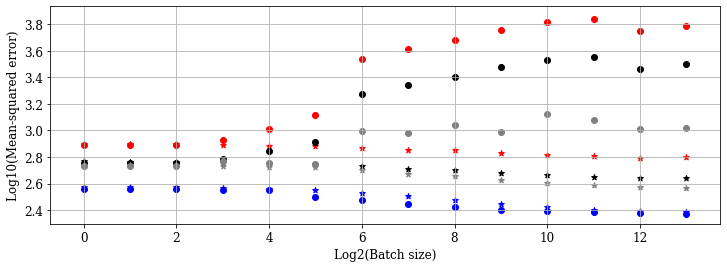

In [29]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.median(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.median(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
plt.grid()
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

Text(0, 0.5, 'Log10(Mean-squared error)')

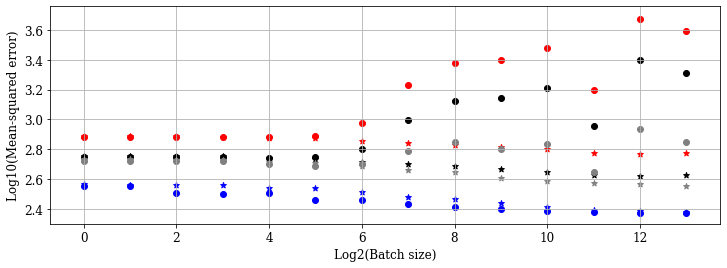

In [30]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.min(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.min(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
plt.grid()
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

Text(0, 0.5, 'Log10(Mean-squared error)')

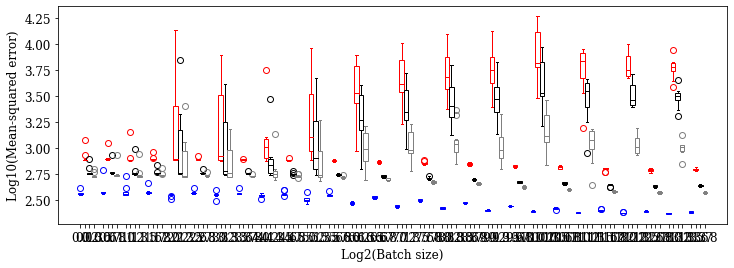

In [32]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        c = color_array[ikey]
        plt.boxplot(x = np.log10(BFval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)+ikey/10])
        plt.boxplot(x = np.log10(CIval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)+0.5+ikey/10])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(BFval)),label=key,color=color_array[ikey])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
#plt.legend()
plt.xlabel('Log2(Batch size)')
plt.ylabel('Log10(Mean-squared error)')

In [40]:
np.log10(400)

2.6020599913279625

# Small data experiments using number of batches instead of batch size

## Overall parameters

In [35]:
N_batch_array = 2**np.arange(3,10) # Number of batches for each experiment
Nep = 50
N_NN = 10 # Number of NN trained per experiment
N_layer = 7 # Number of layers for the NNs
batch_size = 512 # Batch sizes we will consider in these experiments
N_samples = BFgen['both']['train'].n_samples # Total number of samples in the dataset
ptrain = path_array['both'][0]

## Design generators

In [34]:
BFgenSD = {}
CIgenSD = {}

In [36]:
for iN,N_batch in enumerate(N_batch_array):
    BFgenSD[batch_size] = {}
    CIgenSD[batch_size] = {}
    N_batch_max = int(N_samples/batch_size)
    print('N_batch=',N_batch,'& N_batch_max=',N_batch_max)
    
    for iexp in range(N_NN):
        BFgenSD[batch_size][iexp] = {}
        CIgenSD[batch_size][iexp] = {}
        # Randomly select 8 batches
        b_random = np.random.choice(np.linspace(0,N_batch_max-1,N_batch_max),
                                    size=((N_batch,)),
                                    replace=False).astype('int')
        print('Exp#',str(iexp),'b_random=',b_random)
        
        BFgenSD[batch_size][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:4],batch_size=batch_size,rescaling=None)
        BFgenSD[batch_size][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[4:],batch_size=batch_size,rescaling=None)
        
        CIgenSD[batch_size][iexp]['train'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[0:4],batch_size=batch_size,rescaling='CI')
        CIgenSD[batch_size][iexp]['valid'] = Generator_singleDS_smalldata(
            path=ptrain,batch_list=b_random[4:],batch_size=batch_size,rescaling='CI')

N_batch= 8 & N_batch_max= 92144
Exp# 0 b_random= [26686 45281 43606 50937 22594 36973 91405 49500]
Exp# 1 b_random= [19026  1310 34559 52896 58797  2531 70693 36269]
Exp# 2 b_random= [77577 35756 35787 14453 28125 17548 73856 45512]
Exp# 3 b_random= [36443 75011 10580 31638 11098  8179 84814 12182]
Exp# 4 b_random= [43445 49293  7448 62503 68583 71701 11066 45305]
Exp# 5 b_random= [90345 31605 33159  1276 29149 14150 37106 25845]
Exp# 6 b_random= [73175  9651 12961 30222 86460 57822  9806 82968]
Exp# 7 b_random= [84628 13458 31858 62203 85714 30389 50233 27412]
Exp# 8 b_random= [57597 12531 50436 47162 26080 47927 61345 27547]
Exp# 9 b_random= [36833 28470 64676 13052 24271  3968 72997 67957]
N_batch= 16 & N_batch_max= 92144
Exp# 0 b_random= [49124 90861 86368 20736 39297 22153 49341 18133 18763 57541 15960 74885
 28110 74643 57324 72070]
Exp# 1 b_random= [69484 87371 68465  3024 68800 34195 34664 83110 16506 26883 74732 53262
  6860 20305 17747 44526]
Exp# 2 b_random= [47753 35178 288

Exp# 1 b_random= [59247 20640 12066 52178 27710 29557  5311 44992 33564 51592 20131 49220
 29424 66042   565 43628 46965 27400 66881 14115 32954 78666  6308 42706
 25299 17325  2469 56523 15107 40280 53668  6487 34603 56610  1300  4732
 30654 79728 49156 38846 83546 22047 62181 44641 14013  6614 23537 83485
 41423 61129 23938  8670 89288 49980 15125  1053 47677 11607 63316 13026
 68828 43501 69648 28350 91956 79647  6590 87025   216 58671 35560  8973
  6664  4561 41592 59449  4233 64911 74142 18414 50340  7877 47146 43508
 87465 50996 23066 34215  2875   830 39724 76251 75471 76389 47144 76285
 42924 57797 50115 88477   171 35816 37353 81862 16273 91417 20615 73246
 24974 88190 63297 18042  3628 16410 75713 59140 41633  2225  3683 12585
 77018 88734 60291 81786 69792 38055 11099 50558]
Exp# 2 b_random= [70718 88579 44608 66713 32018 47770  5454 28621 58106 91578 65900 73045
 16638 48100  6175 32853  6271 65489  2302 53395 13351 36891  7404 59924
 42171 56620 65211 18424 86610 13547 706

Exp# 1 b_random= [51344 74975 52784 48605 76929 83009  1199 25831 45281 90611  7129 48501
  3297 17280 26926 76943 11928 79470 55593 91249 33840 50215 68835 43037
 90476 68555 34913 54929 36011 89412 63304 50985   836 30738 10958 30168
  3782 64797 66023  9478 69397 43147 15937 75874 88629 23586   949  6370
 82176 73641 56866  7286 81010 11256 42450 61564 84486 28568 47269 66583
 79296 47978 62389 58087 83572 15525 46120 37360 54559 58462 77956 37899
 55764  9628 52063  9041 65965 84562 88662 33742 10933 20975 62852 50400
 76044  1463  8761 50409 17048 36065 47010 65045 51546  4796 70816 73858
 88160 11651 71491 30123 37808 23609 51082 10481   638  9979 88229  5108
 33286 69720 79087 18959 90880 80551 19275  2029 16092 19359 16575 90125
  6609 68506 43636 67403  2826 44176 28816 74506 68498 51443 49335 81986
  8424 27497 77601 55473  3427 40225 32813 72189 30131 84290  9825 28671
 40651 30412 39184  4400 53007 25110 77816  9562 31037 25751 86749 21519
 62716 73128 76088 24399 48350  81

Exp# 7 b_random= [22680  5808 73331 35055 24560 46885 44846 45083 28660 24737 68857 20866
 78867 49601 22501 79303   693 39827  4026 75815 84658 40843 62397 62478
 49559  6201 21413  2945  4634 71604  4808 82367 14464 12607 63305 33288
 43318 41757 18204 24050 18540 63733 54892 26327 18544 28071 50591 70214
 41374  3977 82237  4576 62286 91446  2258  5095 89420 67847 42414 31385
 43079 13788 66513 61662 25624 40941 12888 56025  8273 81364 37591 86116
  5378 12970   201 83029 27941 49801 28646 64897 30976 70885 86085 87411
 54937 13135 34330 71528 49693  3735 18333 50944 15006 37721 77624 73698
 44211 10851 51388 28152 27395 89468 74157 16703 56470 15245  7148 47269
 34198  3005 71810 86700 19317 52452 40820 37711 67228 84910 68620 13329
 60000 15257 77856 82136 92018 22650 41570 70824 60281 48358 39018 92064
 55858 47385 10259 35058 83509 19824 30683 22232 25138 59943 14840 85293
 72506 32251 58455 69748 46838 10204 75729  4473 71874 48775 79741 45014
  1448 50424 49293 49253 21741 487

Exp# 3 b_random= [ 6677 72486  7040 88049 46742 40771 69823 16808 80495 35514 24758 44371
 62750 64898  5130 88223 17423 32857 30213 51742 29285 19754 11611 15092
  2762 31970 22252 12160  7444 68504  7427 55022 89793 49451 13970 11650
 80732 45411 51712 12924 38762 57710 85176 56897 45271 60612 10861  6872
 44541 49720 60950 58723 82445 27234 64875 34907 75140 31343 72411 72884
 90641 46849 36591 48927 86176 54984  8119 69054 35242  5481 77028  8946
 68291 49261 35733 77489 11093 10269 83475 23691 11763 73182 31961 58740
 47266 31468 60655 36196 28080  7808 49794 87490 73592  8786 54460 69960
 46120 27174 76644 26904 29128 29404 75014 69076 55973 81321 60192 78530
 73617 56627  3826 26049 33548 53842 38905  5258 91411 76649 90254  3326
 69255 55664 85047 33415 11199  5542 31909 76775 67201 16282   262 86801
 55112 61658 70739   780 85436 13742 20794 25022 50147 71939  9406 13909
 54691 19297 22244  8143 69045 74436 56289  3633  4477 88611 72179 15940
  4076 36398 84996 65307 67047 706

Exp# 7 b_random= [70914 11262 58925 32015 58895 75553 66152 26629 30644 53219 64554 83228
 37719 83016 63637 35453 64709 77644 11924 70824 23673  1839 16337 53195
 32115  4307 19491  4549 19339 71013 46036 43584  3970 76758 61255 59226
 20538 52797 12831 50033 21410 34771 78084 66569 77596 52171 33439 49787
 87355 40812 52261 88796 22117 52598 72403 76731 32611 20533 19299 75635
 40988 45452 53211 53741 49985 35270 50615 66736 39169 61251 25005 39871
 76268 27521 31786 60817 59890 87056 20110 34793 42461 30221  7262 87520
 28793 58508 76301 87111 13929 42420 68732 52720 57596 26974 24200 88404
 91167 53038  8092 56964 63901 32135 67995 24954 68444 58218  3579 78477
 90927 31257 21657  4374 67351 91381 28836 36896 61530 81583 36866 37205
 39837 27098 67003 38055 50381 87917 62040 57394 36088 59850  2832 29693
 83189 85331  2471 15293 86020 78400 29620 14280 29012 58797 78043 12209
 39006 76686 18706 49895 23348 61735 76770 20352 88988 29793 20368 22310
 42763 69142 83746 72466 20171 586

In [38]:
BFgen['both']['train'].n_samples

94355456

# Plot results varying batch size and number of samples

## Experiment varying number of batches

In [20]:
N_batch_array = 2**np.arange(3,10) # Number of batches for each experiment
Nep = 50
N_NN = 10 # Number of NN trained per experiment
N_layer = 7 # Number of layers for the NNs
batch_size = 512 # Batch sizes we will consider in these experiments
N_samples = BFgen['both']['train'].n_samples # Total number of samples in the dataset
ptrain = path_array['both'][0]

In [21]:
path_test = path_data + 'PKL_DATA/2022_05_17_Performance_Four_Climates_Small_Data'
Nbatch_exp = pickle.load(open(path_test,'rb'))

In [22]:
BF_Nbatch = Nbatch_exp['BFtest']
CI_Nbatch = Nbatch_exp['CItest']

## Experiment varying size of batch 

In [23]:
N_batch = 8 # Number of batches for each experiment
Nep = 100
N_NN = 10 # Number of NN trained per experiment
N_layer = 7 # Number of layers for the NNs
batch_size_array = 2**np.arange(0,14) # Batch sizes we will consider in these experiments
N_samples = BFgen['both']['train'].n_samples # Total number of samples in the dataset
ptrain = path_array['both'][0]

In [24]:
path_test = path_data + 'PKL_DATA/2022_05_16_Performance_Four_Climates_Small_Data'
batchL_exp = pickle.load(open(path_test,'rb'))

In [25]:
BF_batchL = batchL_exp['BFtest']
CI_batchL = batchL_exp['CItest']

## Plots

In [26]:
color_array = ['blue','red','black','gray']

In [61]:
flag = 'batchL'

In [62]:
if flag == 'Nbatch':
    BFtest = BF_Nbatch
    CItest = CI_Nbatch
    XLAB = 'Log2(Number of batches)'
elif flag == 'batchL':
    BFtest = BF_batchL
    CItest = CI_batchL
    XLAB = 'Log2(Batch Size)'

Text(0, 0.5, 'Log10(Mean-squared error)')

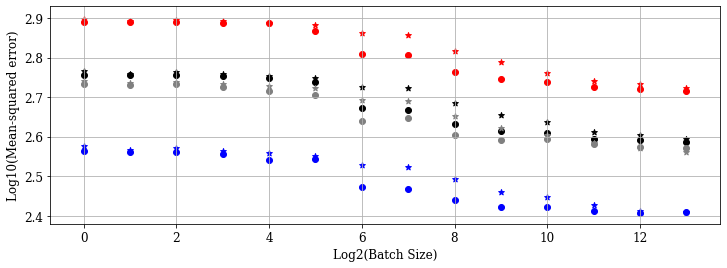

In [65]:
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        plt.scatter(np.log2(batchkey),np.log10(np.median(BFval)),label=key,color=color_array[ikey])
        plt.scatter(np.log2(batchkey),np.log10(np.median(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
plt.grid()
#plt.legend()
plt.xlabel(XLAB)
plt.ylabel('Log10(Mean-squared error)')

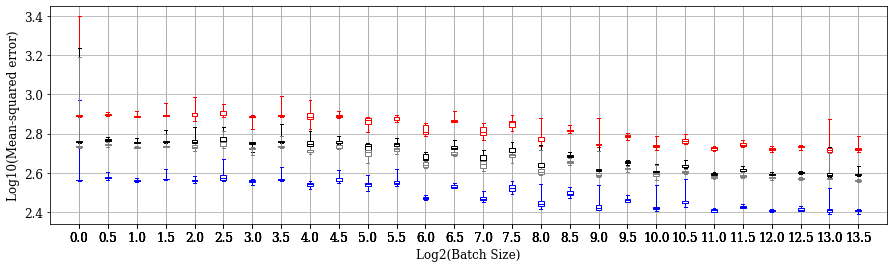

In [64]:
fig = plt.figure(figsize=(15,4))
ax = plt.gca()

ikey = 0
for key in BFtest.keys():
    for batchkey in BFtest[key].keys():
        BFval = list(BFtest[key][batchkey].values())
        CIval = list(CItest[key][batchkey].values())
        c = color_array[ikey]
        plt.boxplot(x = np.log10(BFval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),whis=999,
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)])
        plt.boxplot(x = np.log10(CIval), vert=True,
                    patch_artist=True,
                    boxprops=dict(facecolor='w', color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),whis=999,
                    flierprops=dict(color=c, markeredgecolor=c),
                    medianprops=dict(color=c),widths=0.1,
                    positions=[np.log2(batchkey)+0.5])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(BFval)),label=key,color=color_array[ikey])
        #plt.scatter(np.log2(batchkey),np.log10(np.mean(CIval)),marker='*',color=color_array[ikey])
    ikey += 1
    
#plt.legend()
plt.xlabel(XLAB)
plt.ylabel('Log10(Mean-squared error)')
plt.grid()